***
# Basic constants and functions:
***

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from scipy.fft import fft,ifft

plt.style.use(['science','notebook', 'grid', 'default', 'bright'])

plot_height = 12    #Plot size parameters
plot_width = plot_height*1.618

SMALL_SIZE = 35    #used to adjust figure font size
MEDIUM_SIZE = 50
BIGGER_SIZE = 65

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)

sym.init_printing()

xp = 1/np.sqrt(2)*np.array([[1],[1]]) #spin states
xm = 1/np.sqrt(2)*np.array([[1],[-1]])
yp = 1/np.sqrt(2)*np.array([[1],[1j]])
ym = 1/np.sqrt(2)*np.array([[1],[-1j]])
zp = np.array([[1],[0]])
zm = np.array([[0],[1]])

sx = np.array([[0,1],[1,0]]) #Pauli operators
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])

def pol(wf):
    """Returns polarization vector from wavefuction."""
    temp = [np.dot(i,wf) for i in [sx,sy,sz]]
    return np.array([np.real(np.dot(wf.conj().T,temp[i])[0][0]) for i in range(3)])

def get_vg(lam):
    """Returns neutron group velocity (cm/us) from wavelength (Angstroms)."""
    return (6.62607015/1.674927471)/lam*1e-1

***
## Analytical Crack-Nicolson Matrix:
***

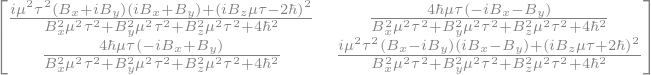

Component:  0


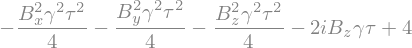

Component:  1


Component:  2


Component:  3


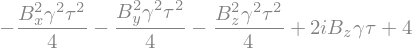

'Denominator:'

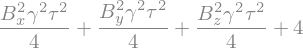

In [2]:
x,y,z,t,p,n1,n2,n3 = sym.symbols('x,y,z,t,phi,n_1,n_2,n_3', real=True)
mu, hbar, ts, g, om = sym.symbols('mu,hbar,tau,gamma,omega', real=True, positive=True)
Bx,By,Bz = sym.symbols('B_x,B_y,B_z', real=True)

idt,spx,spy,spz = sym.eye(2),sym.Matrix([[0,1],[1,0]]),sym.Matrix([[0,-sym.I],[sym.I,0]]),sym.Matrix([[1,0],[0,-1]])

Ham = mu*(Bx*spx+By*spy+Bz*spz)

Back = ((idt + sym.I*ts/(2*hbar)*Ham)**-1)
For = (idt - sym.I*ts/(2*hbar)*Ham)
Tot = sym.simplify(Back*For)
display(Tot)

nTot = Tot.subs({hbar:1,mu:g/2})
for i in range(4):
    n,d = sym.fraction(nTot[i])
    n = sym.expand(n)
    print('Component: ', i)
    display(n)
display('Denominator:',d)

RF flipper Hamiltonian:


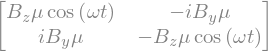

Rotating frame Hamiltonian showing both rotation and nutation:


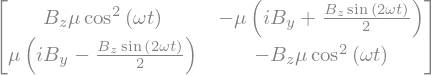

In [3]:
RFHam = mu*(By*spy+Bz*sym.cos(om*t)*spz)
print('RF flipper Hamiltonian:')
display(RFHam)
rot = sym.exp(sym.I*om*t/2*spy).simplify()
invrot = sym.exp(-sym.I*om*t/2*spy).simplify()
rotframe = rot*RFHam*invrot
print('Rotating frame Hamiltonian showing both rotation and nutation:')
display(rotframe.simplify())

Symmetric RF flipper Hamiltonian:


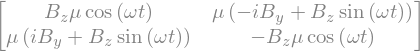

Rotating frame symmetric Hamiltonian showing ONLY rotation:


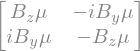

In [12]:
RFHam2 = mu*(By*spy+Bz*(sym.cos(om*t)*spz + sym.sin(om*t)*spx))
print('Symmetric RF flipper Hamiltonian:')
display(RFHam2)
rot = sym.exp(sym.I*om*t/2*spy).simplify()
invrot = sym.exp(-sym.I*om*t/2*spy).simplify()
rotframe2 = rot*RFHam2*invrot
print('Rotating frame symmetric Hamiltonian showing ONLY rotation:')
display(rotframe2.simplify())

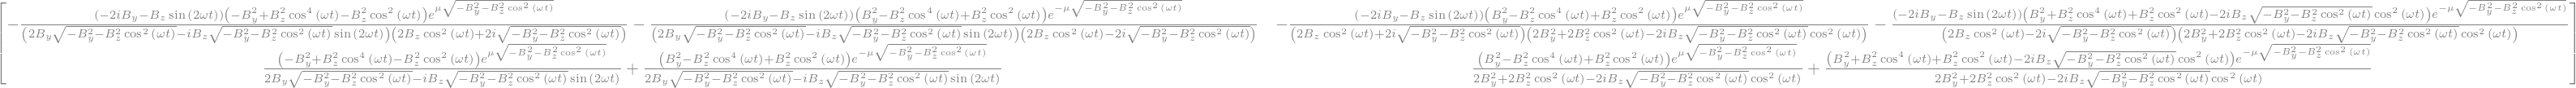

In [13]:
timeevo = sym.exp(sym.I*rotframe.simplify())
display(timeevo)

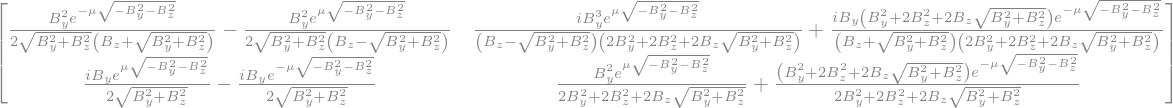

In [10]:
timeevo2 = sym.exp(sym.I*rotframe.simplify())
display(timeevo2)

***
## Definition of mangetic fields and CN matrix:
***

In [4]:
def rect(z,start,end,n,a):
    """Returns 3D constant magnetic field in given direction n with strength a."""
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    temp = np.empty(len(z))
    for i,val in enumerate(z):
        temp[i] = i>=start and i<=end
    return np.array([a*ni*temp for ni in normed])

def smooth_step(z,start,end,n,a):
    """Returns 3D smoothed step function of magnetic field in given direction n with strength a"""
    s,e = z[start],z[end]
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    a0 = (s**3 - 3*s**2*e)/(s - e)**3
    a1 = 6*s*e/(s - e)**3
    a2 = -3*(s + e)/(s - e)**3
    a3 = 2/(s - e)**3
    temp = np.zeros(len(z))
    temp[start:end] = a0 + a1*z[start:end] + a2*z[start:end]**2 + a3*z[start:end]**3
    temp[end:-1] = np.ones(len(zpos)-end - 1)
    temp[-1] = 1
    return np.array([a*ni*temp for ni in normed])

def g_rect(z,start,end,n,a,av,sig,frown=True):
    """Returns 3D gaussian magnetic field in given direction n with strength a.
    Smile parameter controls convex/concave profile."""
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    temp = np.empty(len(z))
    if frown:
        for i,val in enumerate(z):
            temp[i] = (i>=start and i<=end)*np.exp(-(val-av)**2/(2*sig**2))
    else:
        for i,val in enumerate(z):
            temp[i] = (i>=start and i<=end)*(1-1e-2*np.exp(-(val-av)**2/(2*sig**2)))
    return np.array([a*ni*temp for ni in normed])

def sol_B(z,radius,start,end):
    """Returns analytic finite solenoid envelope."""
    temp = ((z-start)/np.sqrt((z-start)**2 + radius**2) - (z-end)/np.sqrt((z-end)**2 + radius**2))
    return temp/np.max(temp)

def gauss_B(z,amp,av,sig):
    """Returns gaussian field component."""
    return amp*np.exp(-(z-av)**2/(2*sig**2))

def cos_B(t,amp,freq,phase):
    """Returns time-harmonic (cosine) magnetic field. Use phase=-np.pi/2 for sin."""
    return amp*np.cos(freq*t + phase)

def g_cos_B(t,amp,freq,phase,av,sig):
    """Returns time-harmonic (cosine) magnetic field with gaussian envelope.
    Use phase=-np.pi/2 for sin."""
    return np.exp(-(t-av)**2/(2*sig**2))*amp*np.cos(freq*t + phase)

def get_rf_flipper(a,n,start,end,amp,freq,phase,Fankang=False,real_static=False,real_amp=False,\
                   av_B0=4.4,sig_B0=95,av_rf=50.05,sig_rf=15):
    """Defines and returns magnetic field from longitudinal RF flipper. Fankang option only
    works with the idealized RF field. Default parameters for a 8.8 cm long flipper at 4.5 Ang
    with a 0.1% static field variation and zero RF amplitude at the boundaries."""
    if real_static:
        B_tot = smooth_step(zpos,start,start+25,n,a) - smooth_step(zpos,end-25,end,n,a)
        #B_tot = g_rect(zpos,start,end,n,a,av_B0,sig_B0)
    else:
        B_tot = rect(zpos,start,end,n,a)
    Bt_tot = get_Bt(tpos,tau,delta,vg,B_tot)
    t_mask = np.array([[True if Bt_tot[j,t]*n[j] != 0 else False for t in range(len(tpos))] for j in range(3)])

    if real_amp:
        Bt_harm = np.array([np.zeros(len(tpos)),np.zeros(len(tpos)),g_cos_B(tpos,amp,freq,phase,av_rf,sig_rf)])
    else:
        Bt_harm = np.array([np.zeros(len(tpos)),np.zeros(len(tpos)),cos_B(tpos,amp,freq,phase)])
        if Fankang:
            Bt_harm[0] = cos_B(tpos,amp,freq,phase-np.pi/2)
    for j in range(len(tpos)):
        if not (t_mask[0,j] or t_mask[1,j] or t_mask[2,j]):
            Bt_harm[0,j],Bt_harm[1,j],Bt_harm[2,j] = 0,0,0
    
    return Bt_tot+Bt_harm

def get_Bt(t,t_step,delta,v,B):
    """Returns the field seen by the moving neutron."""
    bpoint = 0
    temp = [np.empty(len(t)),np.empty(len(t)),np.empty(len(t))]
    for i,val in enumerate(t):
        if val*v > delta*(bpoint + 1):
            bpoint += 1
        temp[0][i] = B[0][bpoint]
        temp[1][i] = B[1][bpoint]
        temp[2][i] = B[2][bpoint]
    return np.array(temp)

def get_CNM(B,t_step):
    """Returns Crank-Nicolson matrix for given magnetic field B."""
    bms = np.sum([i**2 for i in B])
    CNM = np.zeros((2,2),dtype=np.complex_)
    CNM[0,0] = 4 - 2j*B[2]*t_step*gamma - (bms*(t_step*gamma)**2)/4
    CNM[1,0] = -2j*(B[0] - 1j*B[1])*t_step*gamma
    CNM[0,1] = -2j*(B[0] + 1j*B[1])*t_step*gamma
    CNM[1,1] = 4 + 2j*B[2]*t_step*gamma - (bms*(t_step*gamma)**2)/4
    return 1/(bms*(t_step*gamma/2)**2 + 4)*CNM

def do_sim(psi_0,dist,points,vg,Bt_tot,plot_bt=True,pol_on_bt=False,plot_pol=True,\
           plot_Pi=(True,True,True,False),plot_Bi=(True,True,True,True)):
    """Returns polarization (3D real vector) at every time point."""
    psi = np.array([np.zeros((2,2),dtype=np.complex_) for i in tpos]) #holds all wavefunctions

    psi[0] = psi_0 #initial wavefunction
    for i in range(1,t_points):
        psi[i] = np.dot(get_CNM(Bt_tot[:,i],tau),psi[i-1])
    pols = np.array([pol(i) for i in psi])
    
    if plot_bt:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Magnetic field components')
        plt.xlabel('Time (us)')
        plt.ylabel('Strength (mT)')
        if plot_Bi[0]: plt.plot(tpos, Bt_tot[0], label='Bx(t)', linewidth=5, color='C0')
        if plot_Bi[1]: plt.plot(tpos, Bt_tot[1], label='By(t)', linewidth=5, color='C1')
        if plot_Bi[2]: plt.plot(tpos, Bt_tot[2], label='Bz(t)', linewidth=5, color='C2')
        if plot_Bi[3]: 
            plt.plot(tpos, np.sqrt(Bt_tot[0]**2+Bt_tot[1]**2+Bt_tot[2]**2), '-', label='|B(t)|', linewidth=4, color='C3')
        if pol_on_bt:
            if plot_Pi[0]: plt.plot(tpos, pols[:,0], '-.', label='Px(t)', linewidth=4, color='C0')
            if plot_Pi[1]: plt.plot(tpos, pols[:,1], '-.', label='Py(t)', linewidth=4, color='C1')
            if plot_Pi[2]: plt.plot(tpos, pols[:,2], '-.', label='Pz(t)', linewidth=4, color='C2')
        plt.grid()
        plt.legend()
        plt.show()
    
    if plot_pol:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Polarization components')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        if plot_Pi[0]: plt.plot(tpos, pols[:,0], label='Px(t)', linewidth=5, color='C0')
        if plot_Pi[1]: plt.plot(tpos, pols[:,1], label='Py(t)', linewidth=5, color='C1')
        if plot_Pi[2]: plt.plot(tpos, pols[:,2], label='Pz(t)', linewidth=5, color='C2')
        if plot_Pi[3]: plt.plot(tpos, [np.sqrt(np.sum([i**2 for i in pols[j]])) for j in range(len(pols[:,0]))], '--', \
                                label='|P(t)|', linewidth=4, color='C3')
        plt.grid()
        plt.legend()
        plt.show()
        
    return pols

***
## Simulation scans:
***

In [5]:
def do_b0_scan(start,end,num,new_amp,new_freq,real_static=False,real_amp=False,plot=False):
    """Does static field scan of either an idealized or realistic flipper.
    Returns polarization only."""
    b0s = np.linspace(start,end,num)
    pols = [[] for i in b0s]
    
    if not real_amp: new_amp = rf_amp
    if not real_static: new_freq = rf_freq
    
    for indx,b in enumerate(b0s):
        if plot: print('Static field: (mT)', b)
        if real_static or real_amp:
            Bt = get_rf_flipper(b,(0,1,0),r_i,r_e,new_amp,new_freq,0,real_static=real_static,real_amp=real_amp)
        else:
            Bt = get_rf_flipper(b,(0,1,0),r_i,r_e,rf_amp,rf_freq,0)
        pols[indx] = do_sim(yp,dist,t_points,vg,Bt,plot_bt=False,plot_pol=plot,\
                              plot_Pi=(plot,plot,False,False),plot_Bi=(True,True,True,False))
    return pols

def do_amp_scan(start,end,num,real_static=False,real_amp=False,so=False,higher_order_tune=False):
    """Does RF amplitude scan of either an idealized or realistic flipper.
    Returns polarization only."""
    amps = np.linspace(start,end,num)
    pols = [[] for i in amps]
    for indx,A in enumerate(amps):
        Bt = get_rf_flipper(b_0,(0,1,0),r_i,r_e,A,rf_freq,0,real_static=real_static,real_amp=real_amp)
        pols[indx] = do_sim(yp,dist,t_points,vg,Bt,plot_bt=False,plot_pol=False,\
                              plot_Pi=(True,True,True,False),plot_Bi=(True,True,True,False))
    return pols

def do_freq_scan(start,end,num,real_static=False,real_amp=False,higher_order_tune=False):
    """Does RF frequency scan of either an idealized or realistic flipper.
    Returns polarization only."""
    freqs = np.linspace(start,end,num)
    pols = [[] for i in freqs]
    for indx,f in enumerate(freqs):
        Bt = get_rf_flipper(b_0,(0,1,0),r_i,r_e,rf_amp,f,0,real_static=real_static,real_amp=real_amp)
        pols[indx] = do_sim(yp,dist,t_points,vg,Bt,plot_bt=False,plot_pol=False,\
                              plot_Pi=(True,True,True,False),plot_Bi=(True,True,True,False))
    return pols

def get_new_amp(s,e,num,real_static=True,real_amp=True,plot=True):
    """Returns retuned RF amplitude."""
    scan_pols_r = np.array(do_amp_scan(s,e,num,real_static=real_static,real_amp=real_amp))
    new_amp = np.linspace(s,e,num)[np.argmin(scan_pols_r[:,-1,1])]
    print('Min pol of ', np.min(scan_pols_r[:,-1,1]), ' at RF amp ', new_amp)
    if plot:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('RF amp scan')
        plt.xlabel('RF amp (mT)')
        plt.ylabel('Exit pol.')
        plt.plot(np.linspace(s,e,num), scan_pols_r[:,-1,1],'o-',ms=6,linewidth=6)
        plt.grid()
        plt.show()
    return new_amp
    
def get_new_freq(s,e,num,real_static=True,real_amp=True,plot=True):
    """Returns retuned RF frequency."""
    scan_pols_r = np.array(do_freq_scan(s,e,num,real_static=real_static,real_amp=real_amp))
    new_freq = np.linspace(s,e,num)[np.argmin(scan_pols_r[:,-1,1])]
    print('Min pol of ', np.min(scan_pols_r[:,-1,1]), ' at RF freq ', 1e3*new_freq/(2*np.pi))
    if plot:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('RF freq scan')
        plt.xlabel('RF freq (kHz)')
        plt.ylabel('Exit pol.')
        plt.plot(1e3*np.linspace(s,e,num)/(2*np.pi), scan_pols_r[:,-1,1],'o-',ms=6,linewidth=6)
        plt.grid()
        plt.show()
    return new_freq

def compare_b0(s,e,num,new_amp,new_freq,real_static=True,real_amp=True,plot=False):
    """Does static field scan of an idealized and realistic flipper and compares the results.
    Returns new static field."""
    if plot: print('IDEAL: \n')
    scan_pols_i = np.array(do_b0_scan(s,e,num,new_amp,new_freq,plot=plot))
    if plot: print('REAL: \n')
    scan_pols_r = np.array(do_b0_scan(s,e,num,new_amp,new_freq,real_static=real_static,real_amp=real_amp,plot=plot))
    print('Comparison: \n')
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title('Static field scan')
    plt.xlabel('B0 (mT)')
    plt.ylabel('Exit pol.')
    plt.plot(np.linspace(s,e,num), scan_pols_i[:,-1,1],'o-',ms=6,linewidth=6,label='Idealized')
    plt.plot(np.linspace(s,e,num), scan_pols_r[:,-1,1],'o-',ms=6,linewidth=6,label='Real')
    print('Ideal: Min pol of ', np.min(scan_pols_i[:,-1,1]), ' at b0 ', np.linspace(s,e,num)[np.argmin(scan_pols_i[:,-1,1])])
    new_b0 = np.linspace(s,e,num)[np.argmin(scan_pols_r[:,-1,1])]
    print('Real: Min pol of ', np.min(scan_pols_r[:,-1,1]), ' at b0 ', new_b0)
    plt.legend()
    plt.grid()
    plt.show()
    return new_b0

def retuned_compare(new_b0,new_amp,new_freq,plot_pol=True,plot_bt=False):
    """Compares efficiency after retune. Returns ideal and real polarizations."""
    Bt = get_rf_flipper(b_0,(0,1,0),r_i,r_e,rf_amp,rf_freq,0,
                      real_static=False,real_amp=False)
    Bt2 = get_rf_flipper(new_b0,(0,1,0),r_i,r_e,new_amp,new_freq,0,
                      real_static=True,real_amp=True)

    pols = do_sim(yp,dist,t_points,vg,Bt,plot_bt=plot_bt,plot_pol=plot_pol,\
                plot_Pi=(True,True,False,False),plot_Bi=(False,True,True,False))
    pols2 = do_sim(yp,dist,t_points,vg,Bt2,plot_bt=plot_bt,plot_pol=plot_pol,\
                 plot_Pi=(True,True,False,False),plot_Bi=(False,True,True,False))

    print('Ideal: Minimum pol: ', round(np.min(pols[:,1]),5))
    tmin = np.argmin(pols[:,1])
    print('Ideal: Minimum pol at t=', round(tpos[tmin],5), '\n')
    print('Real: Minimum pol: ', round(np.min(pols2[:,1]),5))
    tmin2 = np.argmin(pols2[:,1])
    print('Real: Minimum pol at t=', round(tpos[tmin2],5), '\n')

    print('Ideal: Final pol: ', round(pols[-1,1],5))
    print('Real: Final pol: ', round(pols2[-1,1],5))
    return pols,pols2

def get_envelope(pols,pols2,s=5000,e=-5000,plot=True):
    """Returns oscillation envelopes."""
    env_x,env_z = np.abs(hilbert(pols[:,0])),np.abs(hilbert(pols[:,2]))
    env_x2,env_z2 = np.abs(hilbert(pols2[:,0])),np.abs(hilbert(pols2[:,2]))

    if plot: #compares polarizations
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. envelope comparison')
        plt.xlabel('Time (us)')
        plt.ylabel('Polarization')
        plt.plot(tpos[s:e],env_x[s:e],'--', color='C0', linewidth=4, label='Id. Px')
        plt.plot(tpos[s:e],env_x2[s:e],'-', color='C0', linewidth=4, label='Re. Px')
        plt.plot(tpos[s:e],pols[s:e,1],'--', color='C1', linewidth=4, label='Id. Py')
        plt.plot(tpos[s:e],pols2[s:e,1],'-', color='C1', linewidth=4, label='Re. Py')
        plt.plot(tpos[s:e],-env_z[s:e],'--', color='C2', linewidth=4, label='-Id. Pz')
        plt.plot(tpos[s:e],-env_z2[s:e],'-', color='C2', linewidth=4, label='-Re. Pz')
        plt.grid()
        plt.legend()
        plt.show()     
    return env_x,env_z,env_x2,env_z2

def do_stability_check(pols,pols2,s=-42500,e=-27500,plot_range=10000,plot_near_min=False,plot_near_exit=True):
    """Plots polarization near exit of the flipper. Returns nothing."""
    if plot_near_min: #near polarization mimimum
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Real pol. near minimum')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol')
        plt.plot(tpos[tmin2-plot_range:tmin2+plot_range],pols2[tmin2-plot_range:tmin2+plot_range,0], linewidth=5, label='Px')
        plt.plot(tpos[tmin2-plot_range:tmin2+plot_range],\
                 np.ones(plot_range*2)+pols2[tmin2-plot_range:tmin2+plot_range,1], linewidth=5, label='1+Py')
        plt.plot(tpos[tmin2-plot_range:tmin2+plot_range],pols2[tmin2-plot_range:tmin2+plot_range,2], linewidth=5, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
        print(pols2[-1,:],np.sqrt(np.sum([i**2 for i in pols2[-1,:]])))

    if plot_near_exit: #near exit
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol near exit')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol')
        plt.plot(tpos[s:e],pols[s:e,0], '--', color='C0', linewidth=4, label='Id. Px')
        plt.plot(tpos[s:e],pols2[s:e,0], color='C0', linewidth=4, label='Re. Px')
        plt.plot(tpos[s:e],np.ones(abs(s-e))+pols[s:e,1], '--', color='C1', linewidth=4, label='Id. 1+Py')
        plt.plot(tpos[s:e],np.ones(abs(s-e))+pols2[s:e,1], color='C1', linewidth=4, label='Re. 1+Py')
        plt.plot(tpos[s:e],pols[s:e,2], '--', color='C2', linewidth=4, label='Id. Pz')
        plt.plot(tpos[s:e],pols2[s:e,2], color='C2', linewidth=4, label='Re. Pz')
        plt.grid()
        plt.legend()
        plt.show()
        plt.show()
        print('Real pol. norm check: ', pols2[-1,:], '->', np.sqrt(np.sum([i**2 for i in pols2[-1,:]])))

***
## GLOBAL simulation parameters:
***

In [6]:
gamma = -1.83247171*1e-1 #neutron gyromagnetic ratio (rad per mT us)

dist = 8.8 #total beamline length (cm)
points = 200 #number of lattice points
delta = dist/points #lattice spacing (cm)
zpos = np.linspace(0,dist,points) #space lattice

lam = 4.5 #neutron wavelength (Angstoms)
vg = get_vg(lam) #group velocity (cm per us)

time = dist/vg #total time (us)

r_i,r_e = 0, 199 #start and end points
length = (r_e - r_i + 1)*delta #RF flipper length (cm)
time = length/vg #time spent inside RF flipper (us)

rf_freq = 2*np.pi*.5 #angular RF frequency (rads per us)
rf_amp = 2*np.pi/(time*abs(gamma))
b_0 = rf_freq/abs(gamma)

tau = np.pi/(300*rf_freq) #time step (us), over 250 per nutation periods
t_points = round(time/tau) #number of time steps
tpos = np.linspace(0,time,t_points) #time lattice

print('Flip parameters:')
print('RF freq (kHz): ', round(1e3*rf_freq/(2*np.pi),3))
print('RF amp (mT): ', round(rf_amp,3))
print('Static field (mT): ', round(b_0,3),'\n')
print('Fixed coil parameters:')
print('Coil length (cm): ', round(length,3))
print('Flight time (us): ', round(time,3),'\n')
print('Time parameters:')
print('Time step size (ns): ', round(1e3*tau,3))
print('RF period (us): ', round(2*np.pi/rf_freq,3))
print('Nutation period (us): ', round(np.pi/rf_freq,3))
print('Time steps per nutation period: ', round(np.pi/rf_freq/tau,3))

Flip parameters:
RF freq (kHz):  500.0
RF amp (mT):  0.343
Static field (mT):  17.144 

Fixed coil parameters:
Coil length (cm):  8.8
Flight time (us):  100.1 

Time parameters:
Time step size (ns):  3.333
RF period (us):  2.0
Nutation period (us):  1.0
Time steps per nutation period:  300.0


***
### RF flipper single simulation:
***

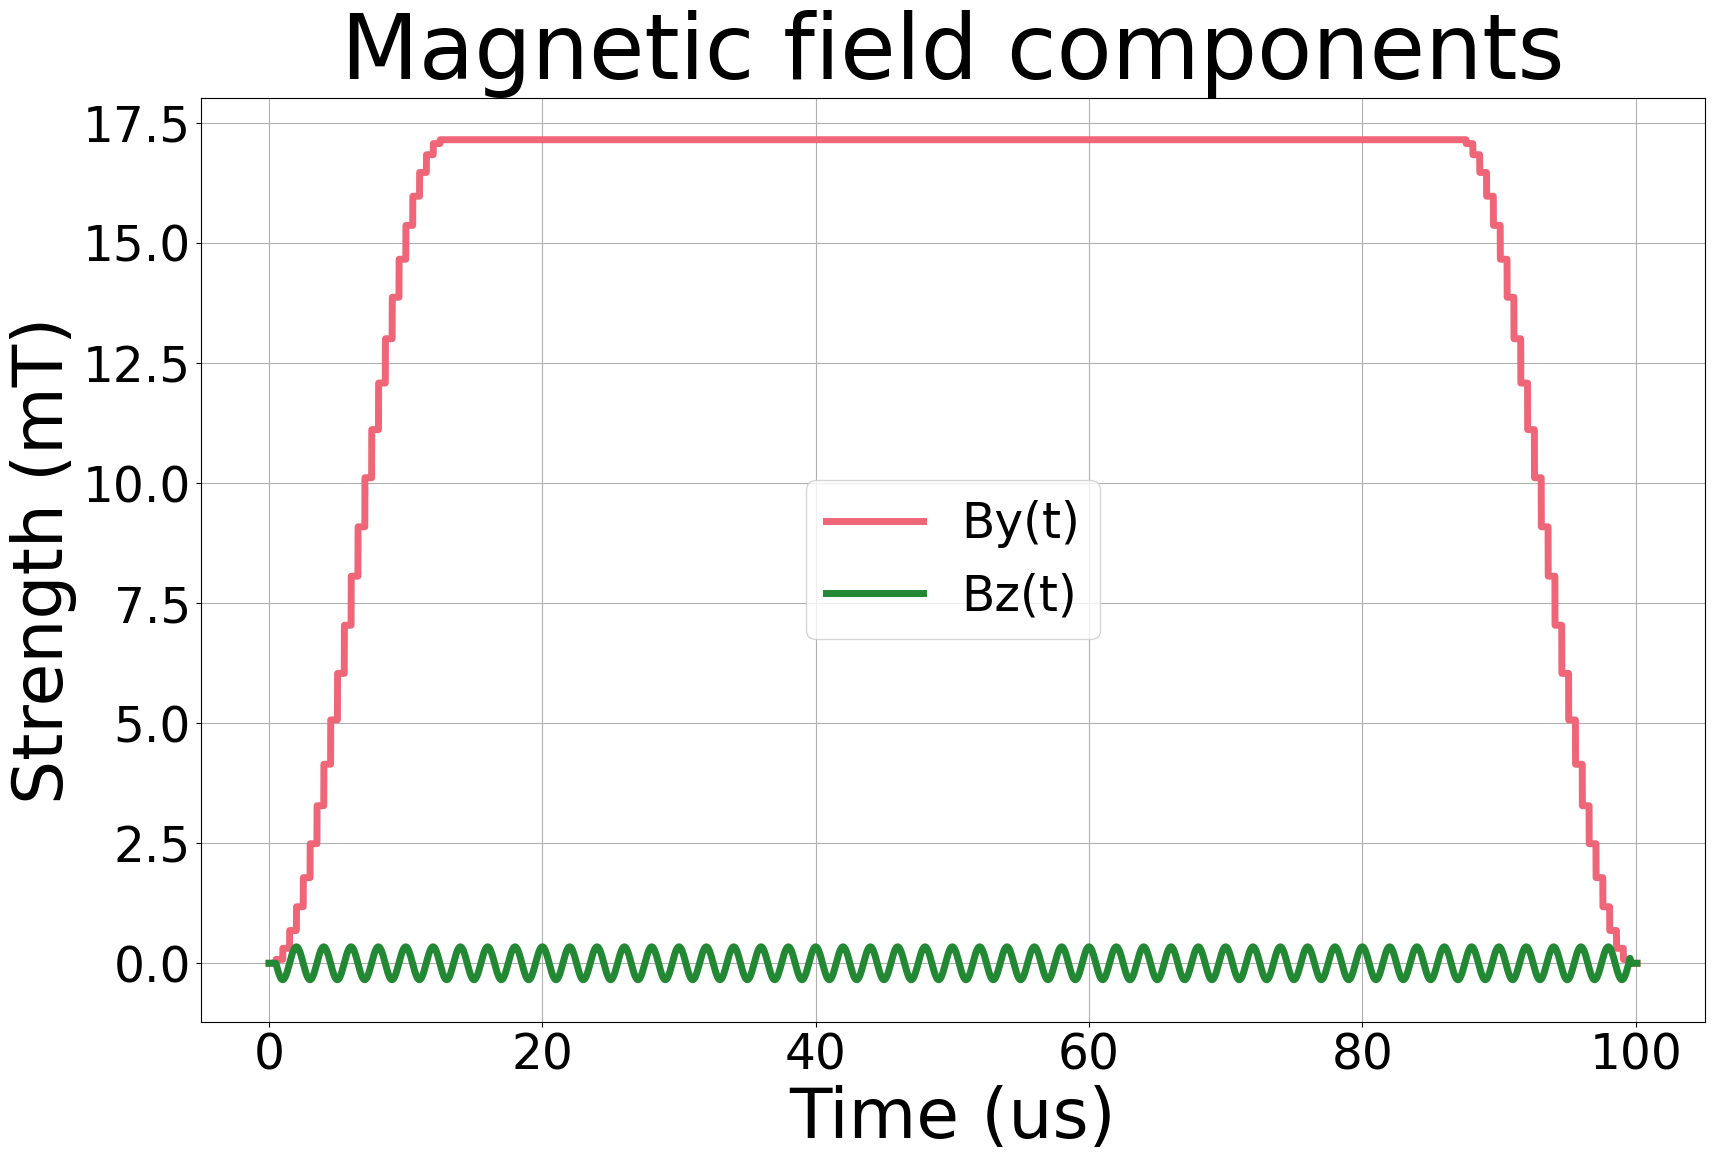

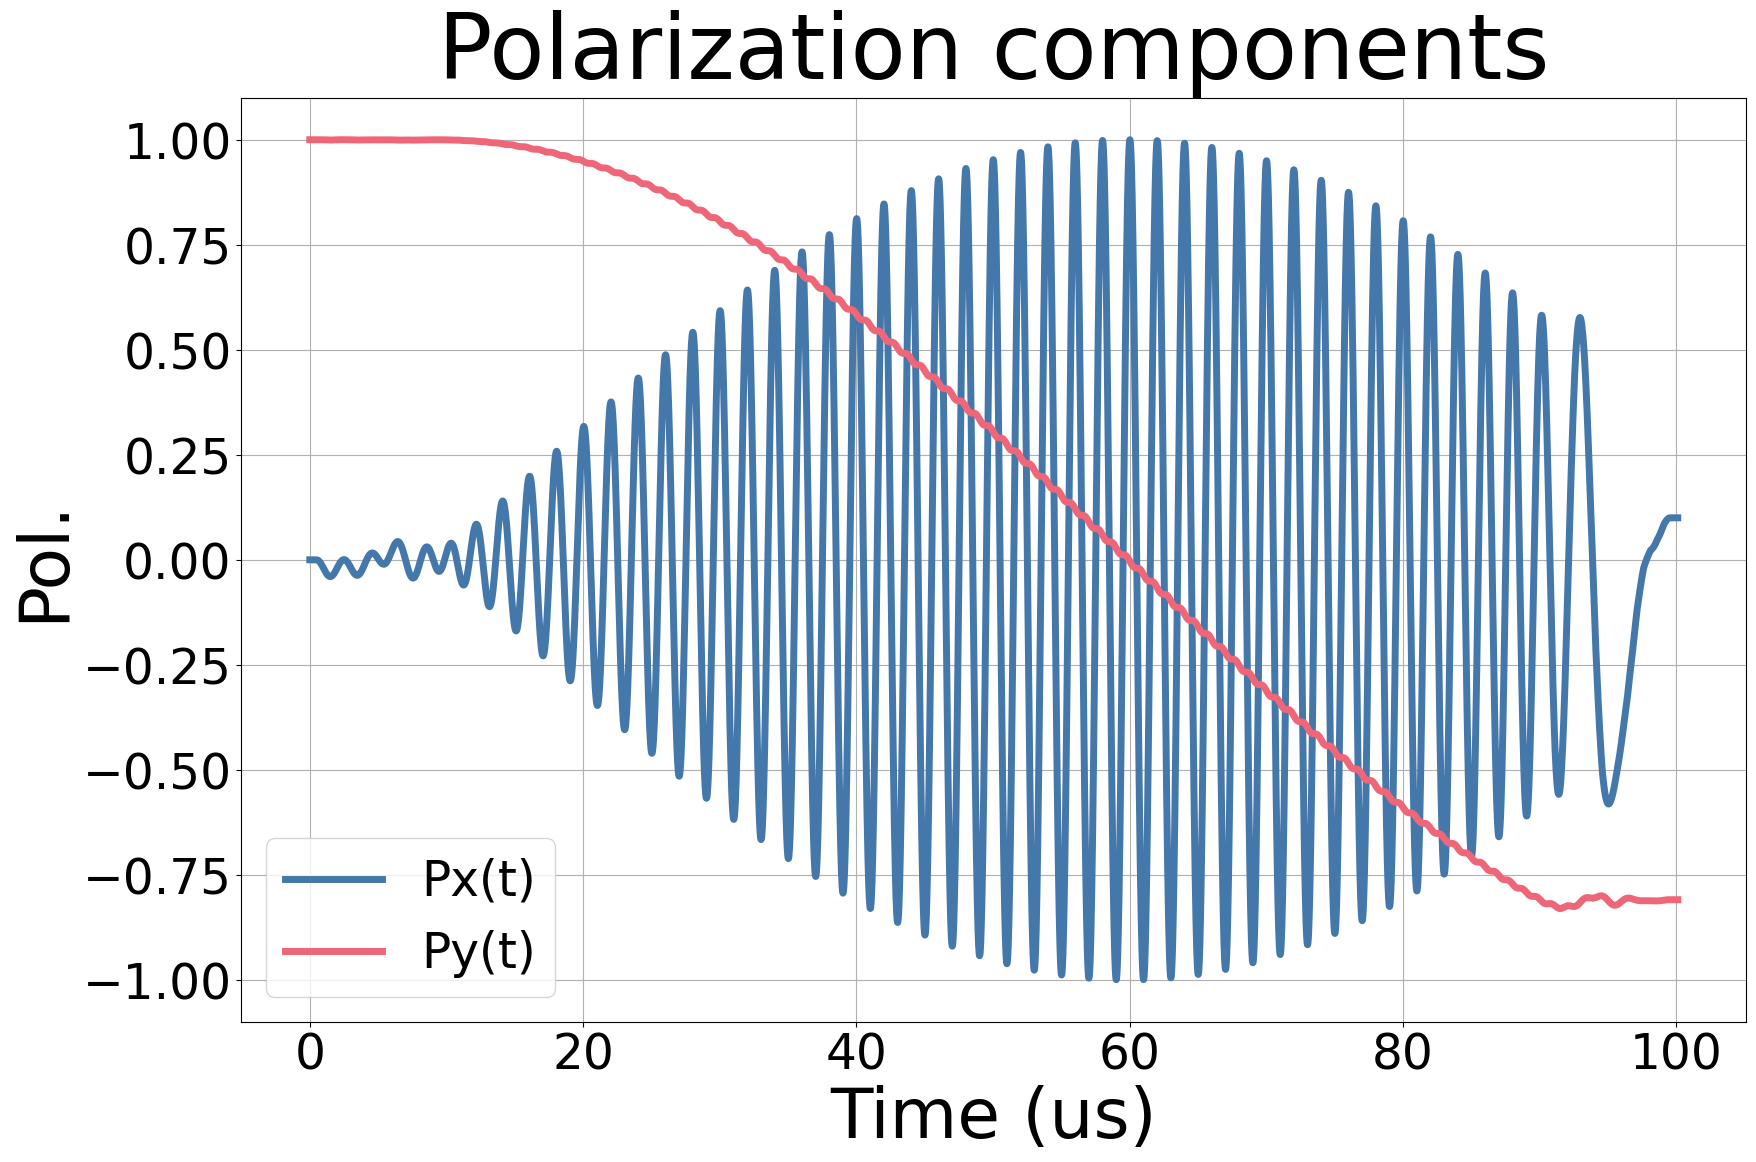

Minimum pol:  -0.83016
Minimum pol at t= 91.5 

Final pol:  -0.80916
Final pol at t= 100.1


In [12]:
Bt = get_rf_flipper(b_0,(0,1,0),r_i,r_e,rf_amp,rf_freq,0,real_static=True,real_amp=False, \
                   av_B0=4.4,sig_B0=95,av_rf=50.05,sig_rf=15)
#print((np.max(Bt[1,:])-np.min(Bt[1,:]))/np.max(Bt[1,:])*100)

pols = do_sim(yp,dist,t_points,vg,Bt,plot_bt=True,plot_pol=True,\
                plot_Pi=(True,True,False,False),plot_Bi=(False,True,True,False))

print('Minimum pol: ', round(np.min(pols[:,1]),5))
tmin = np.argmin(pols[:,1])
print('Minimum pol at t=', round(tpos[tmin],3), '\n')

print('Final pol: ', round(pols[-1,1],5))
print('Final pol at t=', round(tpos[-1],3))

***
# Retuning 500 kHz smoothed step
***

Min pol of  0.3886469875258995  at RF freq  499.8673708807567


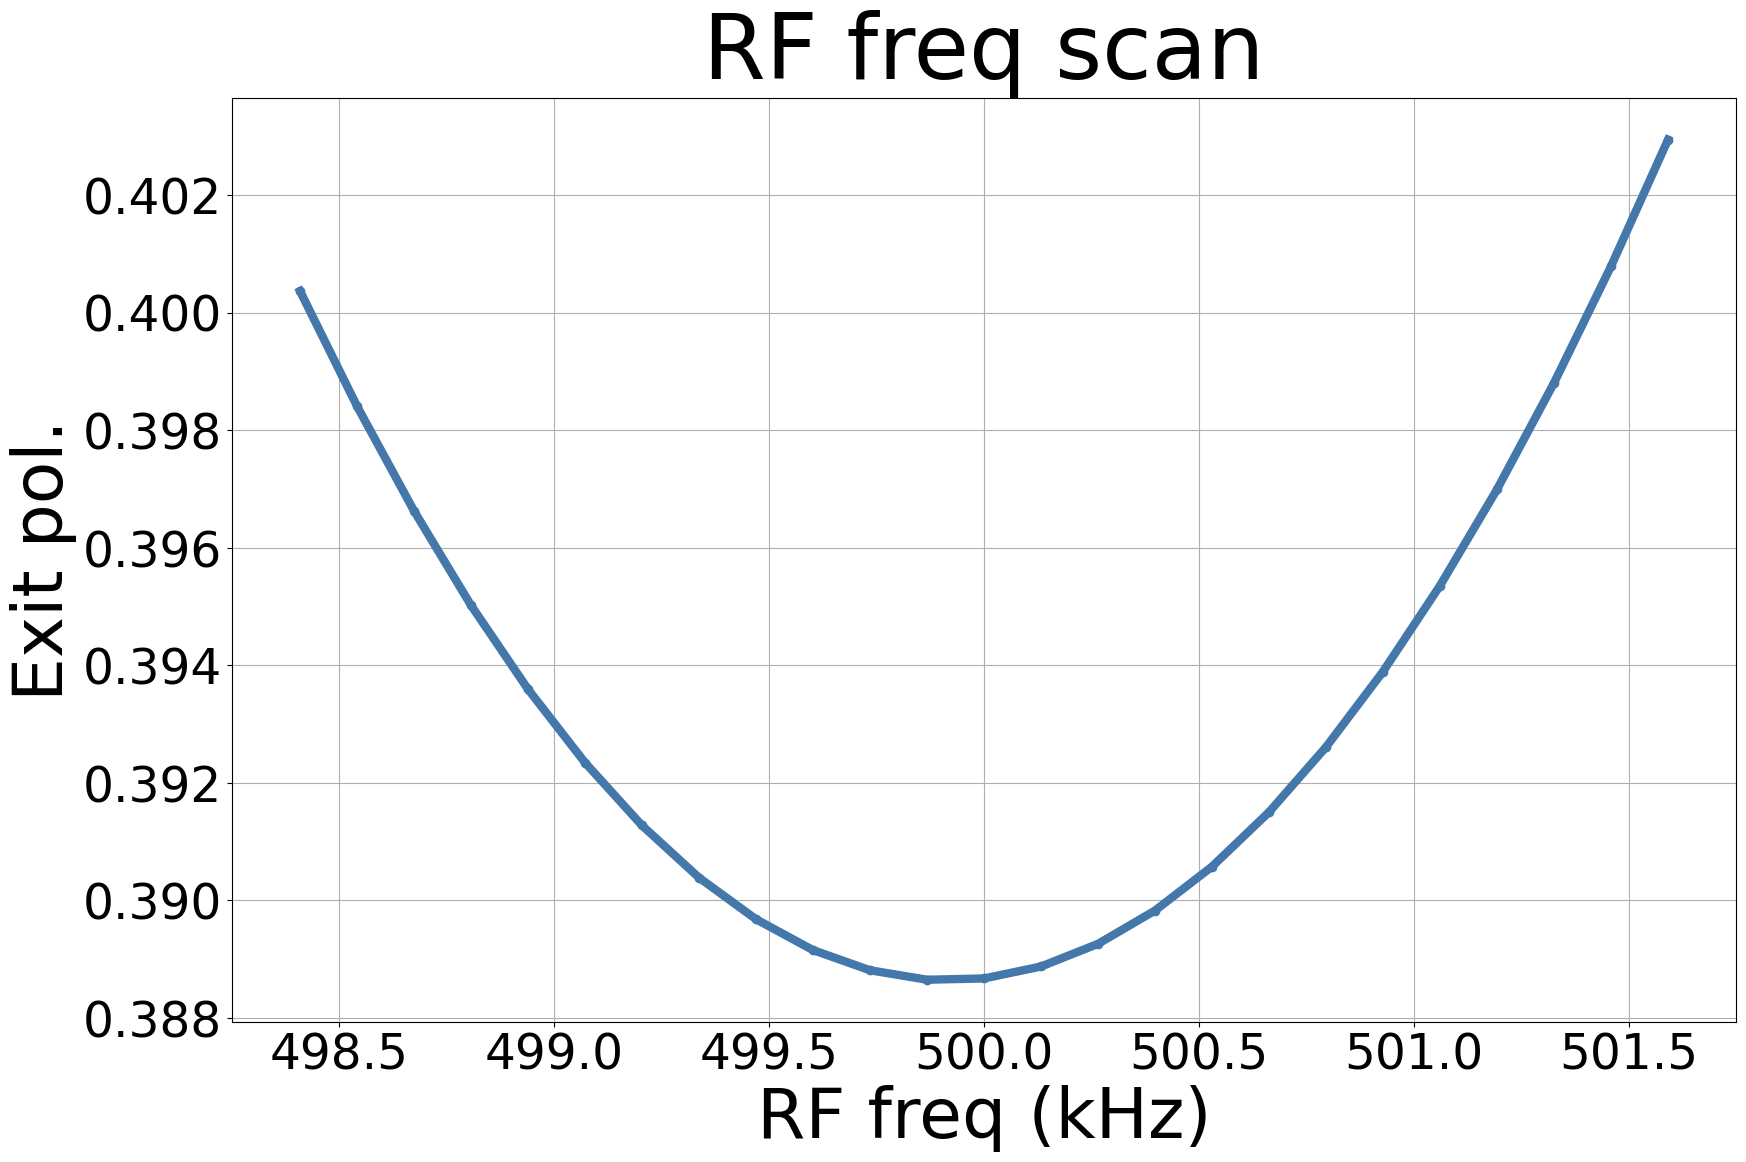

Min pol of  -0.9996822786641991  at RF amp  0.9258702842793349


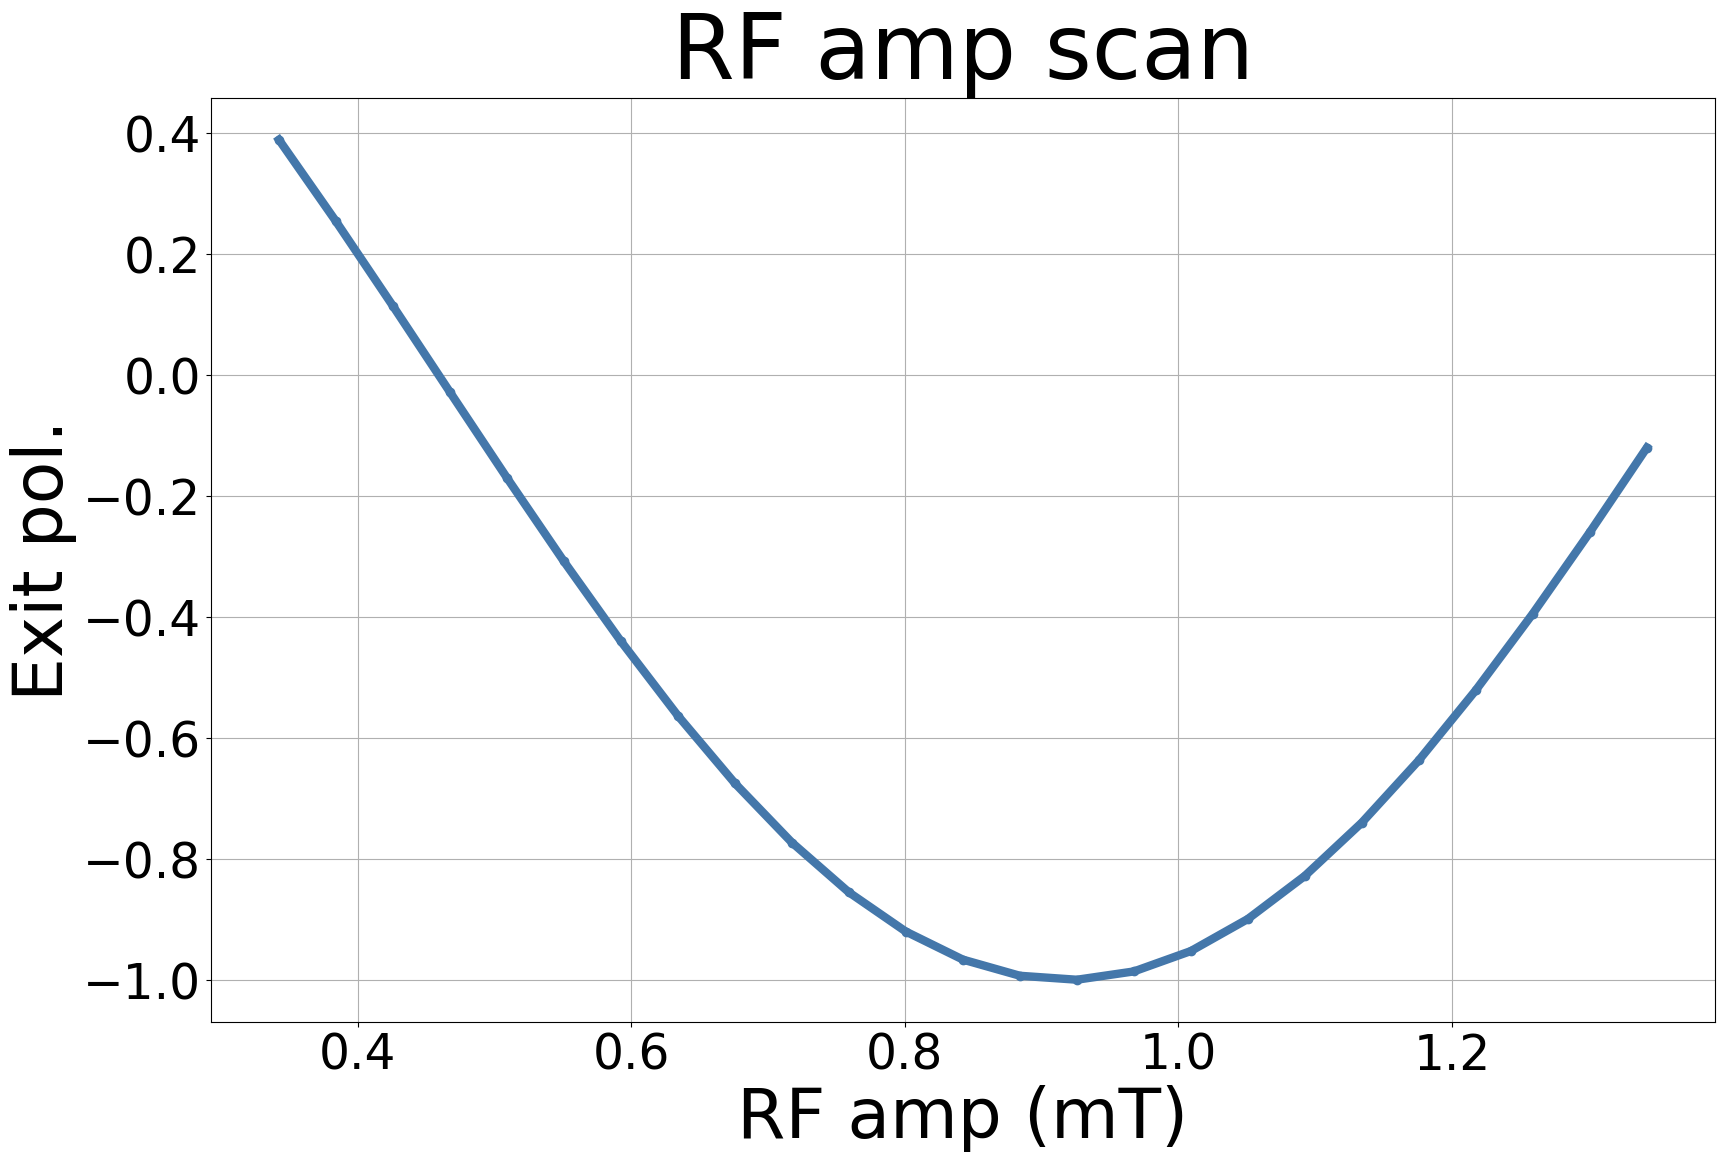

Comparison: 

Ideal: Min pol of  -0.9999285097726283  at b0  17.144017211538795
Real: Min pol of  -0.9993340856381777  at b0  17.144017211538795


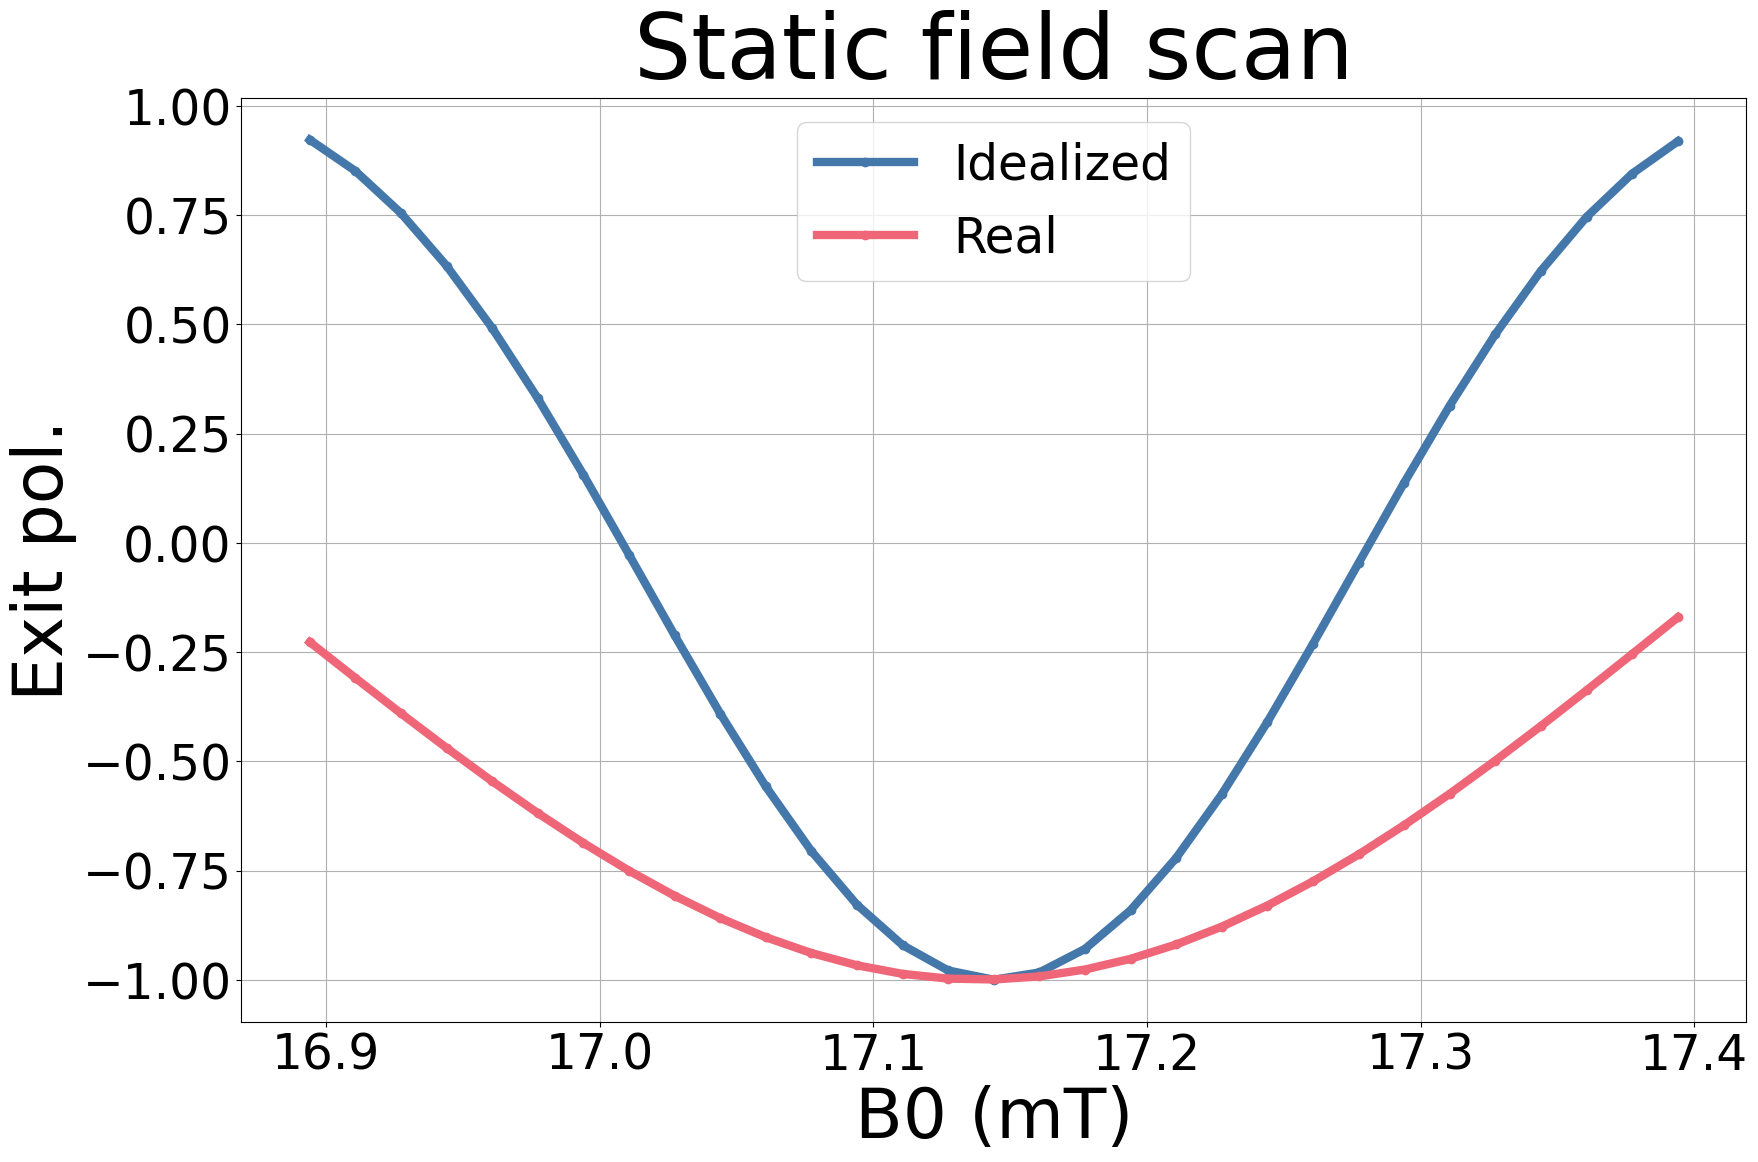

In [13]:
new_freq = get_new_freq(rf_freq-1e-2,rf_freq+1e-2,25,real_static=True,real_amp=True)
new_amp = get_new_amp(rf_amp,rf_amp+1,25,real_static=True,real_amp=True,plot=True)
new_b0 = compare_b0(b_0-.25,b_0+.25,31,new_amp,new_freq,real_static=True,real_amp=True)

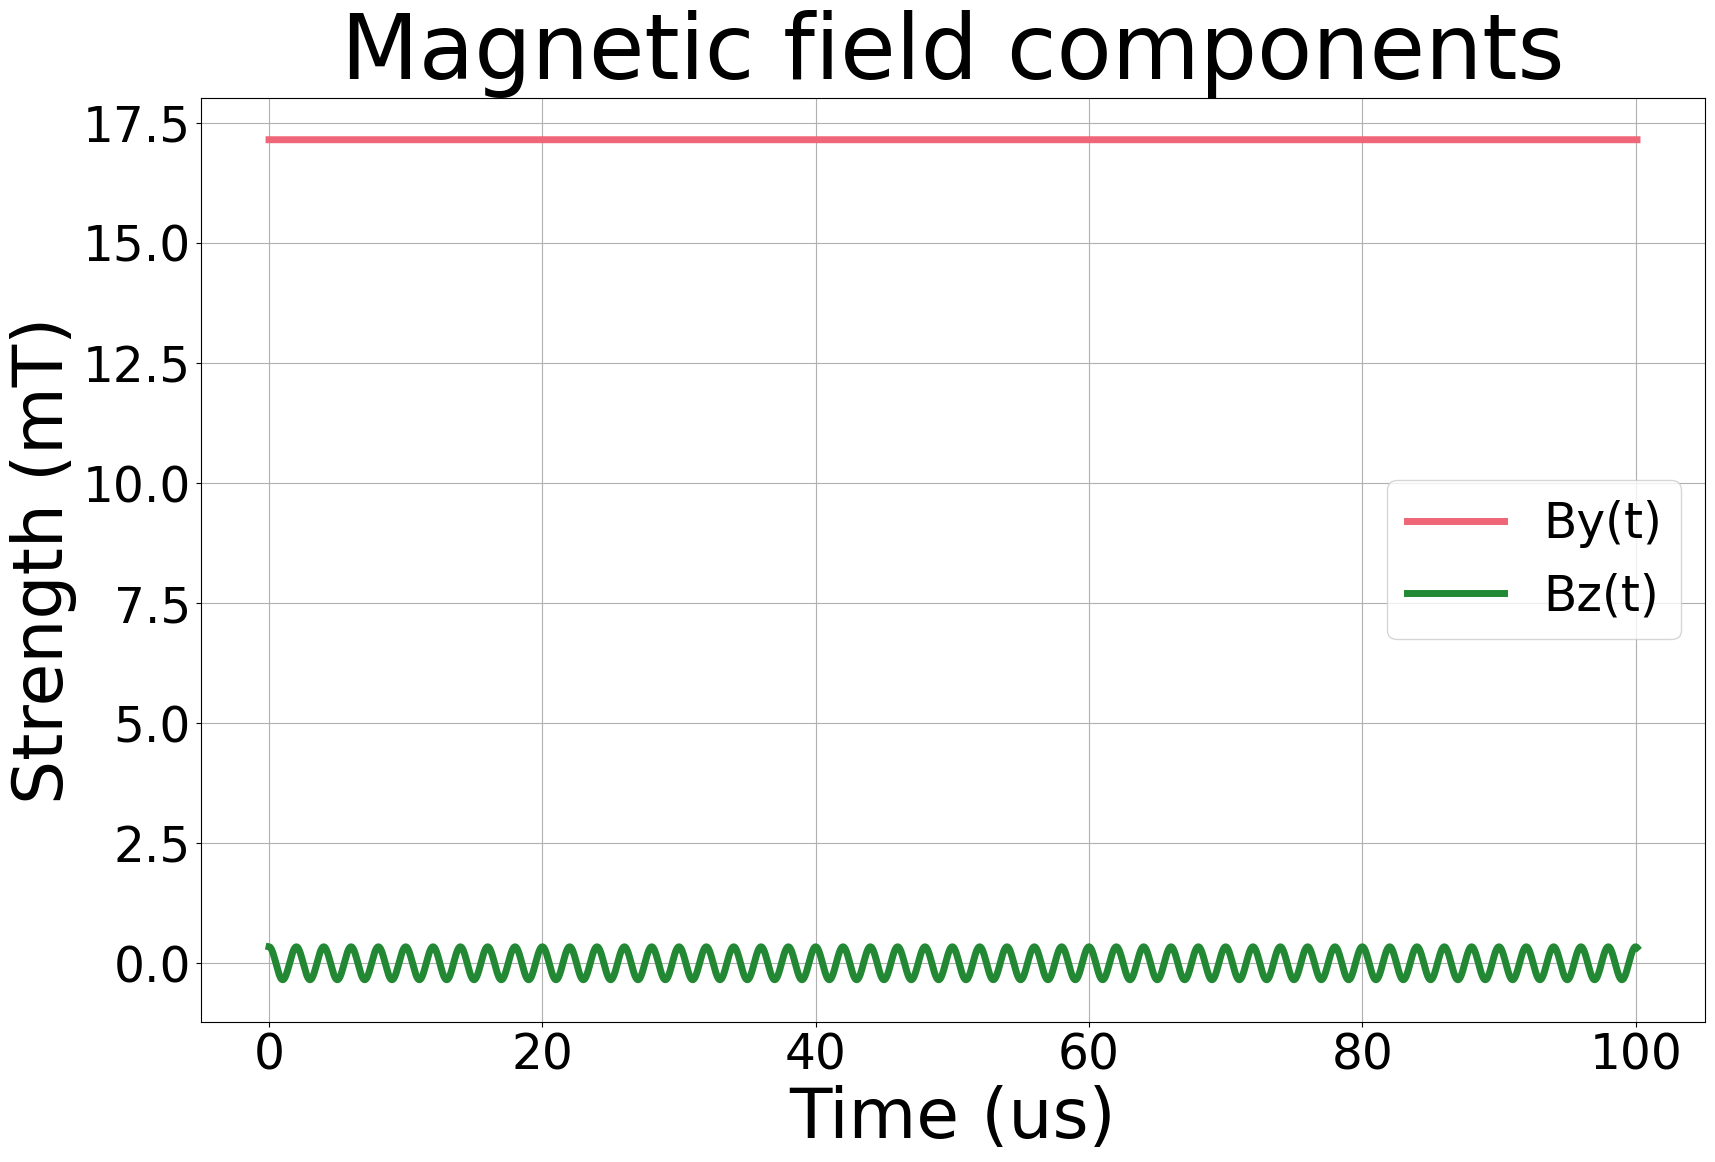

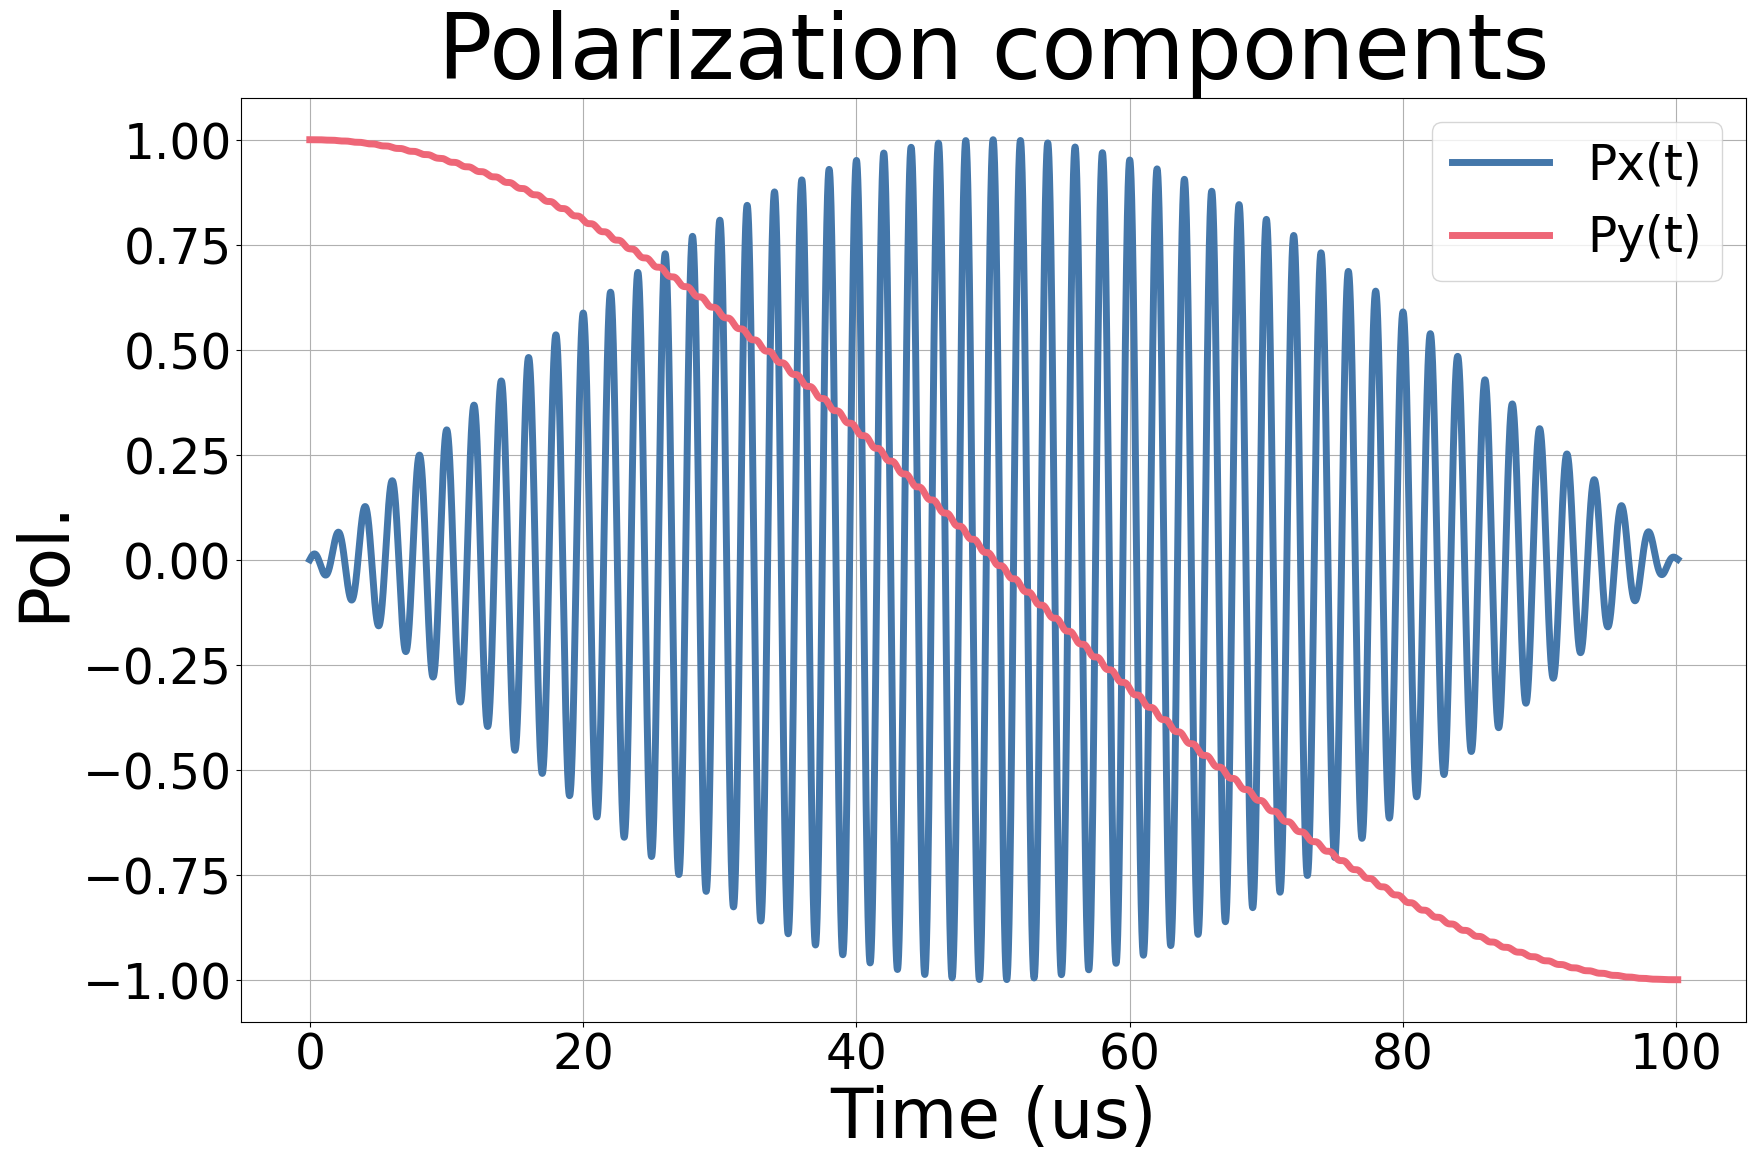

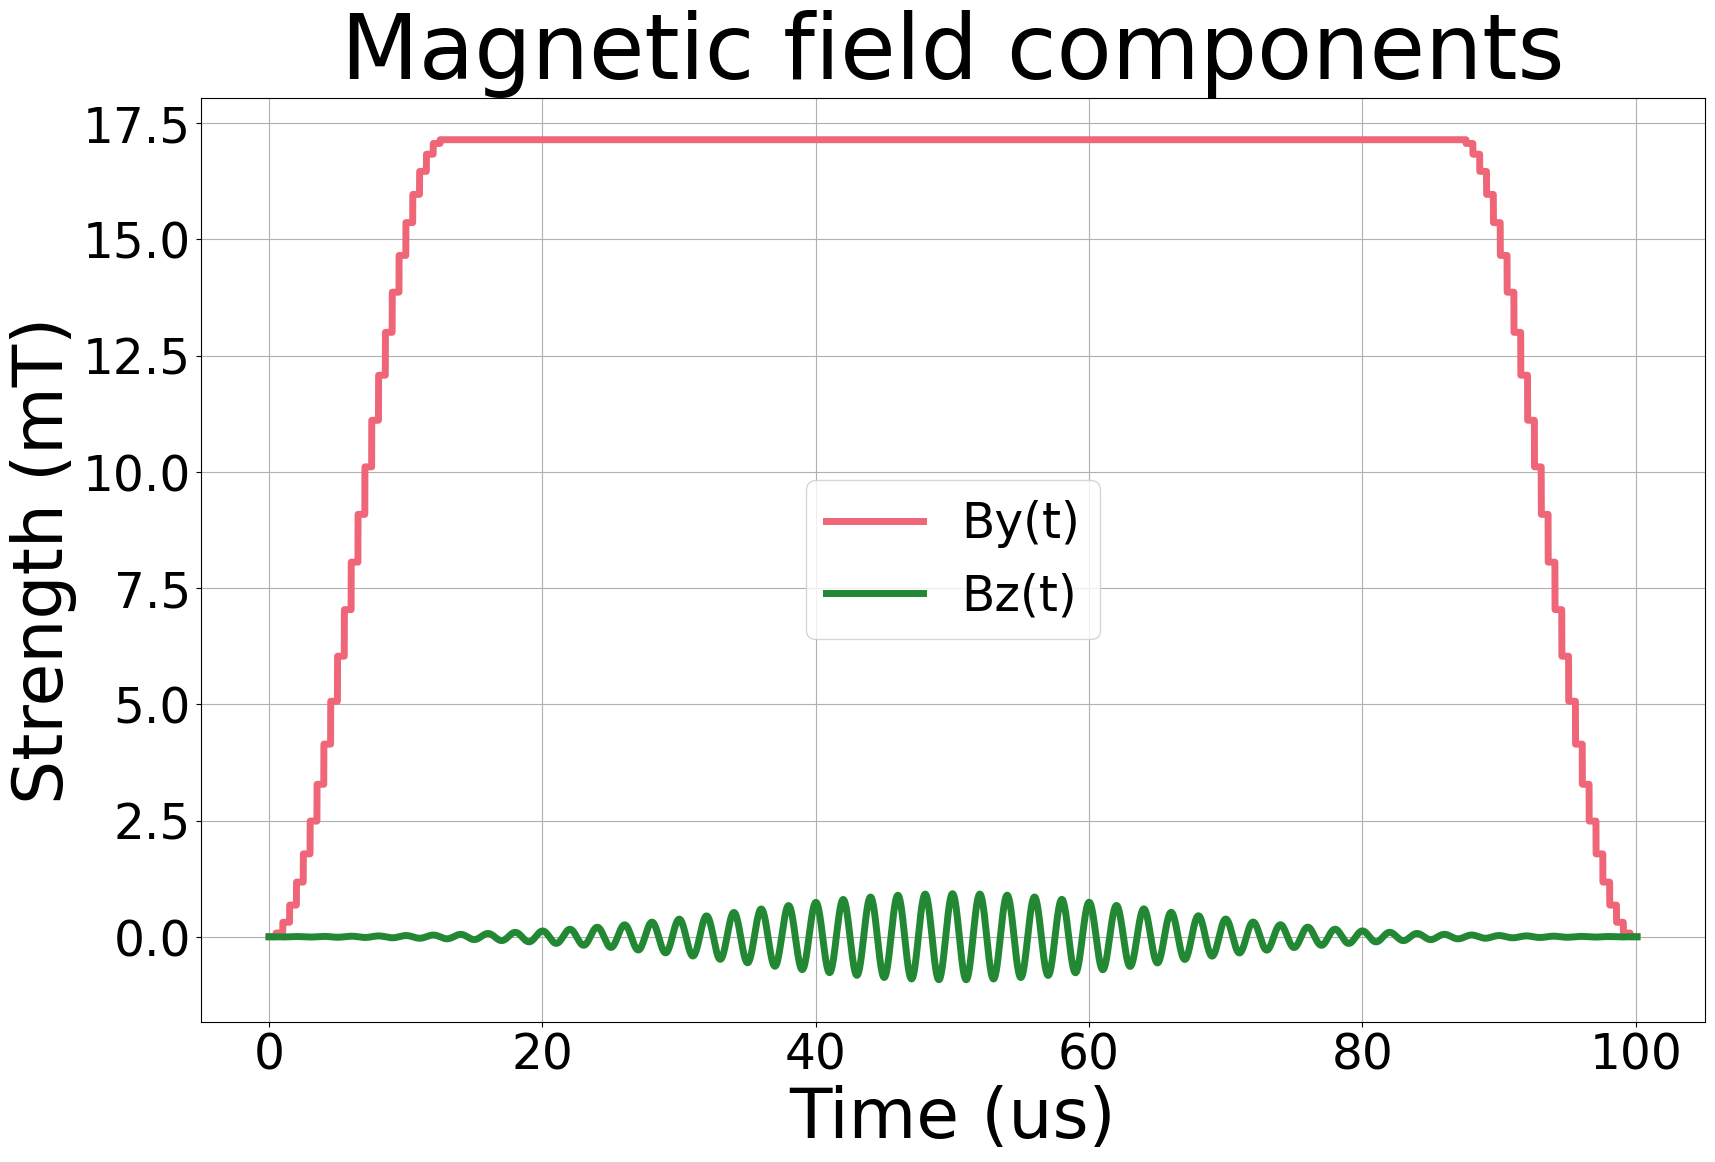

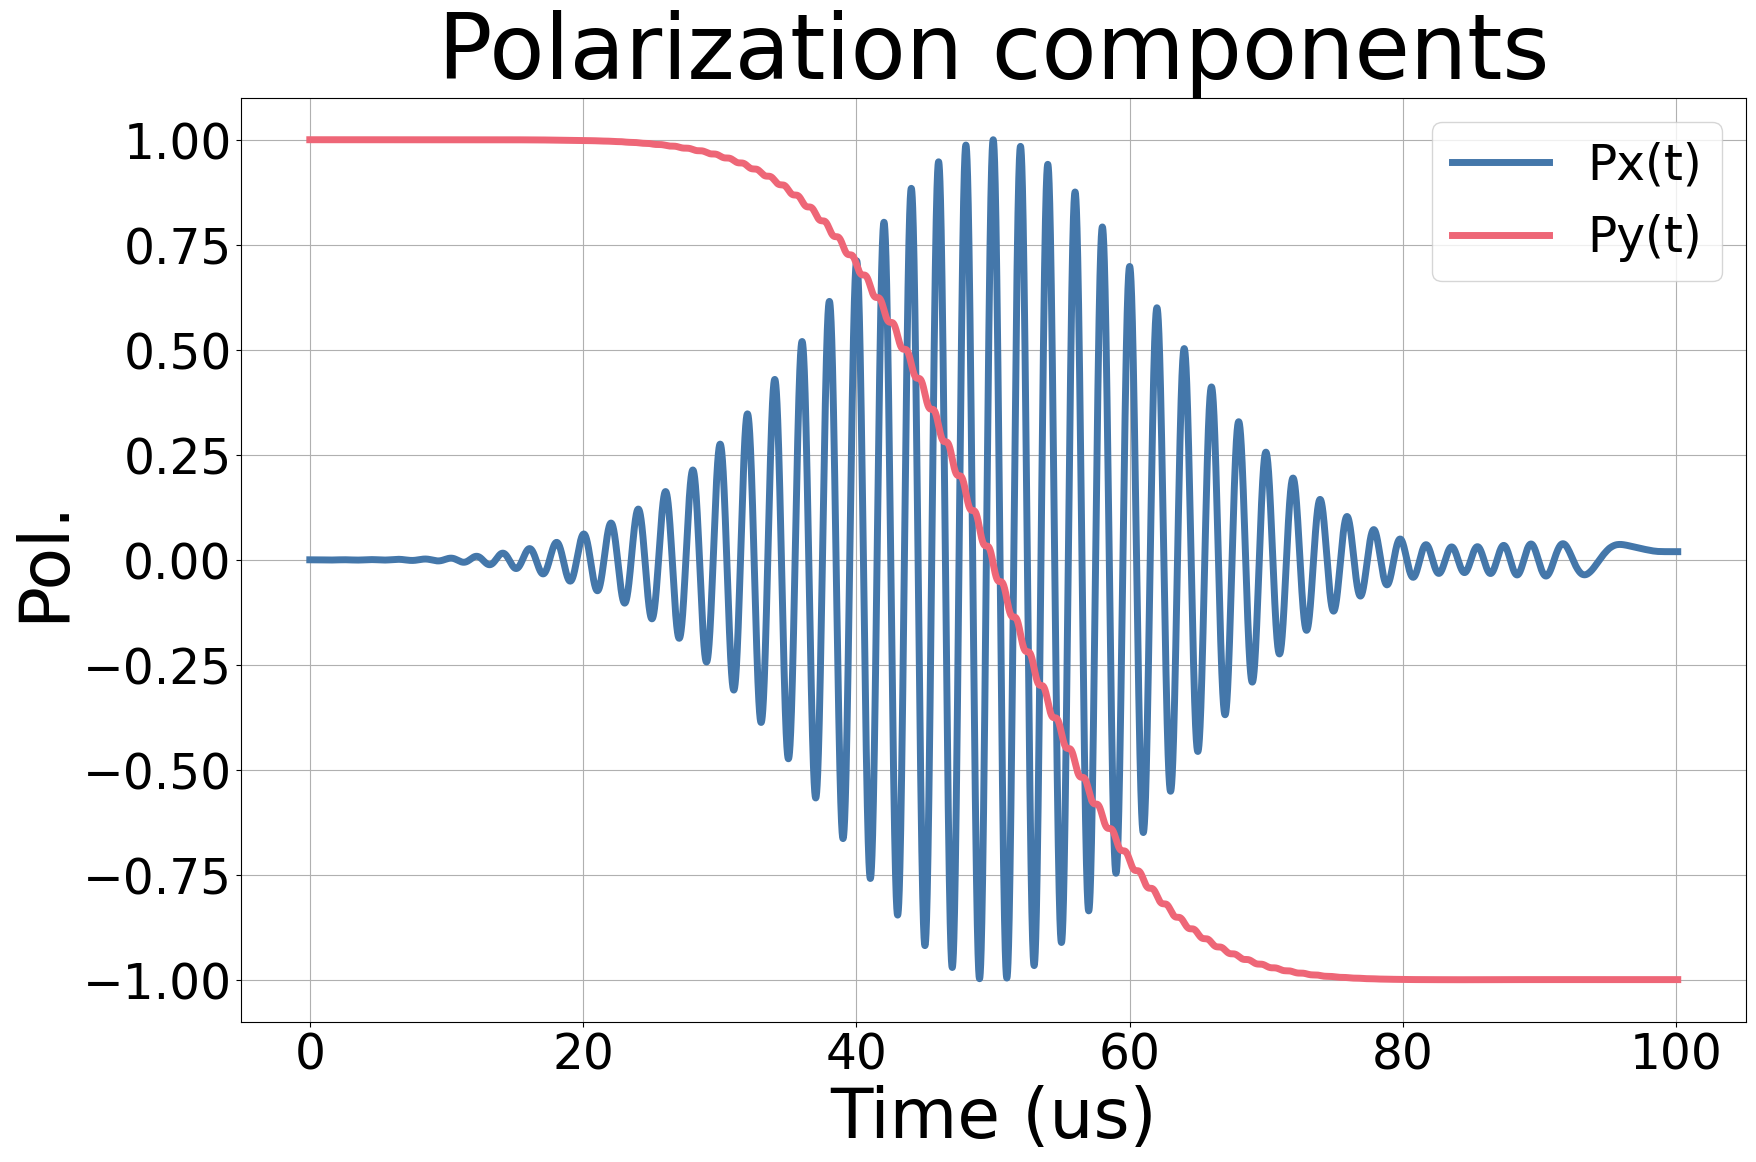

Ideal: Minimum pol:  -0.99993
Ideal: Minimum pol at t= 100.10025 

Real: Minimum pol:  -0.9996
Real: Minimum pol at t= 84.02301 

Ideal: Final pol:  -0.99993
Real: Final pol:  -0.99933


In [14]:
pols,pols2 = retuned_compare(new_b0,new_amp,new_freq,plot_pol=True,plot_bt=True)

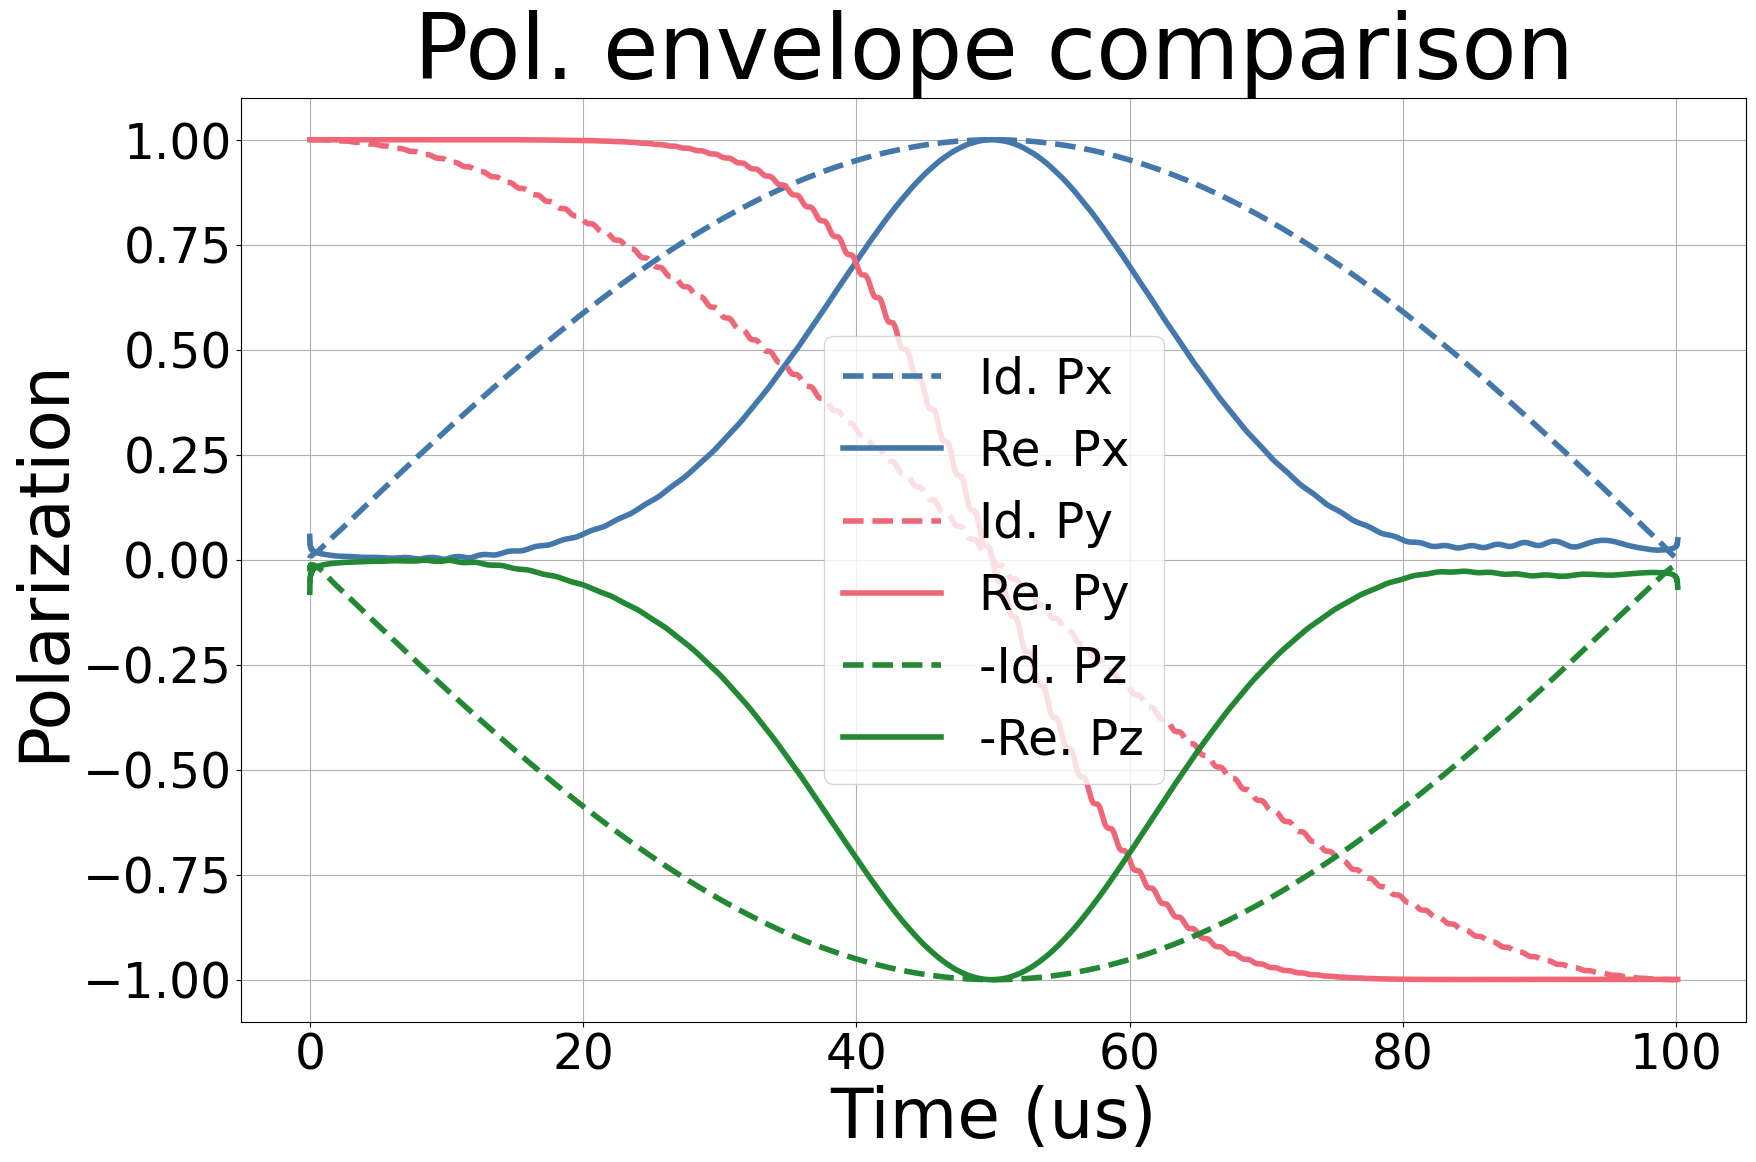

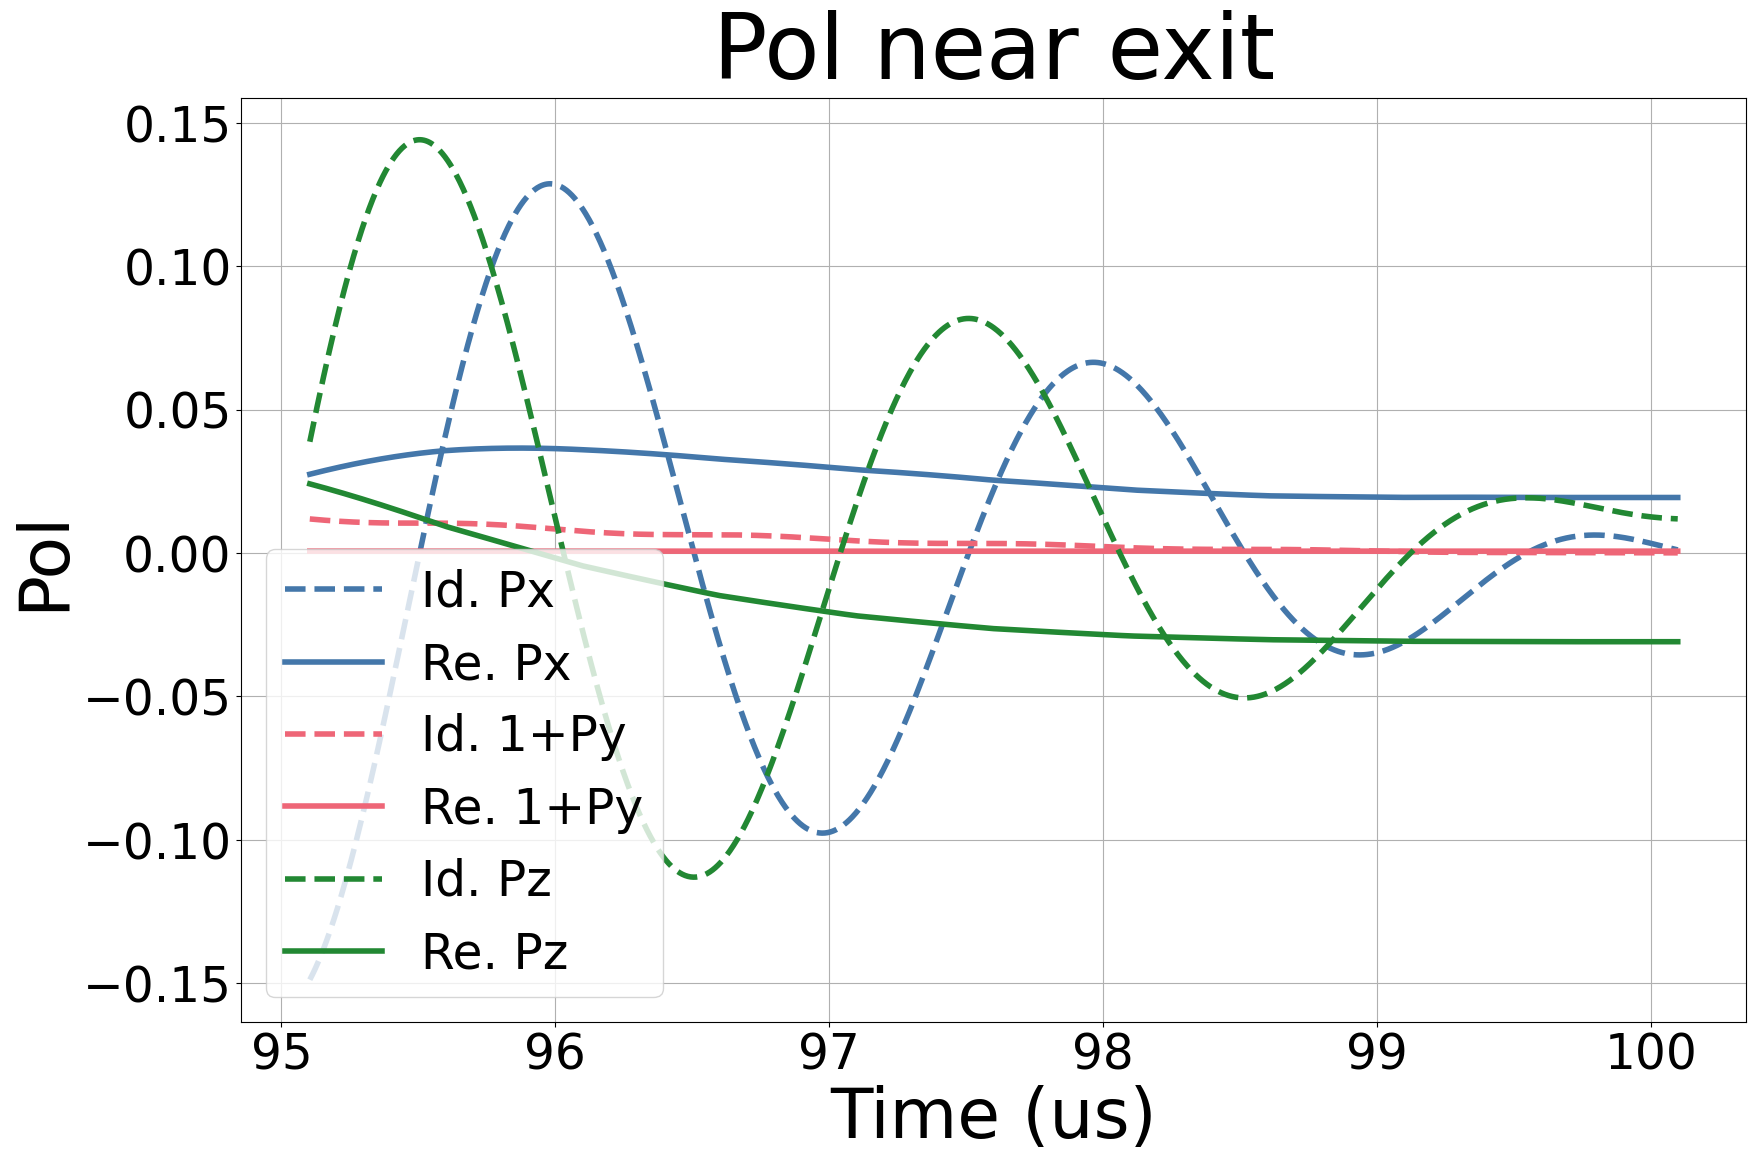

Real pol. norm check:  [ 0.01937705 -0.99933409 -0.03091788] -> 1.0000000000000204


In [16]:
get_envelope(pols,pols2,s=0,e=-1,plot=True)
do_stability_check(pols,pols2,s=-1500,e=-1,plot_near_min=False,plot_near_exit=True)

***
# Retuning for 500 kHz with real amplitude and static fields:
***

Min pol of  0.3818829433151545  at RF freq  499.99999999999994


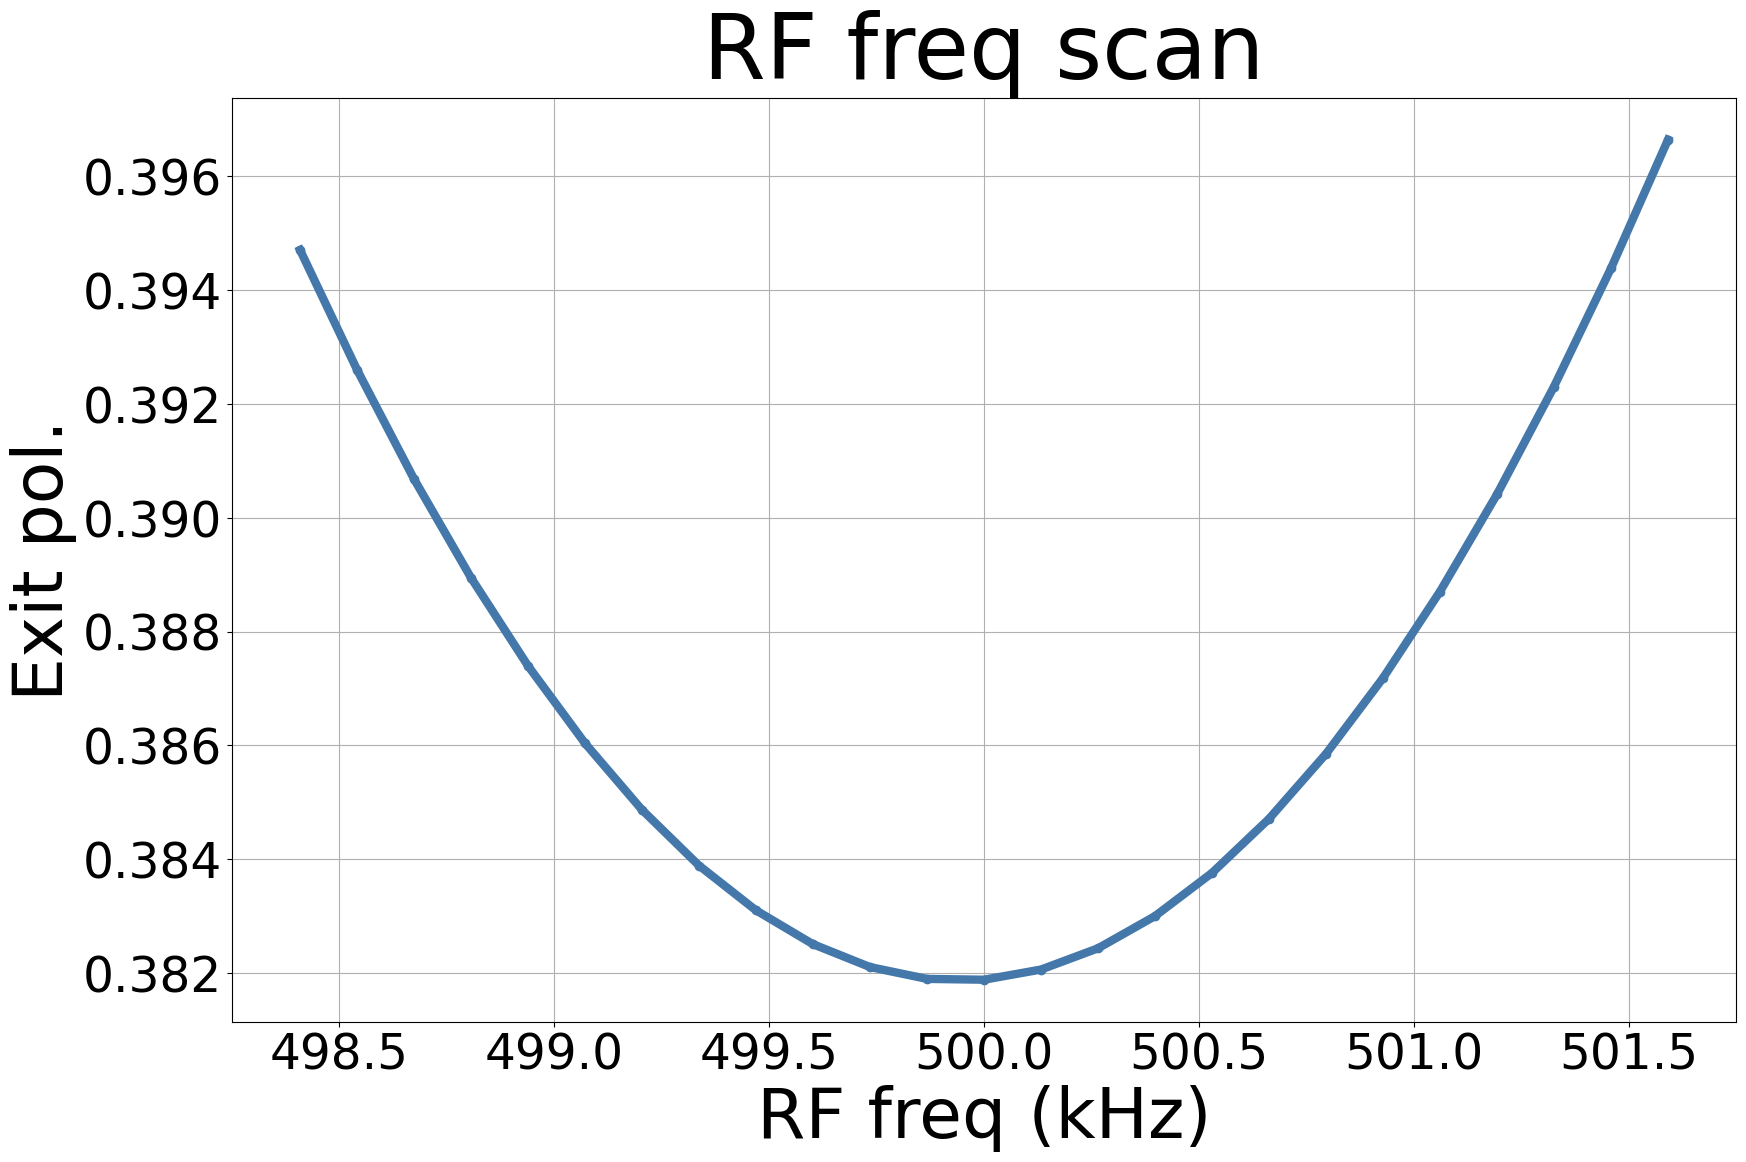

Min pol of  -0.9989838599272785  at RF amp  0.9258702842793349


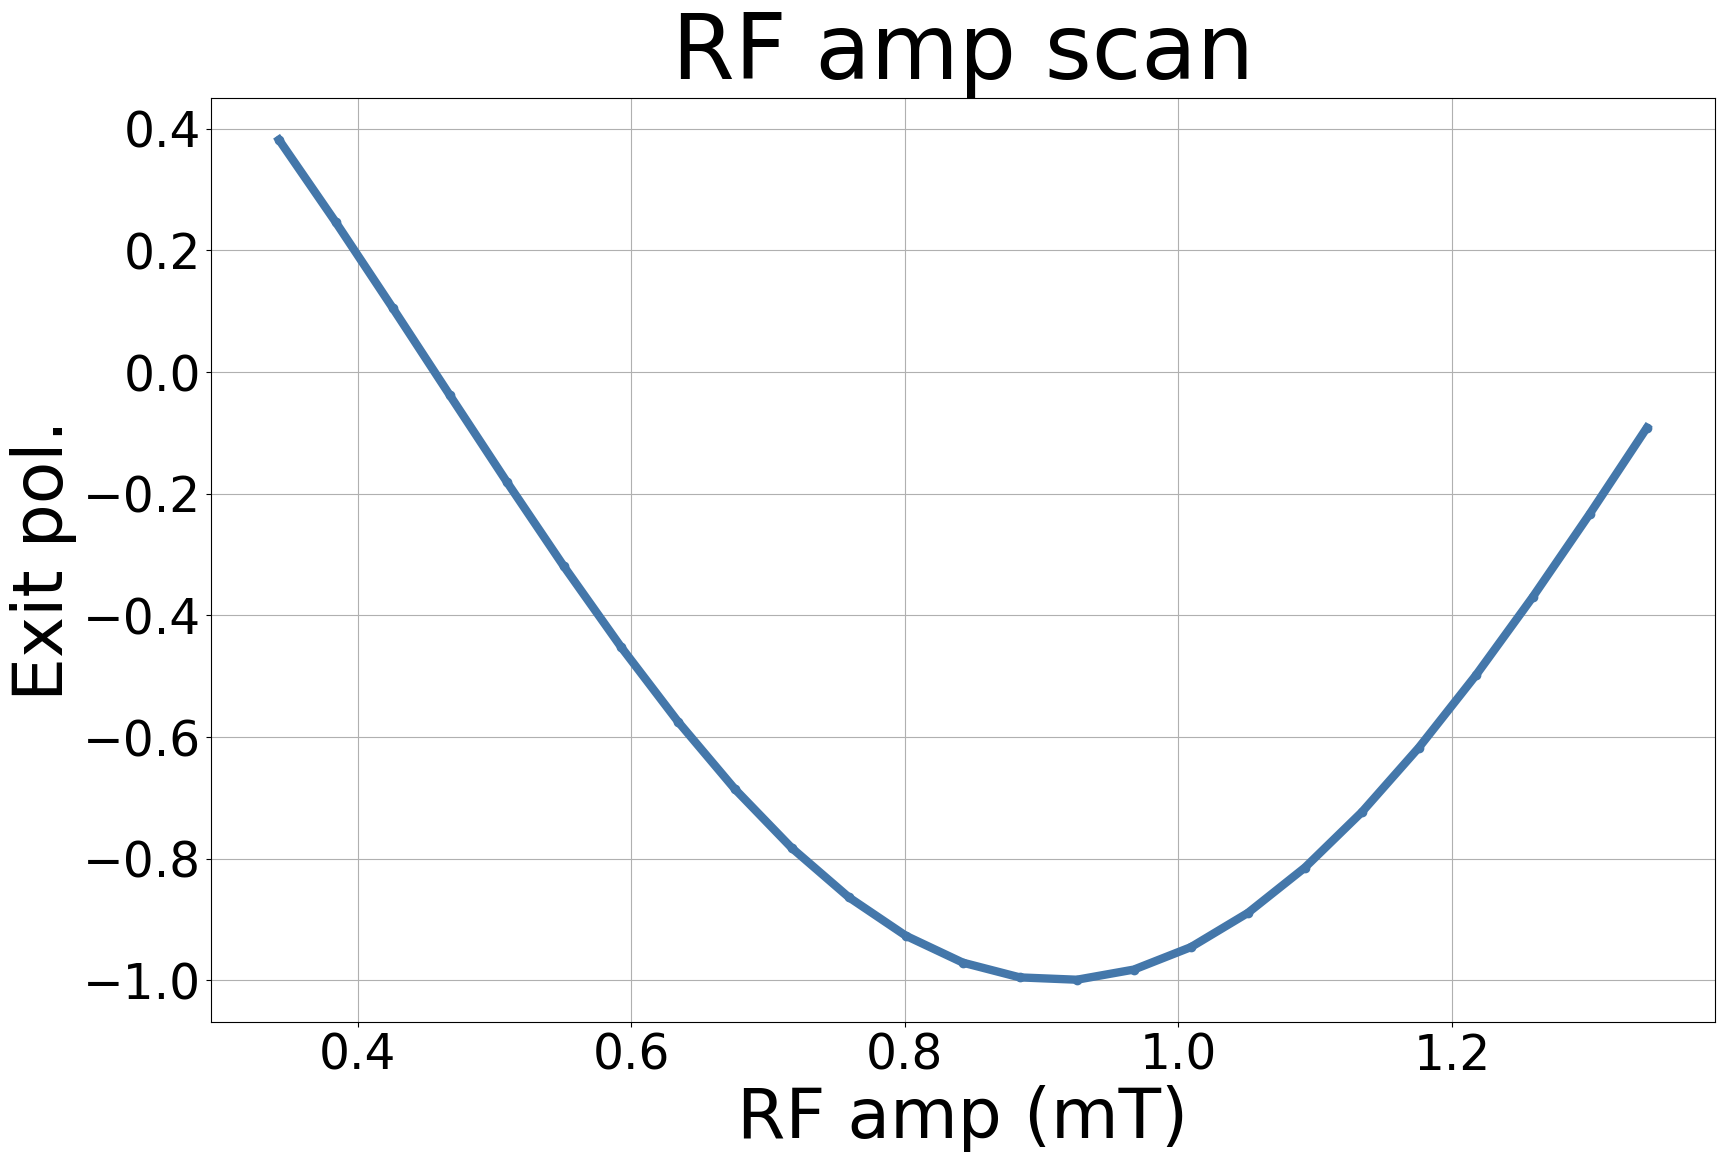

Comparison: 

Ideal: Min pol of  -0.9999285097726283  at b0  17.144017211538795
Real: Min pol of  -0.9989838599272785  at b0  17.144017211538795


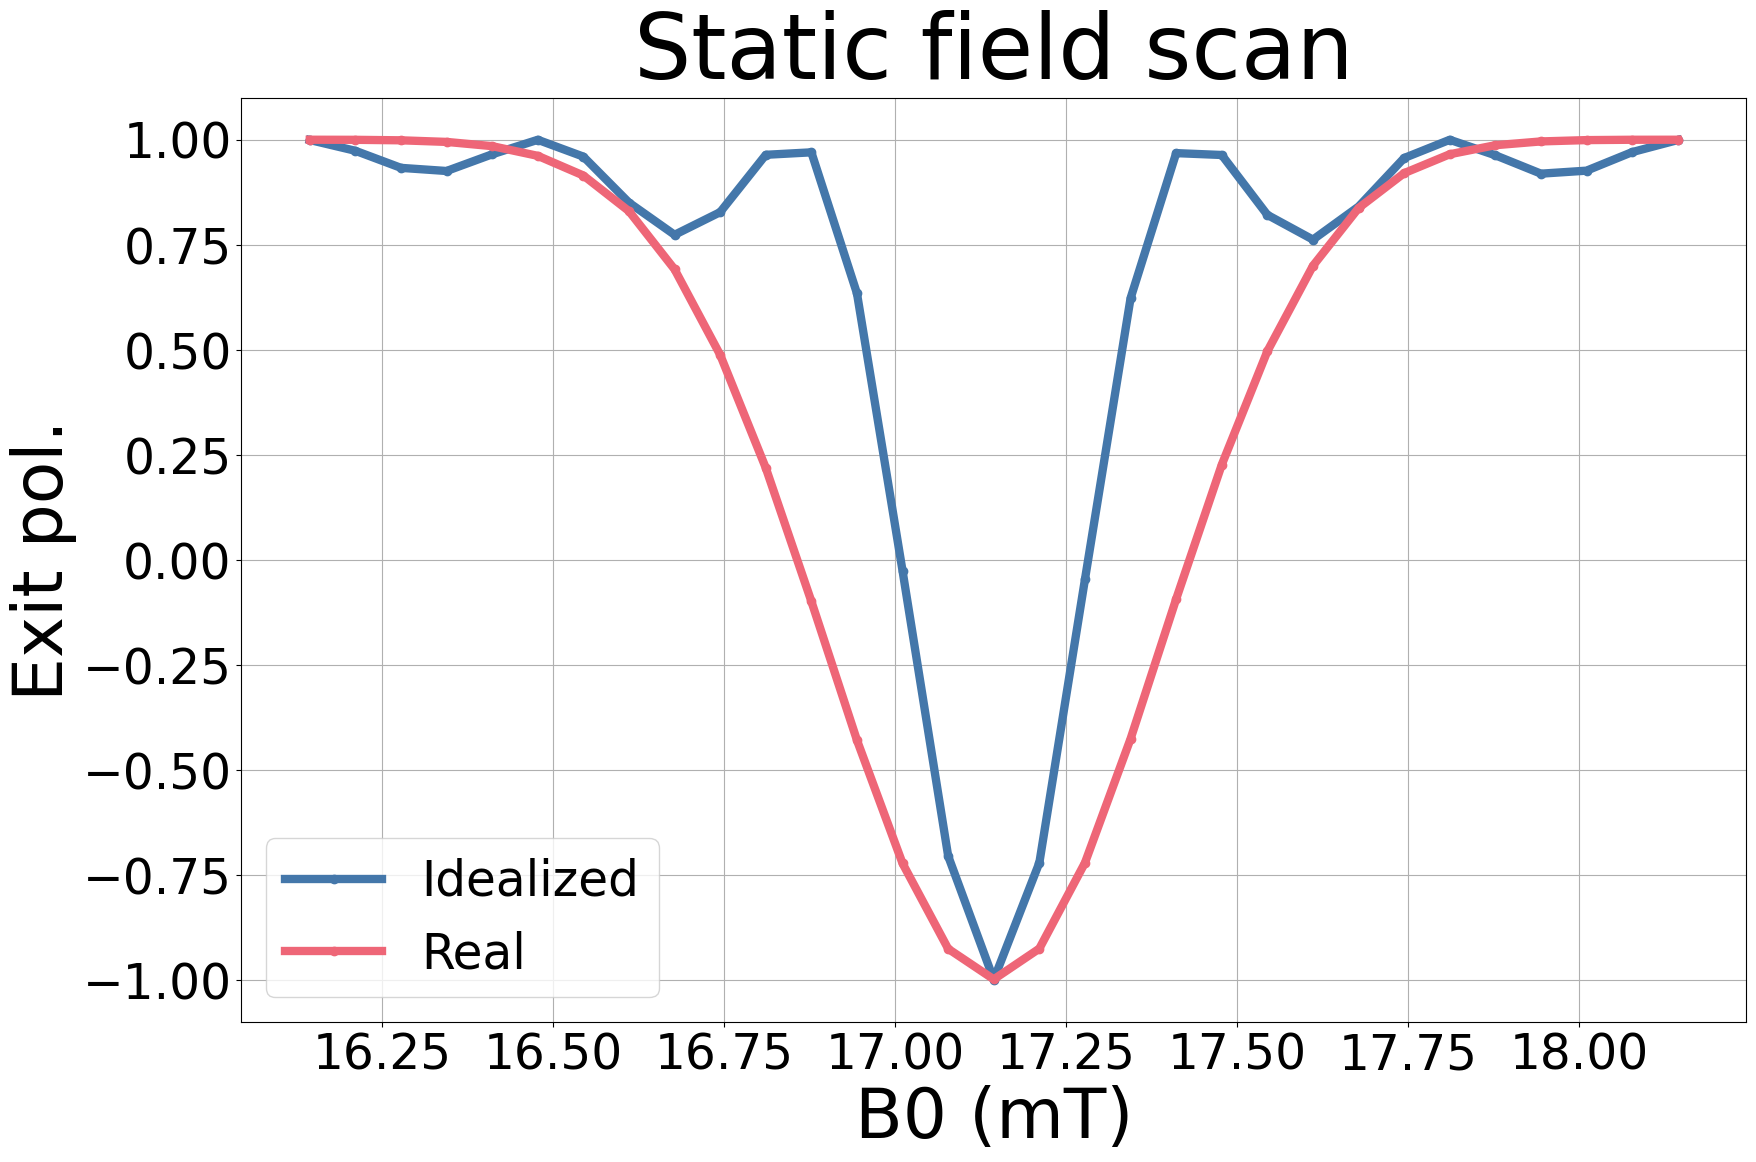

In [8]:
new_freq = get_new_freq(rf_freq-1e-2,rf_freq+1e-2,25,real_static=True,real_amp=True)
new_amp = get_new_amp(rf_amp,rf_amp+1,25,real_static=True,real_amp=True,plot=True)
new_b0 = compare_b0(b_0-1,b_0+1,31,new_amp,new_freq,real_static=True,real_amp=True,plot=False)

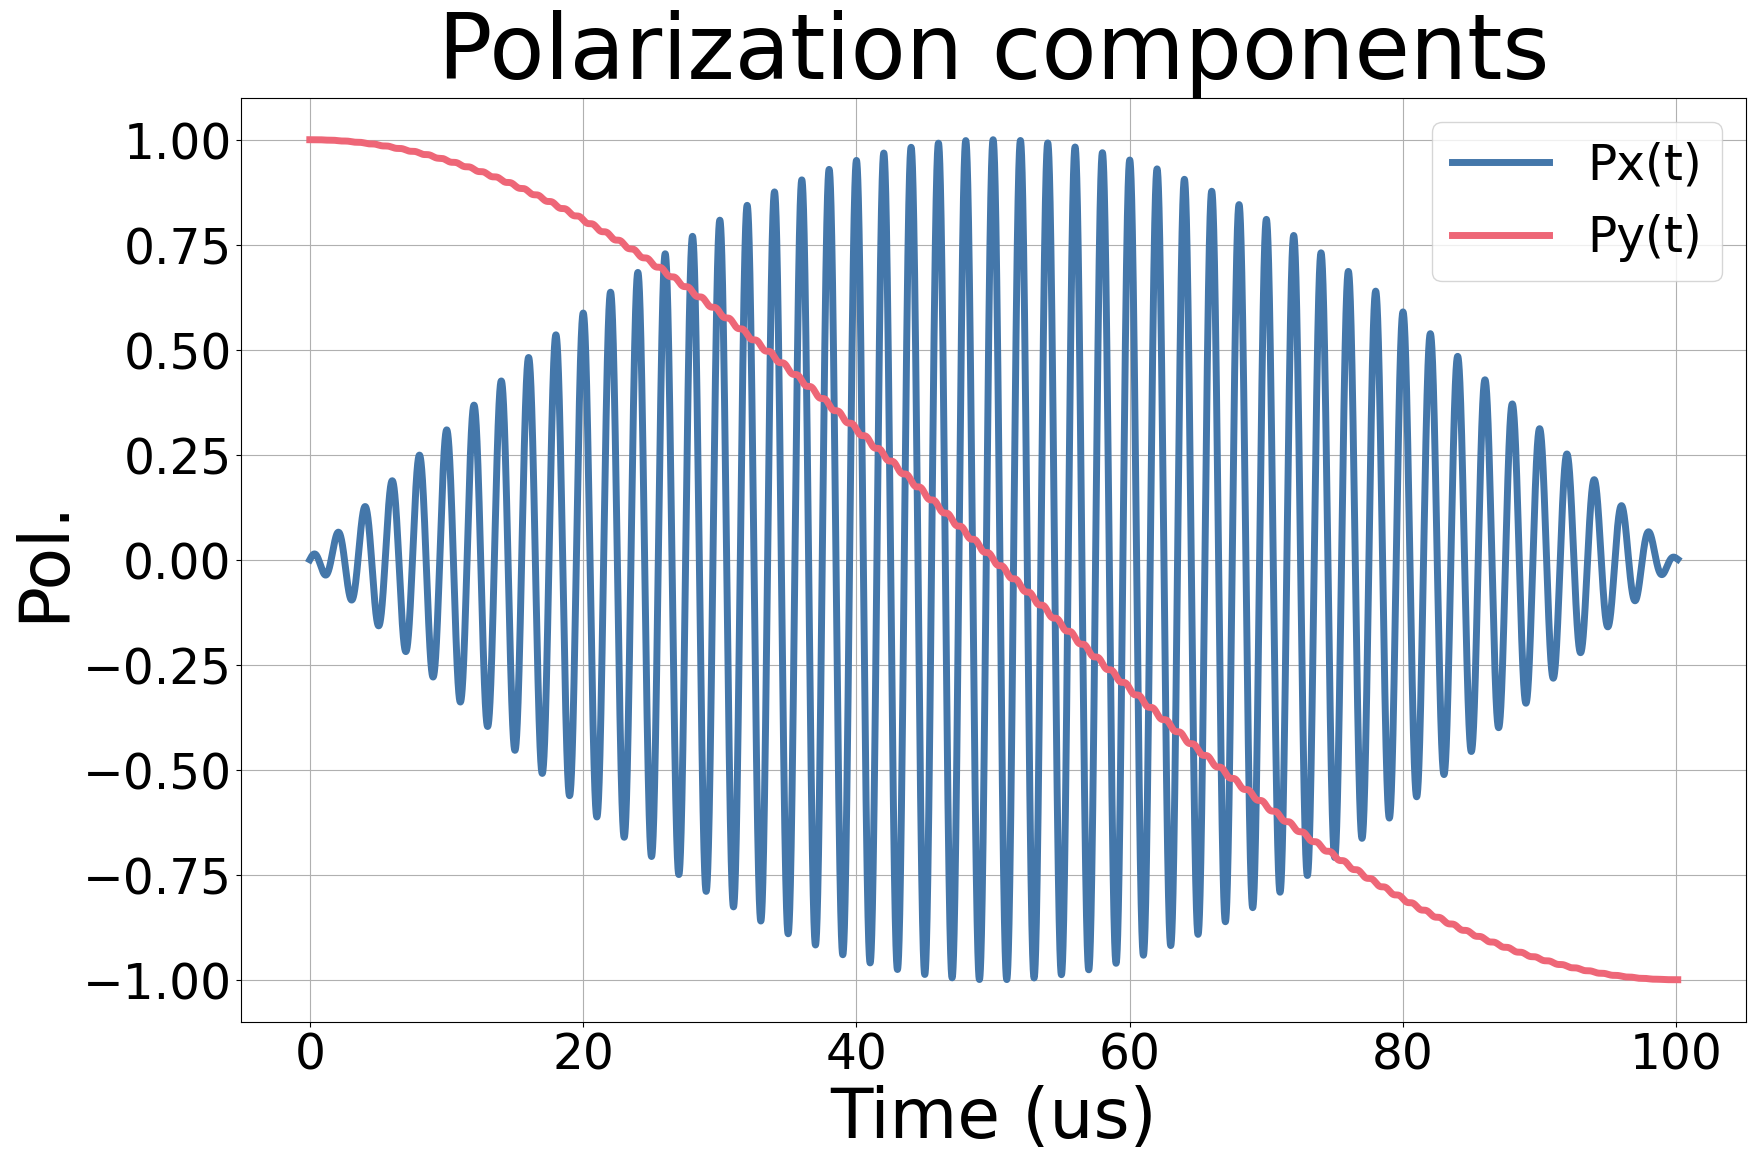

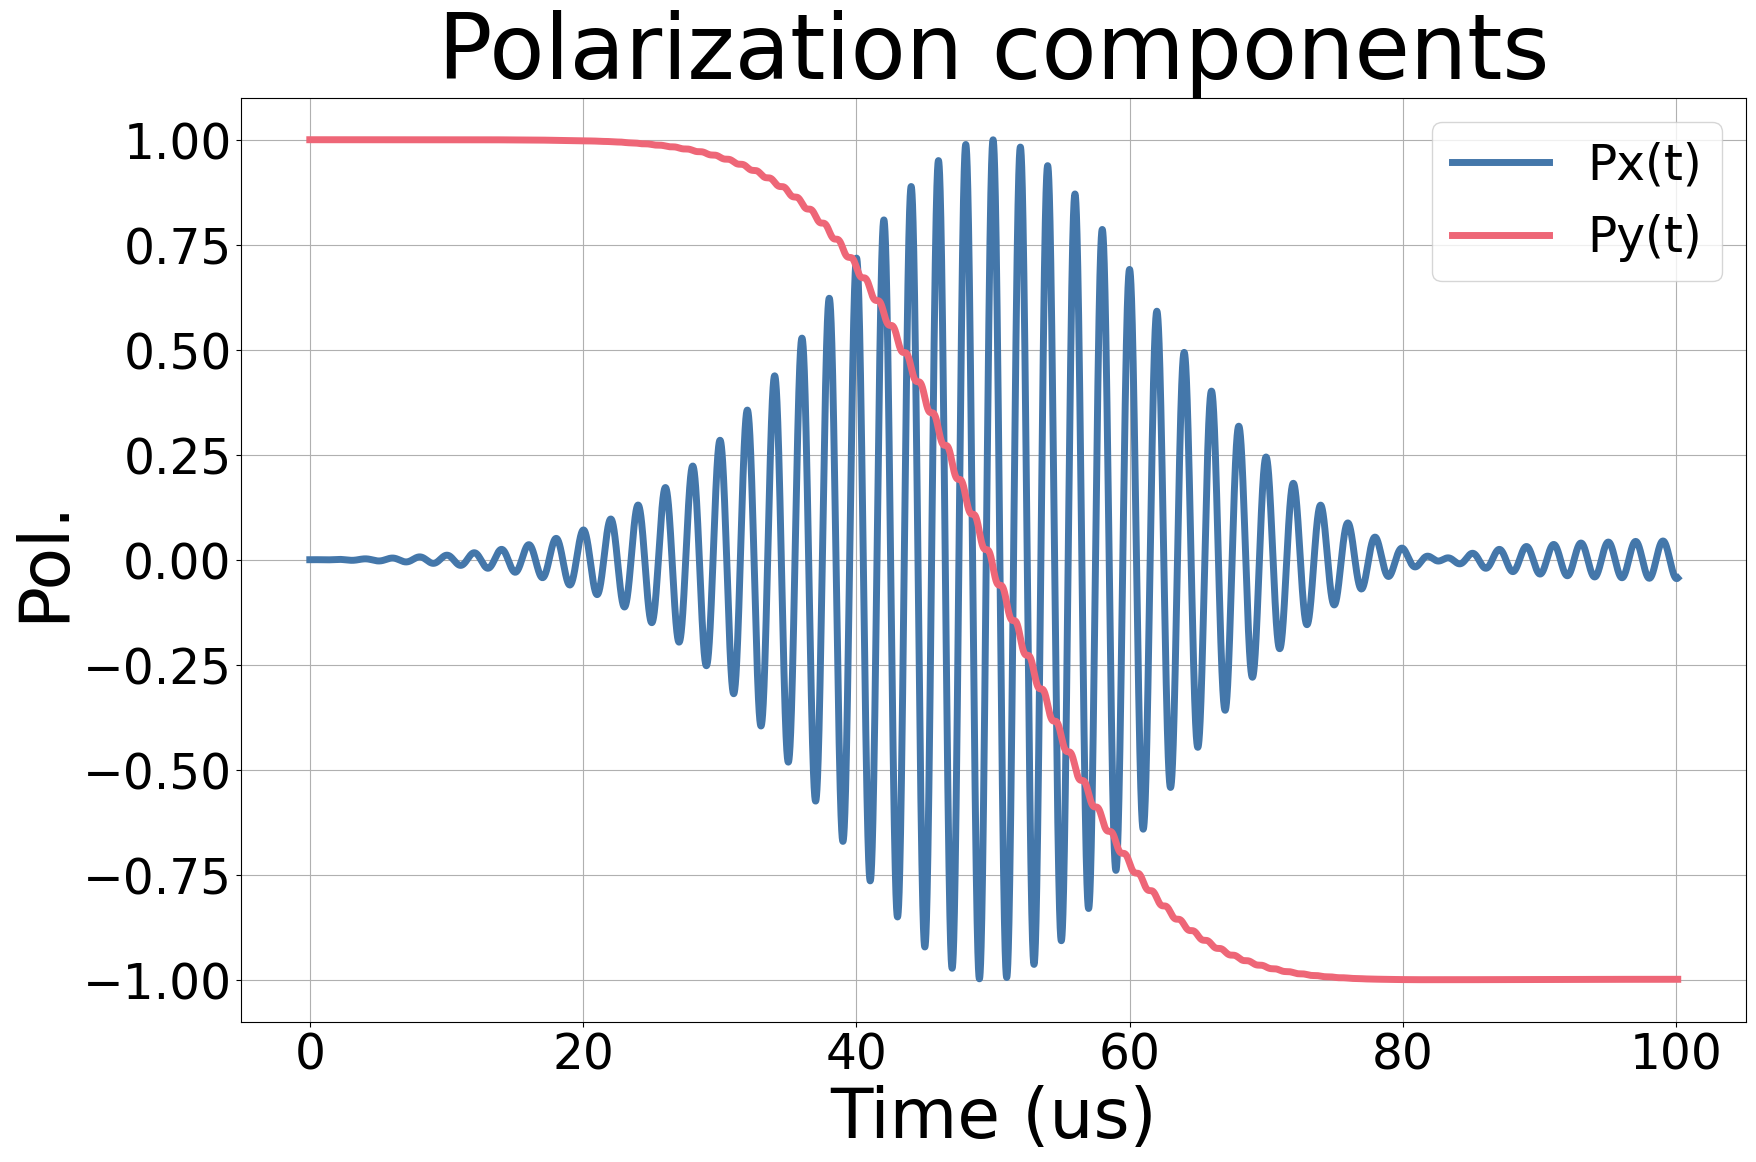

Ideal: Minimum pol:  -0.99993
Ideal: Minimum pol at t= 100.10025 

Real: Minimum pol:  -1.0
Real: Minimum pol at t= 82.89963 

Ideal: Final pol:  -0.99993
Real: Final pol:  -0.99898


In [9]:
pols,pols2 = retuned_compare(new_b0,new_amp,new_freq,plot_pol=True,plot_bt=False)

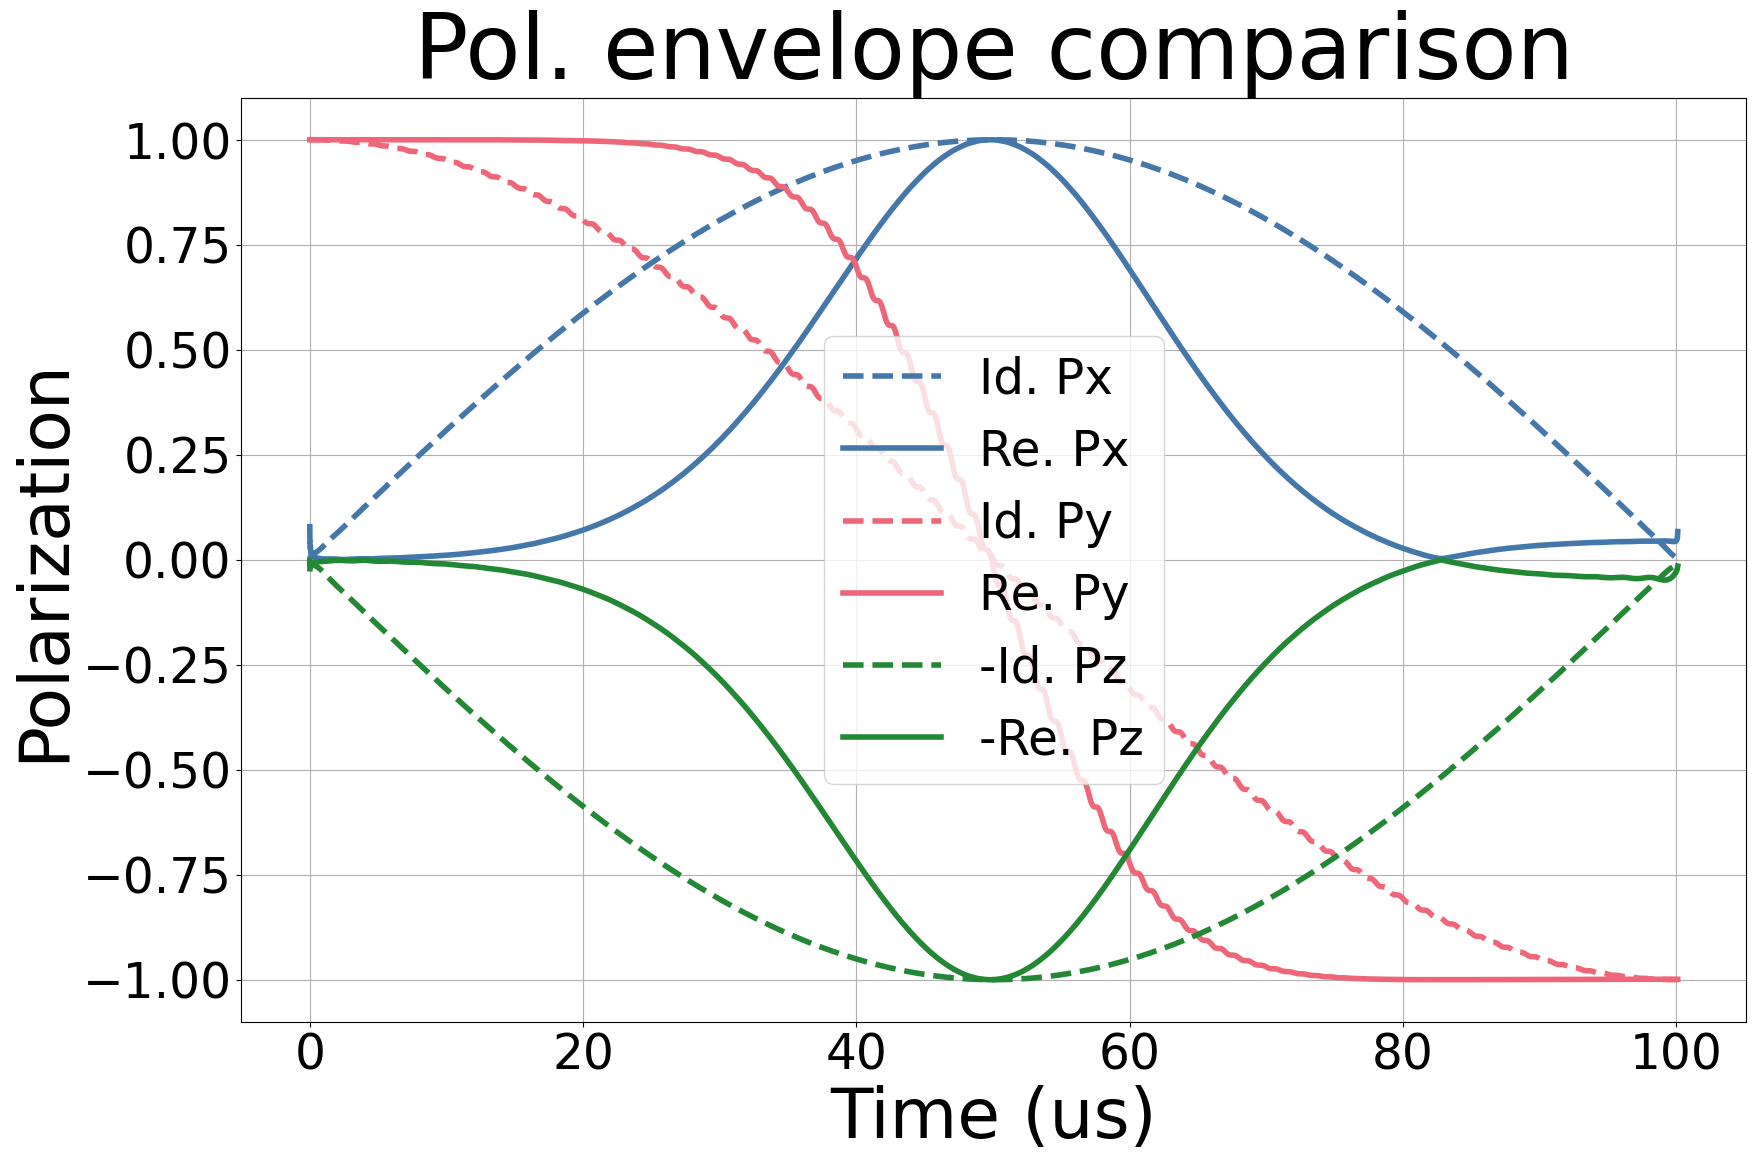

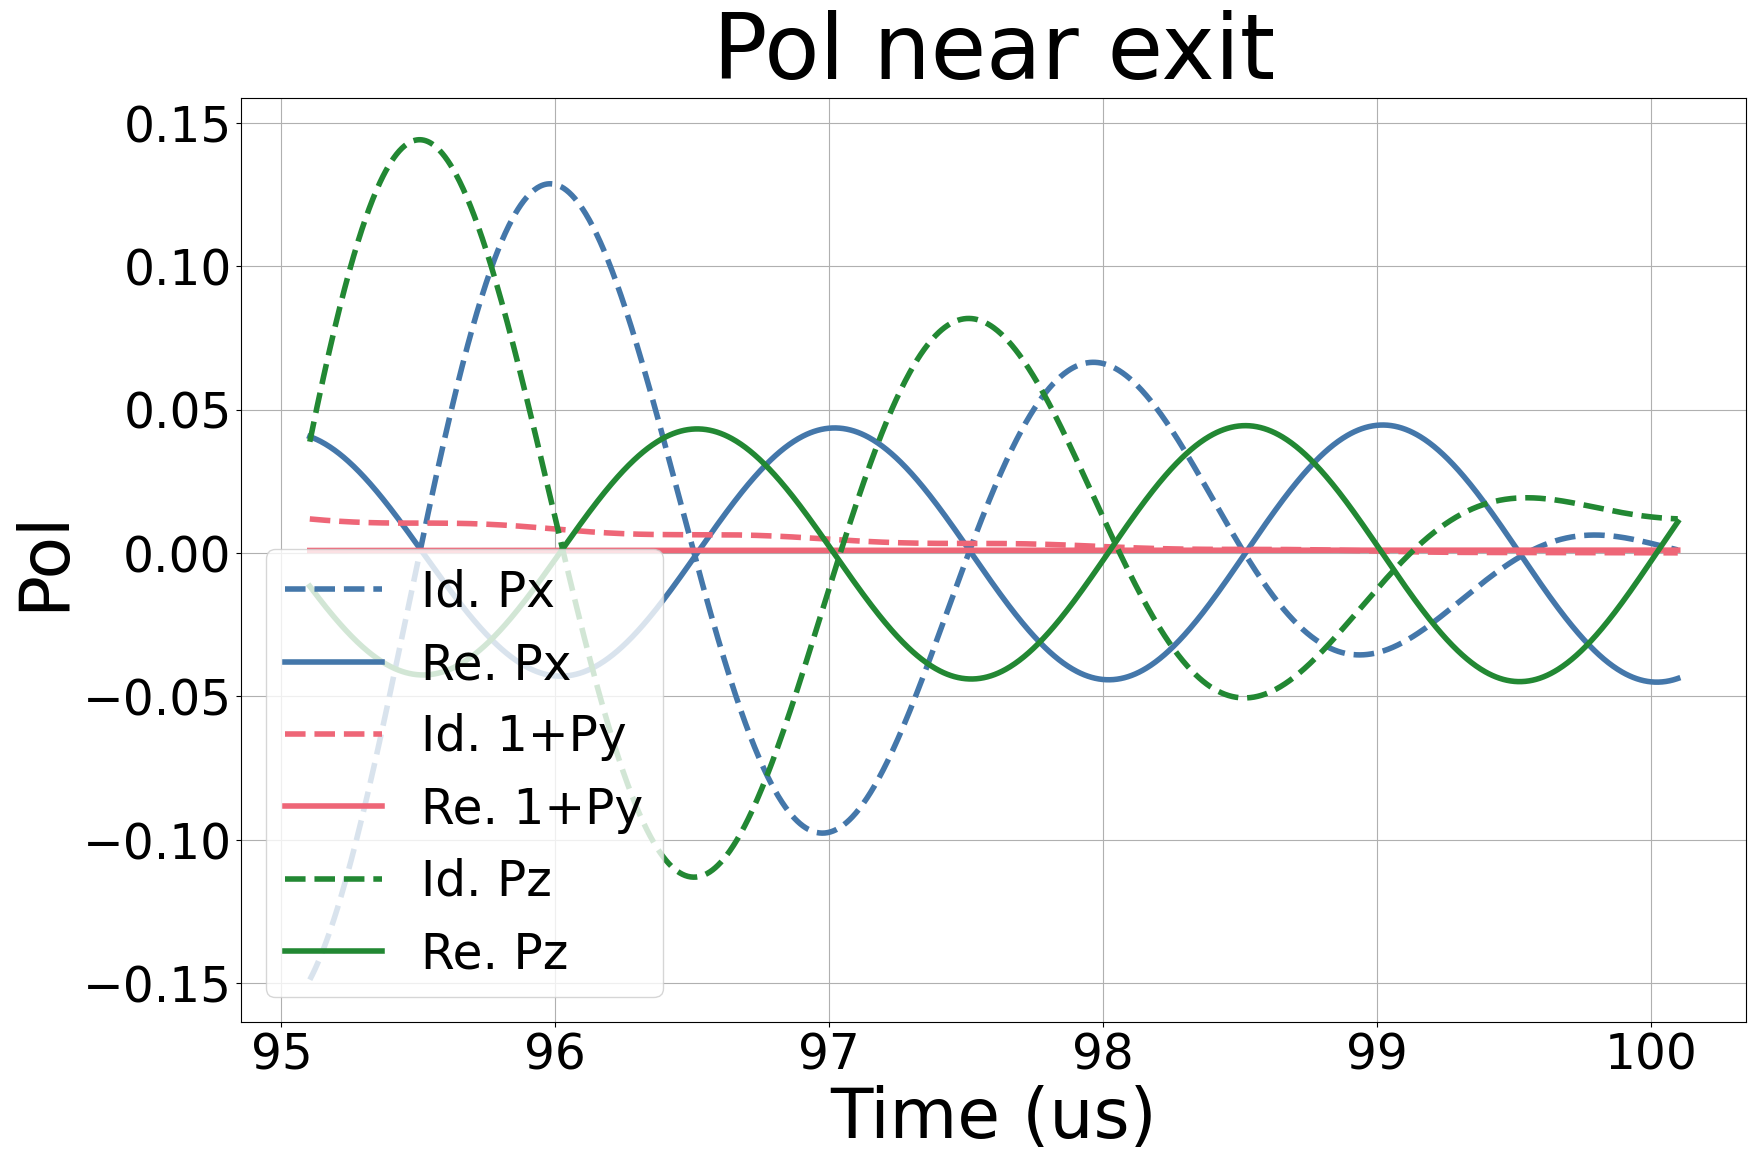

Real pol. norm check:  [-0.04362464 -0.99898386  0.01131982] -> 1.0000000000001468


In [12]:
get_envelope(pols,pols2,s=0,e=-1,plot=True)
do_stability_check(pols,pols2,s=-1500,e=-1,plot_near_min=False,plot_near_exit=True)

***
# Retuning for 1.5 MHz with real amplitude and static fields:
***

Min pol of  0.3818923237866483  at RF freq  1499.8673708807569


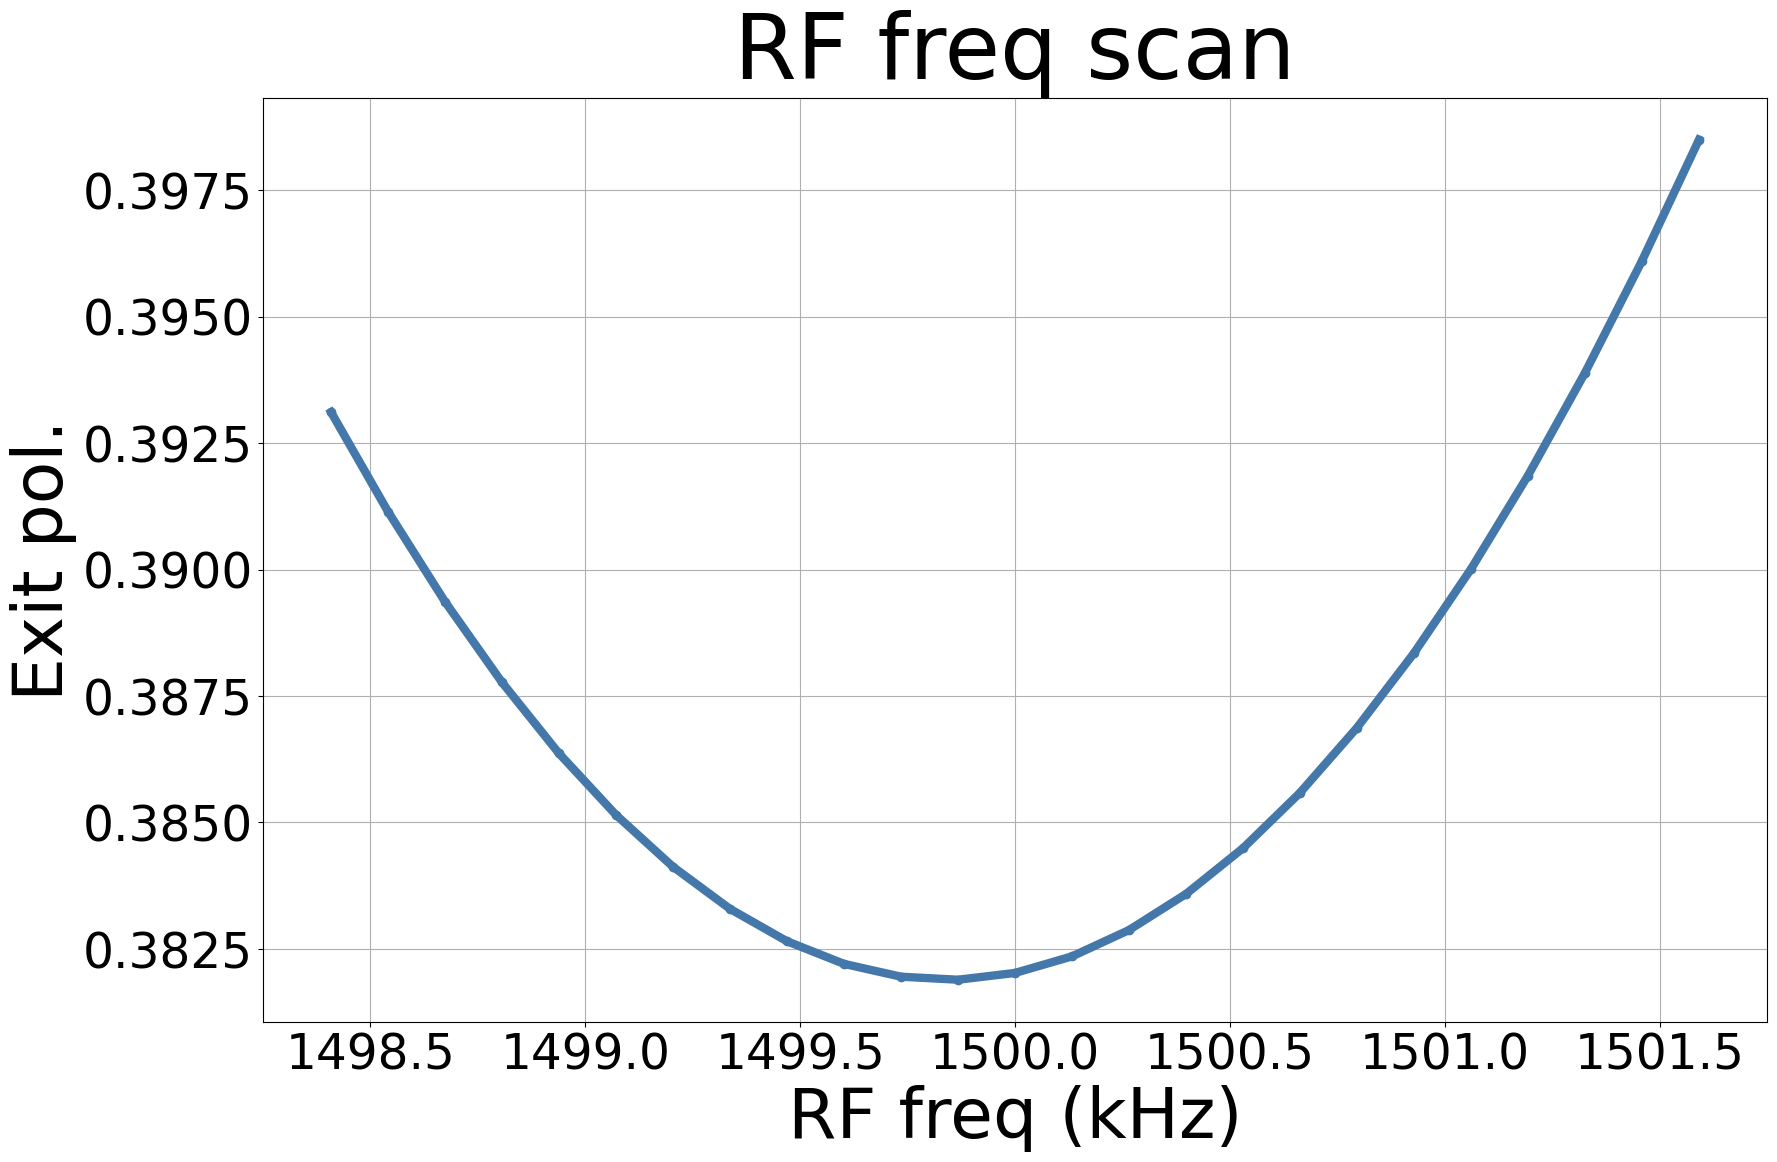

Min pol of  -0.9987366862940938  at RF amp  0.9258702842793349


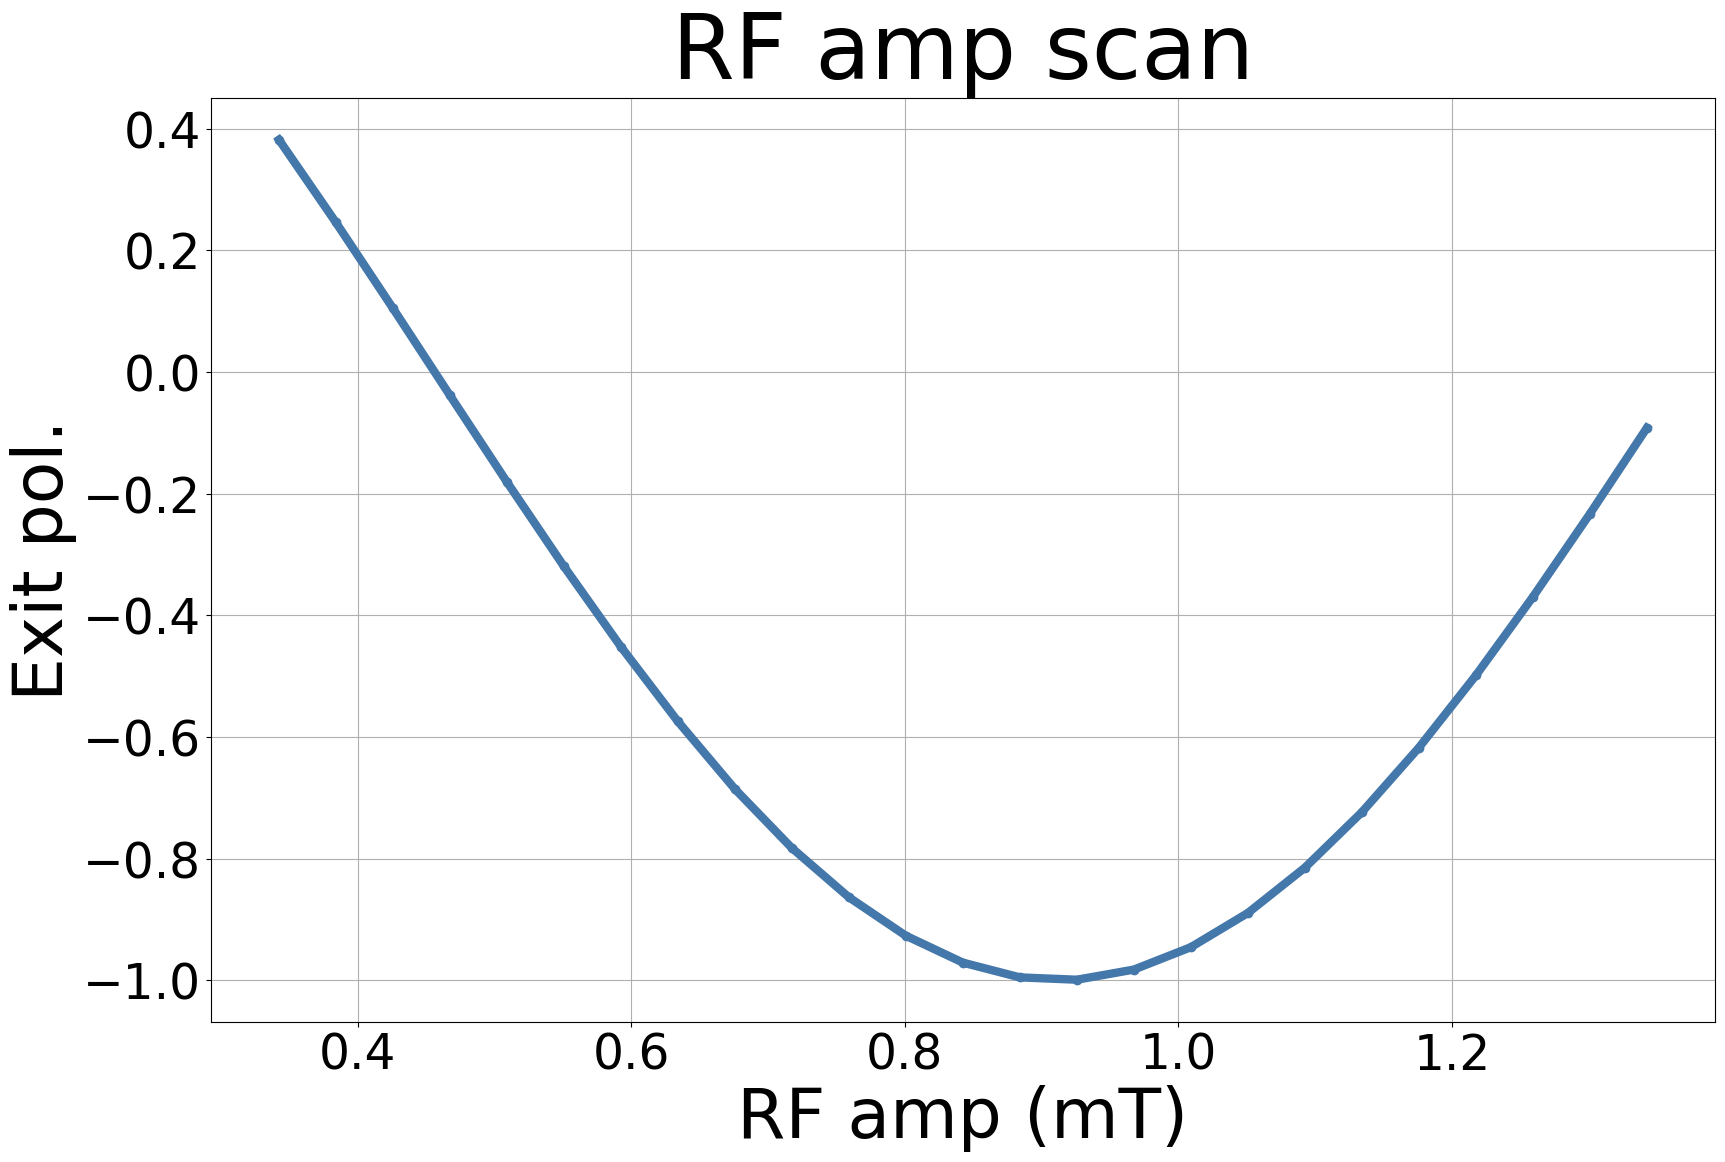

Comparison: 

Ideal: Min pol of  -0.9999583480681954  at b0  51.432051634616386
Real: Min pol of  -0.9989768755055108  at b0  51.432051634616386


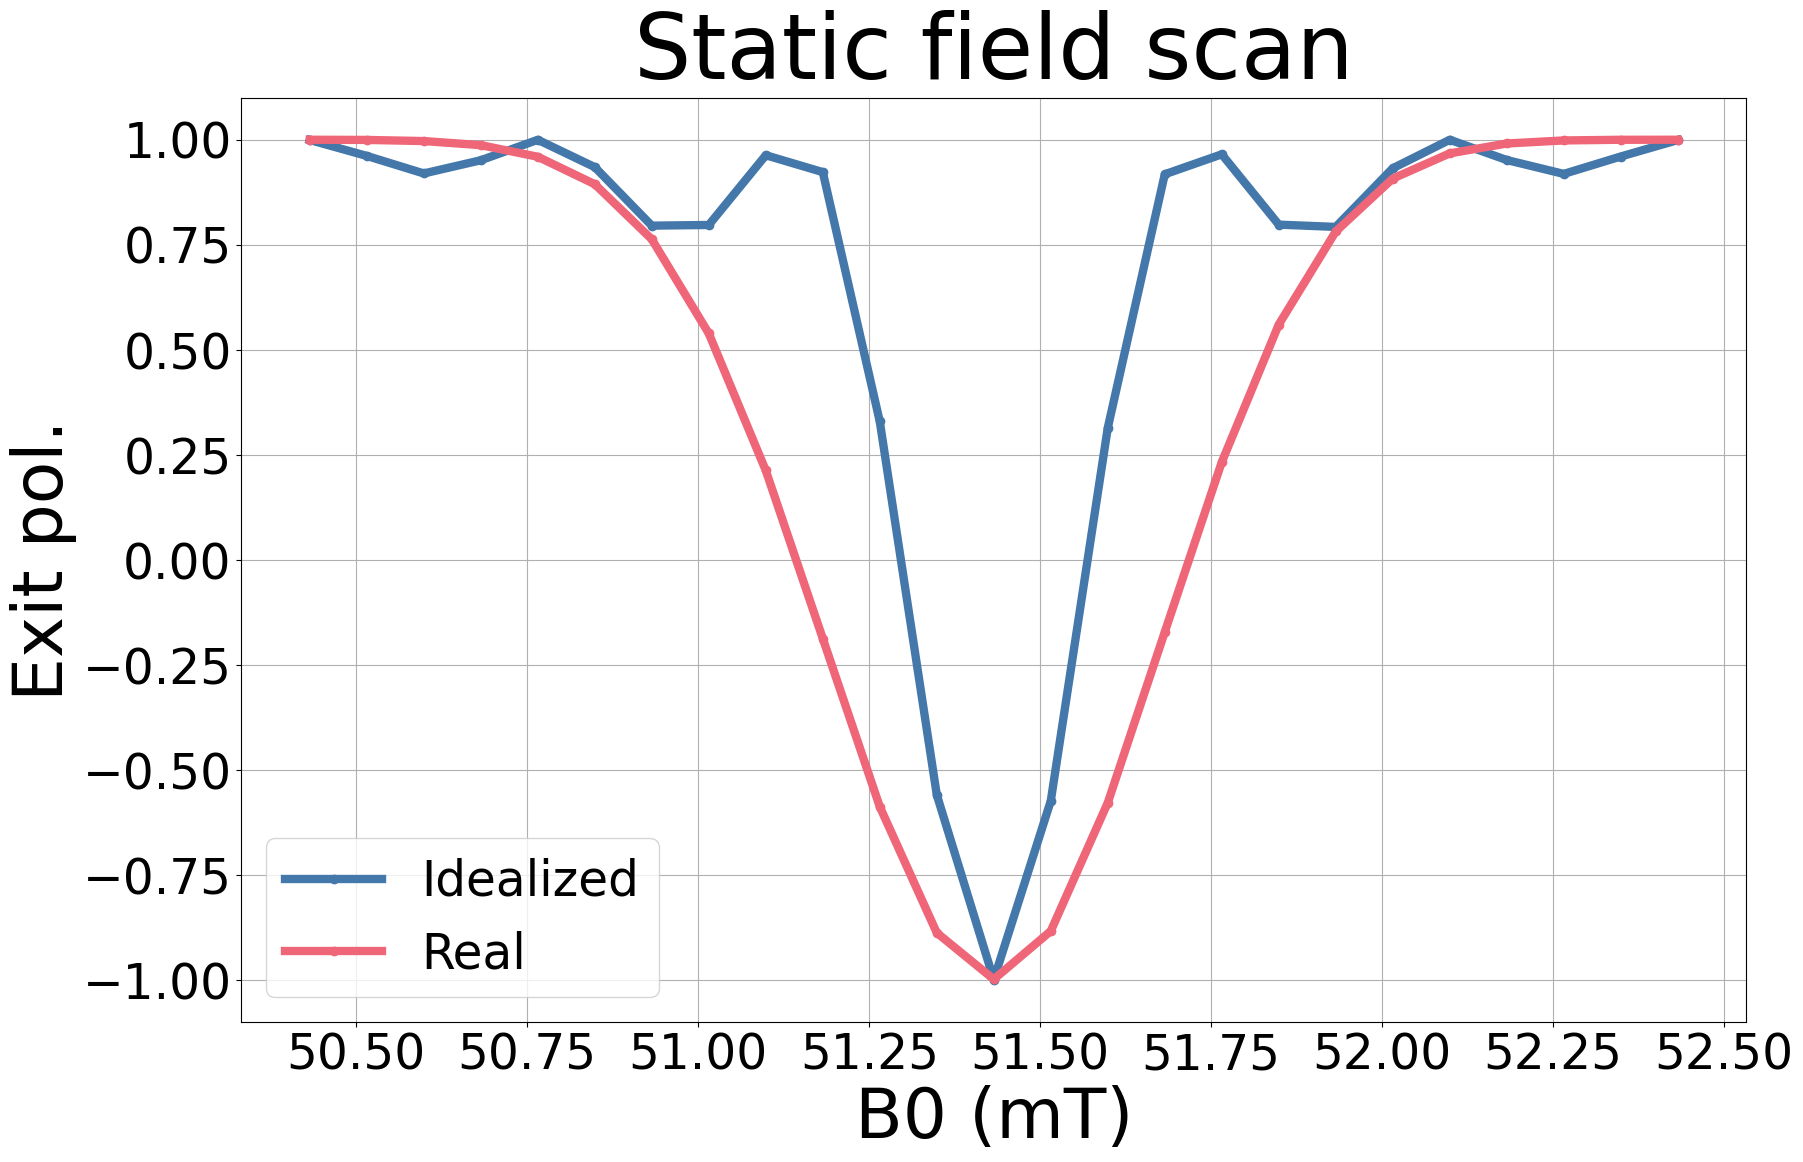

In [21]:
new_freq = get_new_freq(rf_freq-1e-2,rf_freq+1e-2,25,real_static=True,real_amp=True)
new_amp = get_new_amp(rf_amp,rf_amp+1,25,real_static=True,real_amp=True,plot=True)
new_b0 = compare_b0(b_0-1,b_0+1,25,new_amp,new_freq,real_static=True,real_amp=True,plot=False)

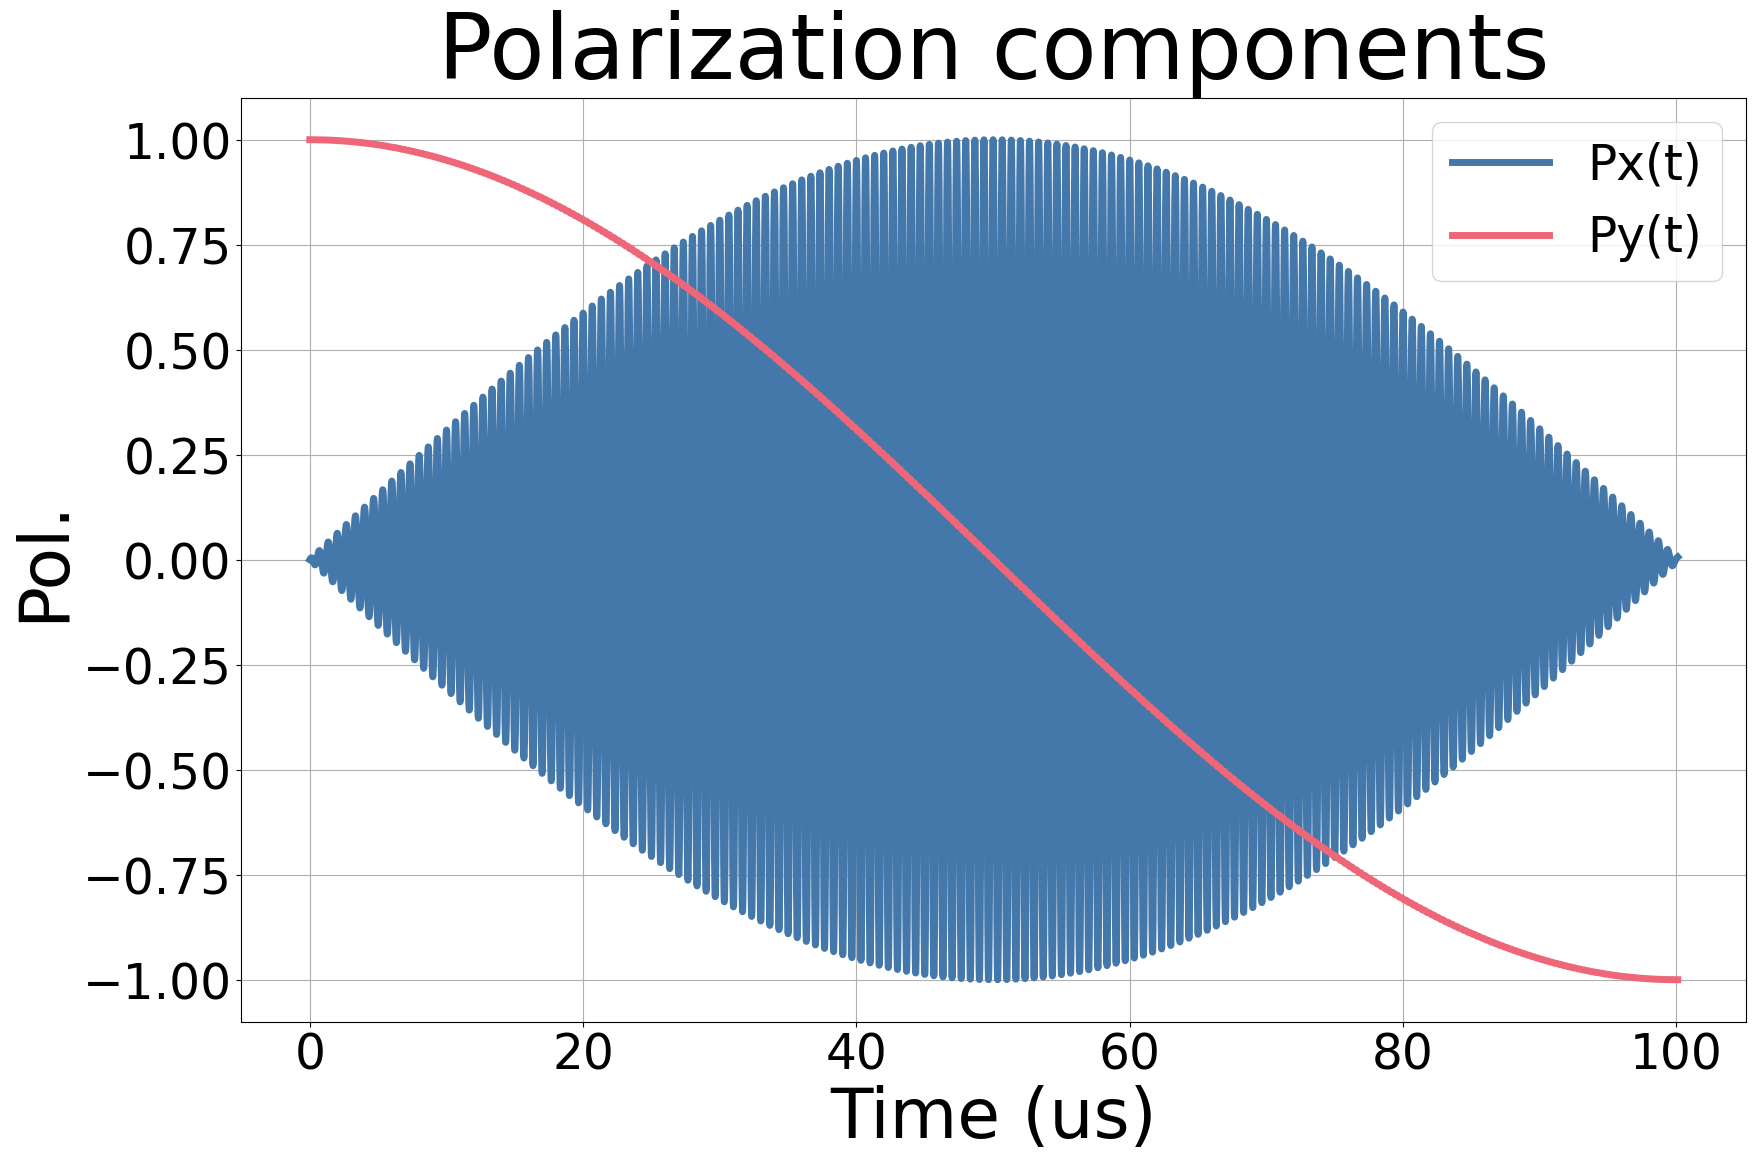

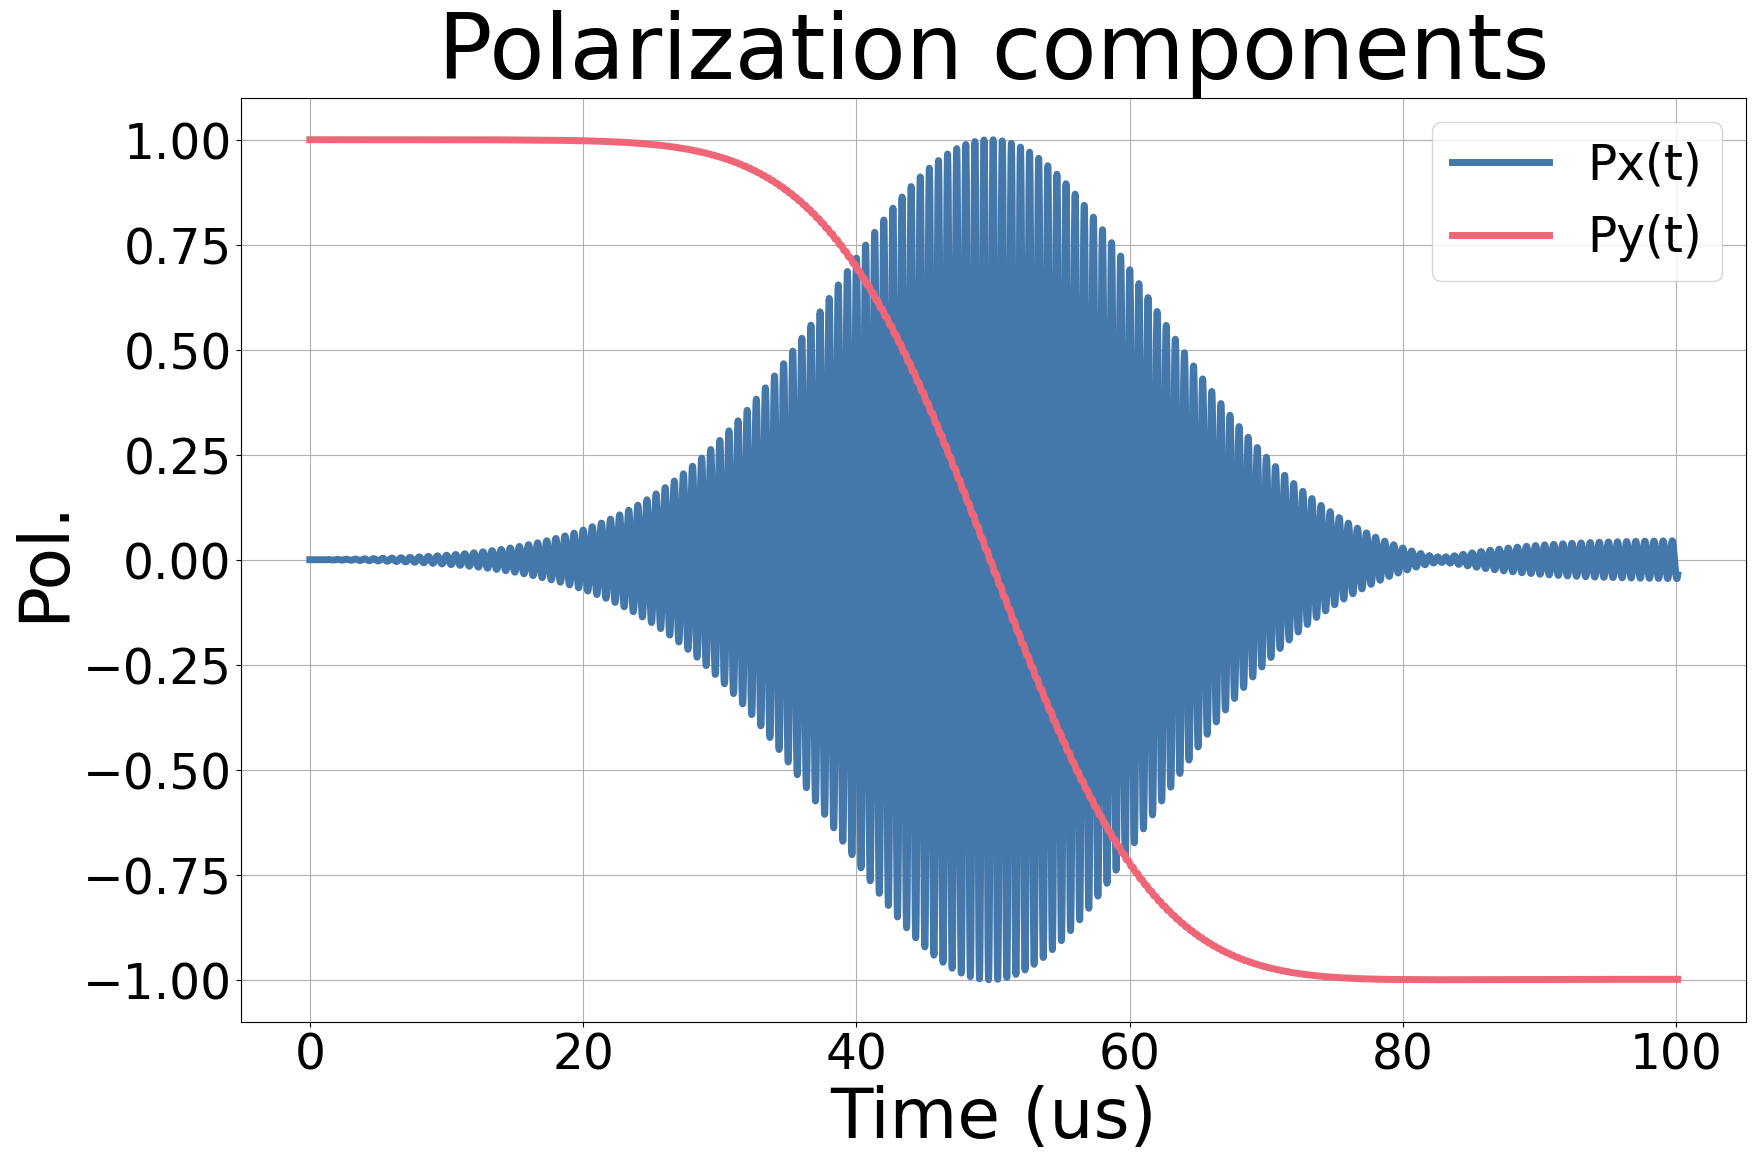

Ideal: Minimum pol:  -0.99996
Ideal: Minimum pol at t= 100.10025 

Real: Minimum pol:  -0.99998
Real: Minimum pol at t= 82.68668 

Ideal: Final pol:  -0.99996
Real: Final pol:  -0.99898


In [22]:
pols,pols2 = retuned_compare(new_b0,new_amp,new_freq,plot_pol=True,plot_bt=False)

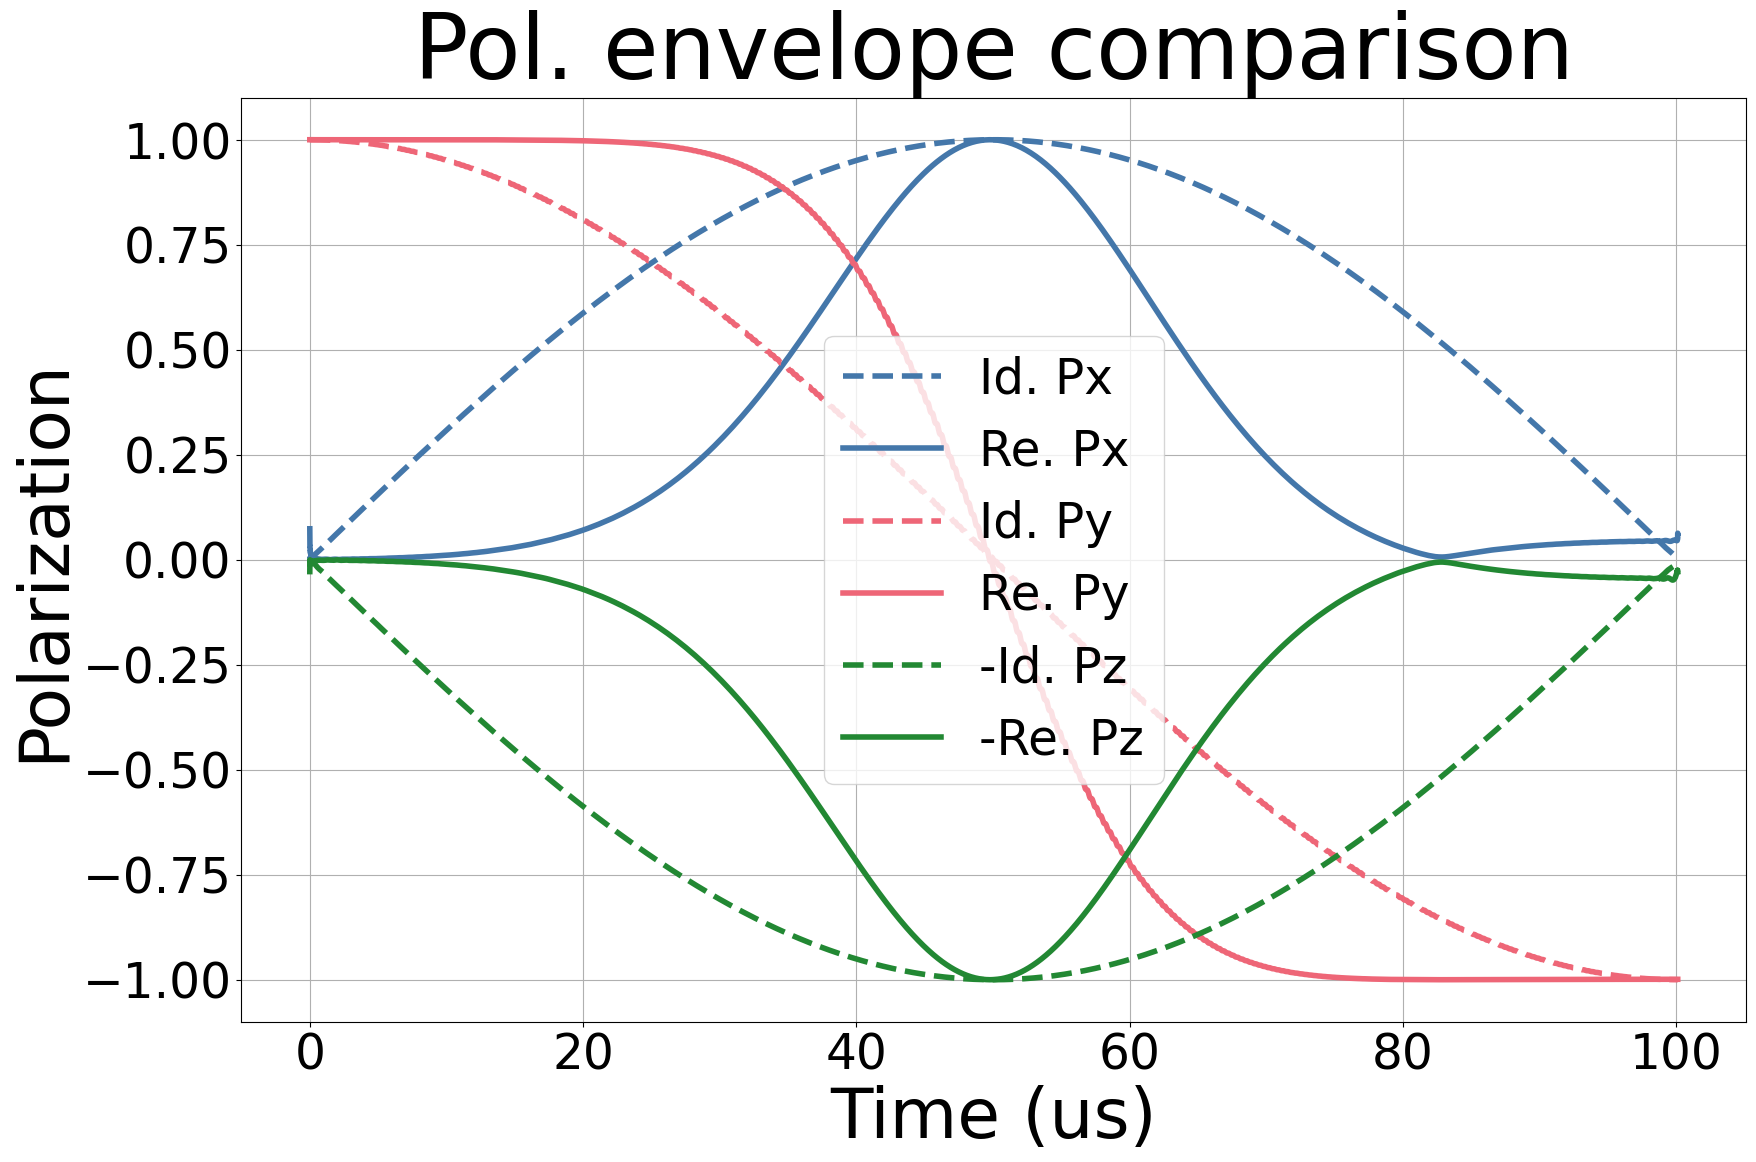

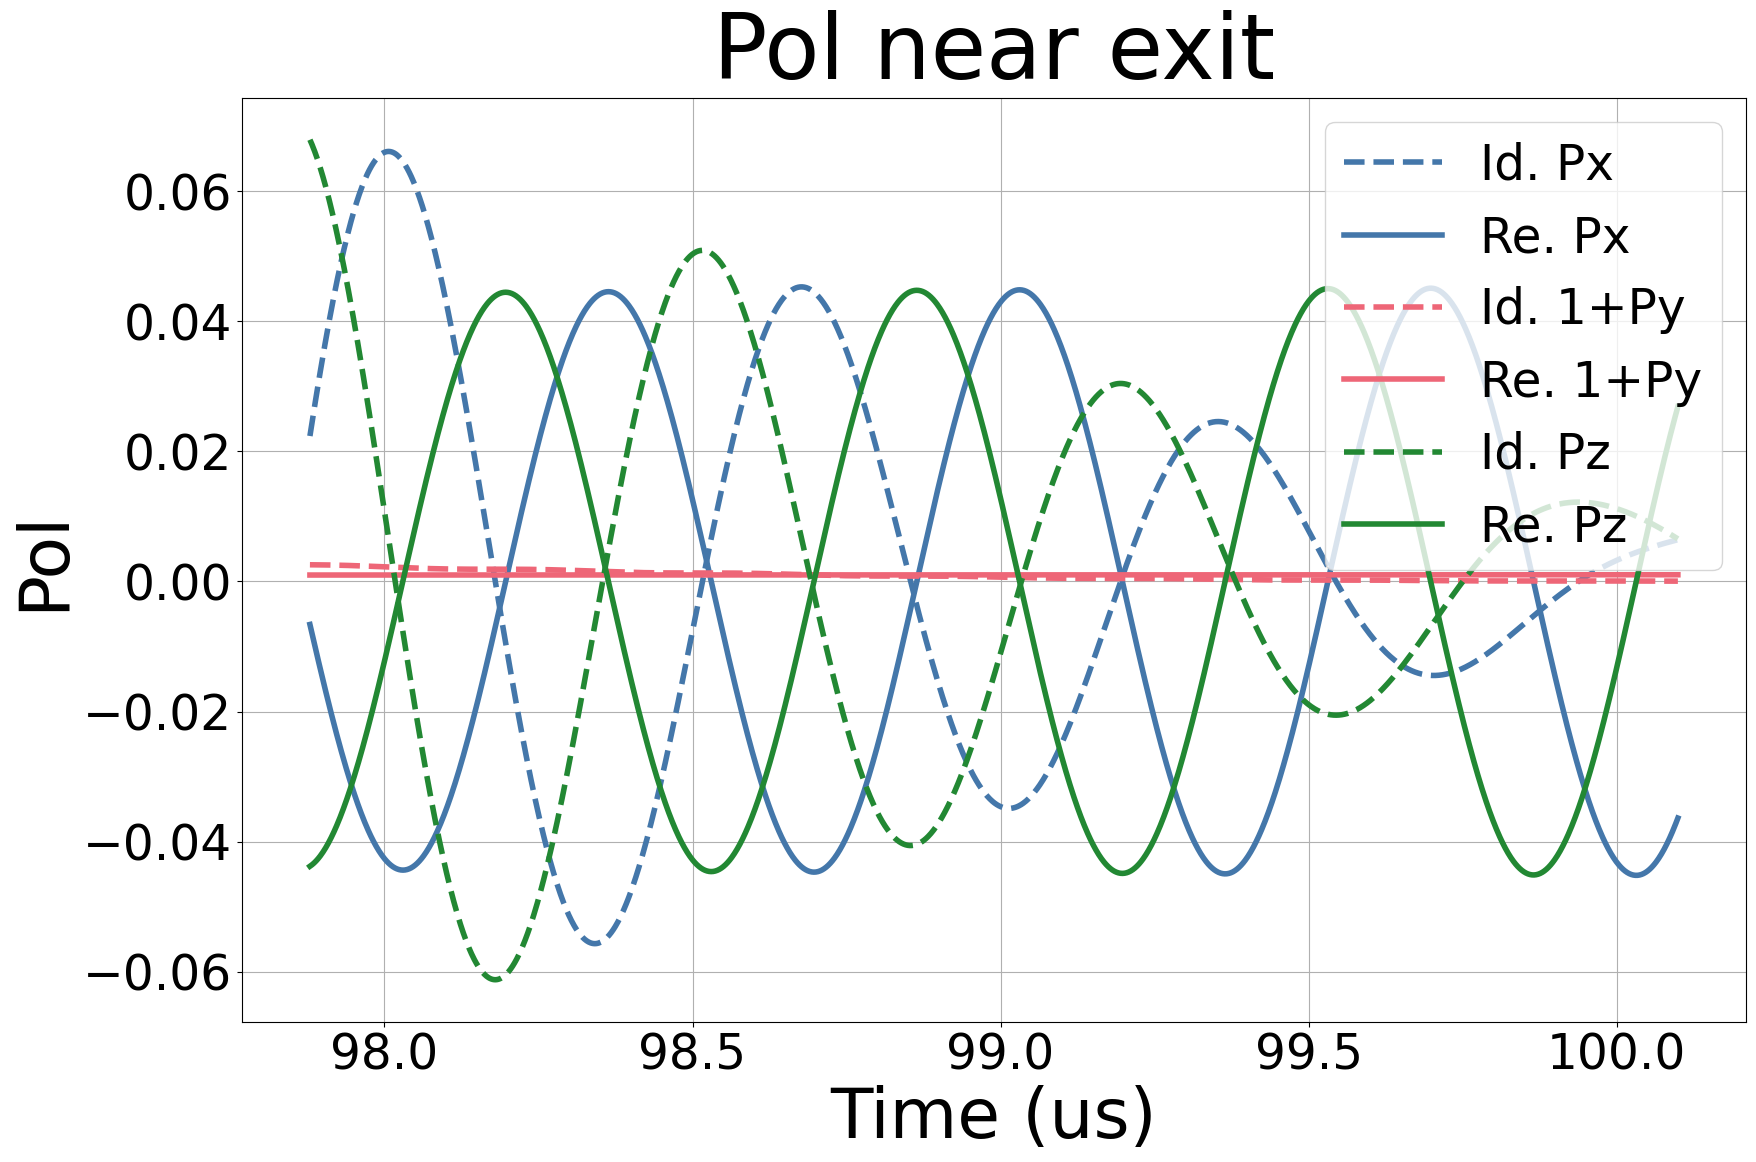

Real pol. norm check:  [-0.03610048 -0.99897688  0.02723889] -> 1.0000000000003224


In [25]:
get_envelope(pols,pols2,s=0,e=-1,plot=True)
do_stability_check(pols,pols2,s=-2000,e=-1,plot_near_min=False,plot_near_exit=True)

***
# Retuning for 3 MHz with real amplitude and static fields:
***

Min pol of  0.38205906525709554  at RF freq  2999.6684272018915


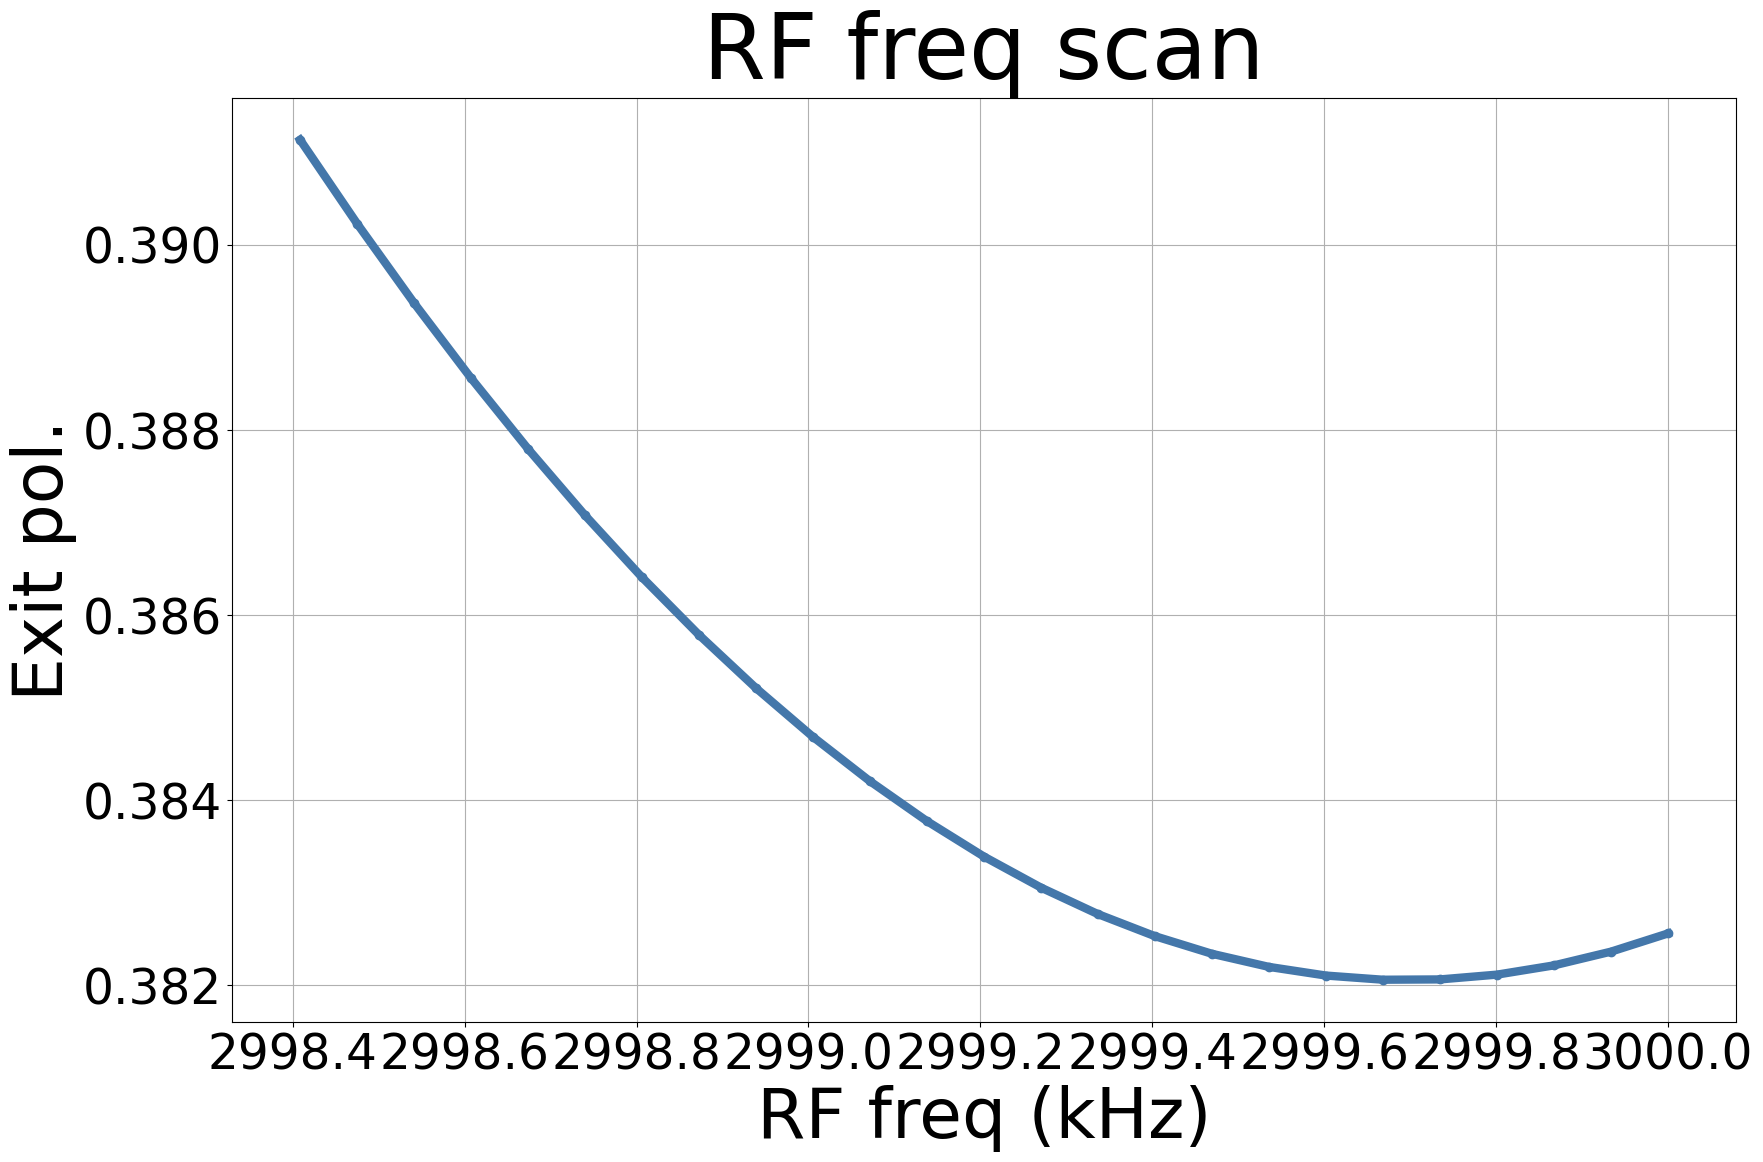

Min pol of  -0.9979056597646122  at RF amp  0.9258702842793349


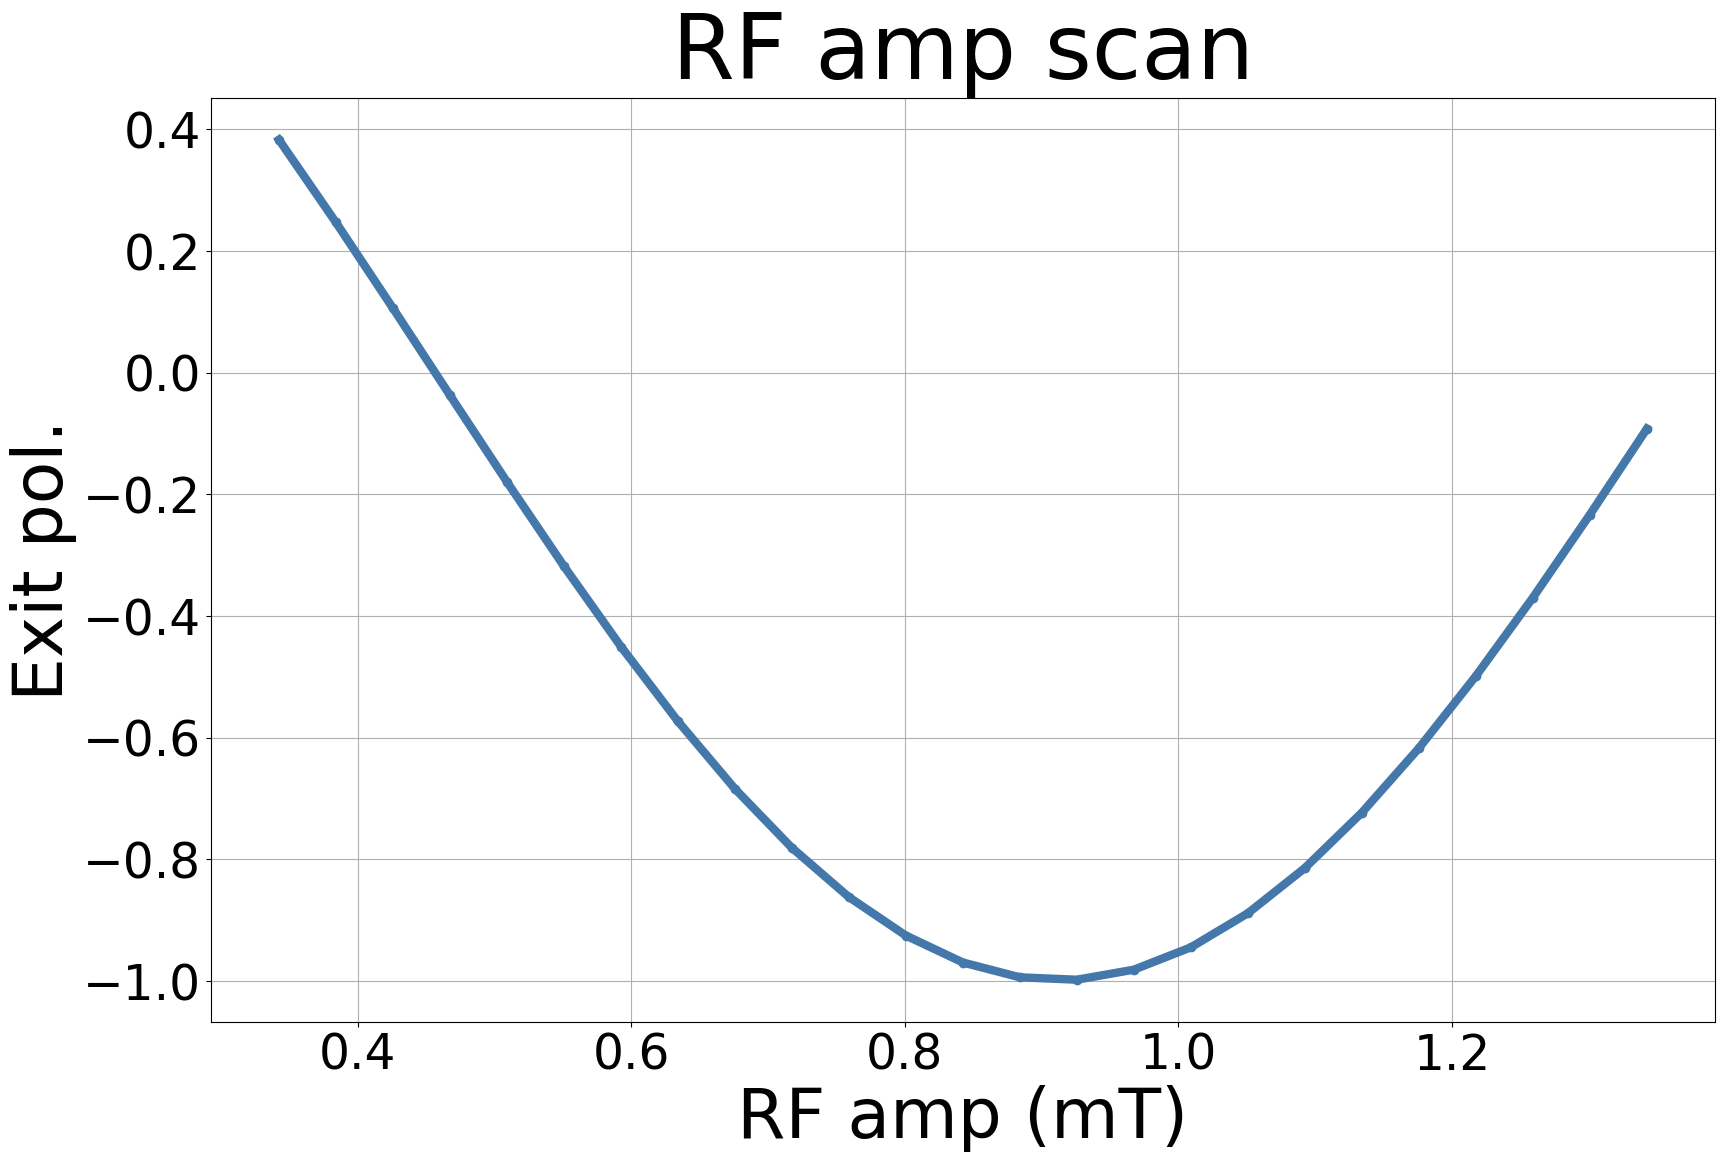

Comparison: 

Ideal: Min pol of  -0.9999308734822032  at b0  102.86410326923277
Real: Min pol of  -0.9988338264564225  at b0  102.86410326923277


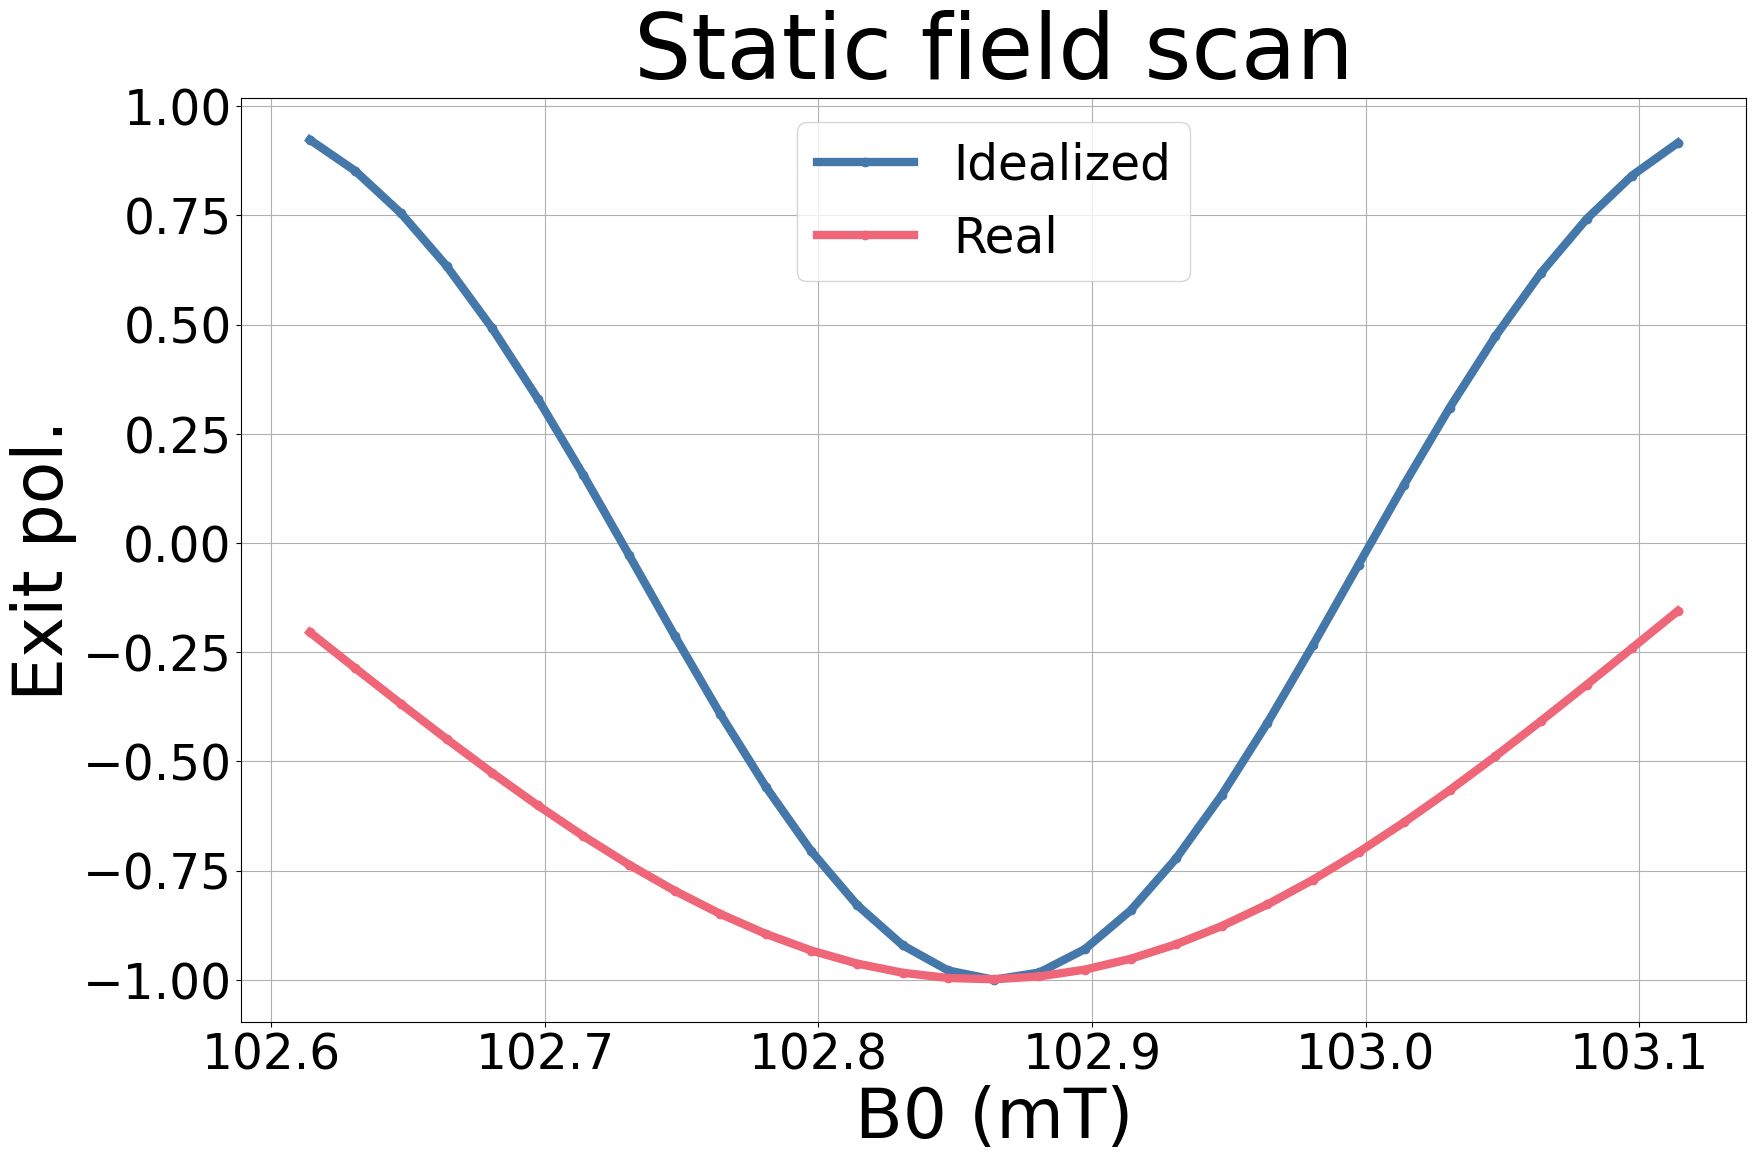

In [37]:
new_freq = get_new_freq(rf_freq-1e-2,rf_freq,25,real_static=True,real_amp=True)
new_amp = get_new_amp(rf_amp,rf_amp+1,25,real_static=True,real_amp=True,plot=True)
new_b0 = compare_b0(b_0-.25,b_0+.25,31,new_amp,new_freq,real_static=True,real_amp=True,plot=False)

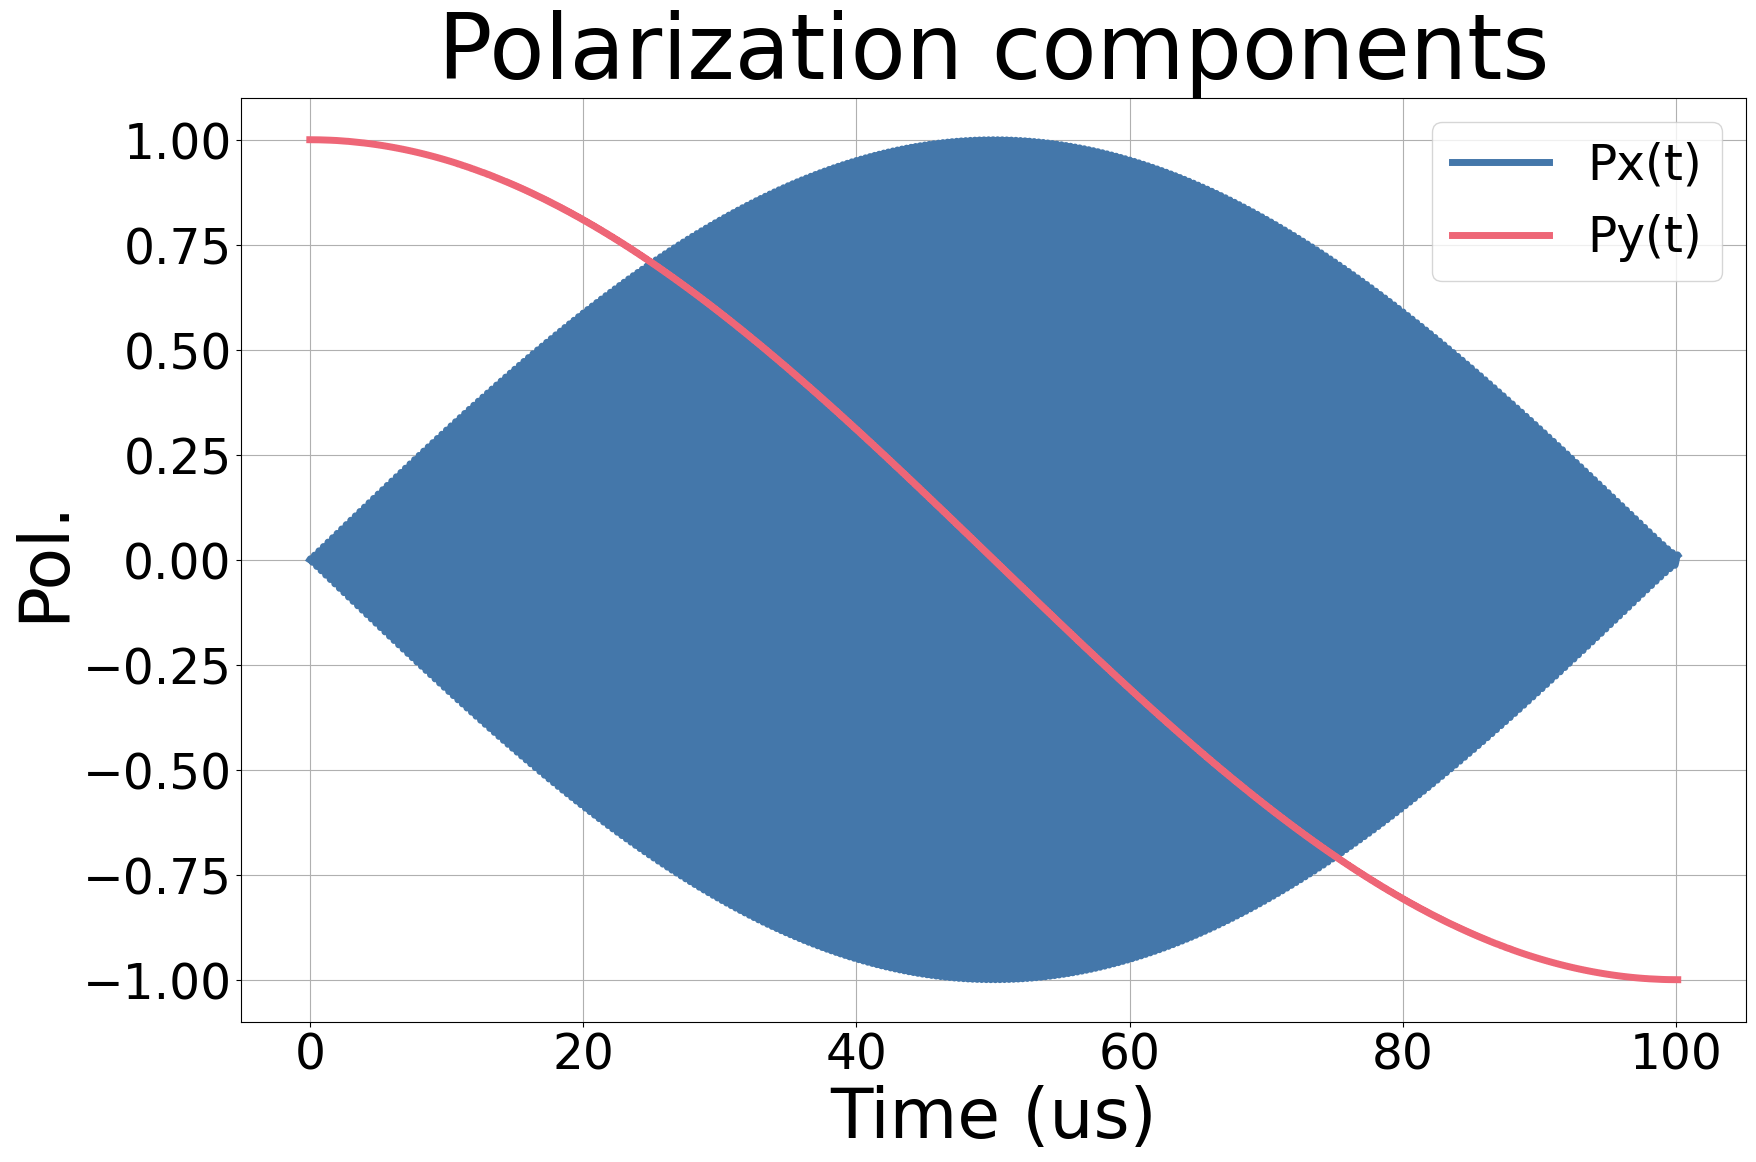

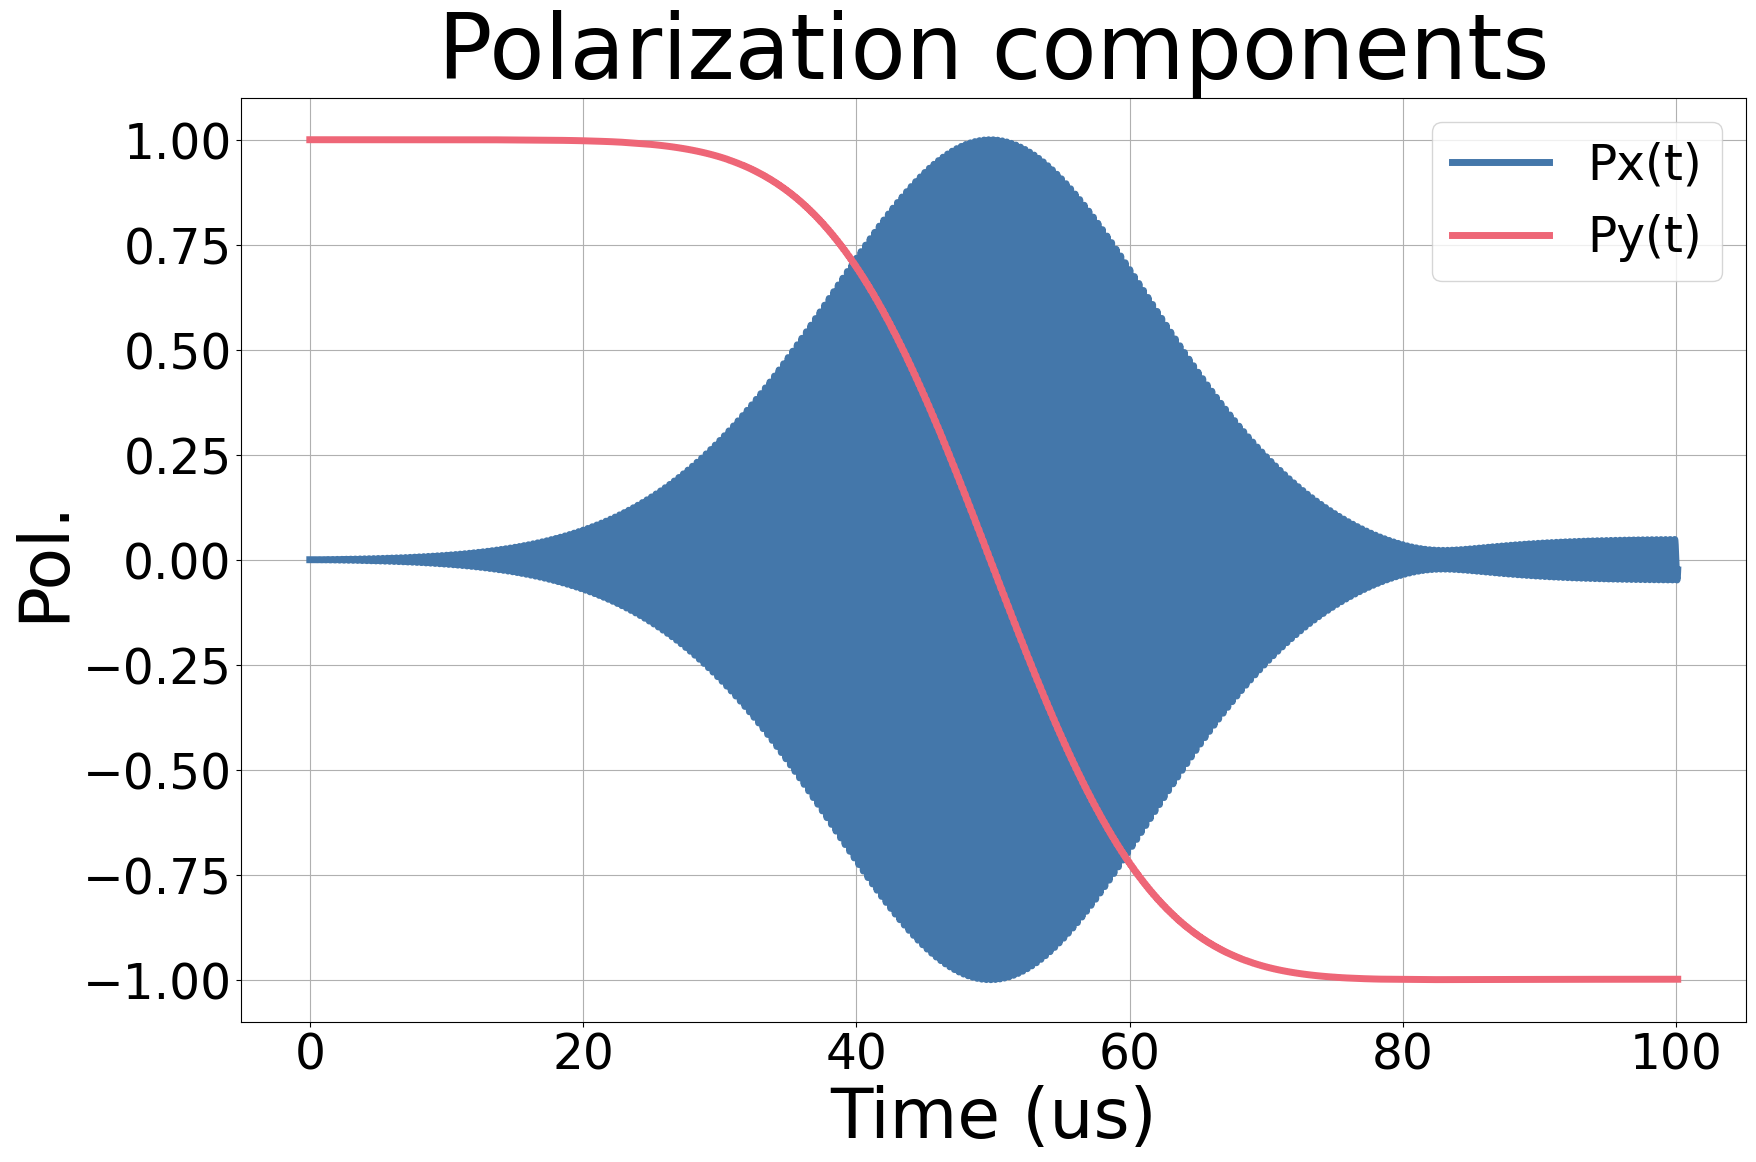

Ideal: Minimum pol:  -0.99993
Ideal: Minimum pol at t= 100.08303 

Real: Minimum pol:  -0.99976
Real: Minimum pol at t= 82.84344 

Ideal: Final pol:  -0.99993
Real: Final pol:  -0.99883


In [38]:
pols,pols2 = retuned_compare(new_b0,new_amp,new_freq,plot_pol=True,plot_bt=False)

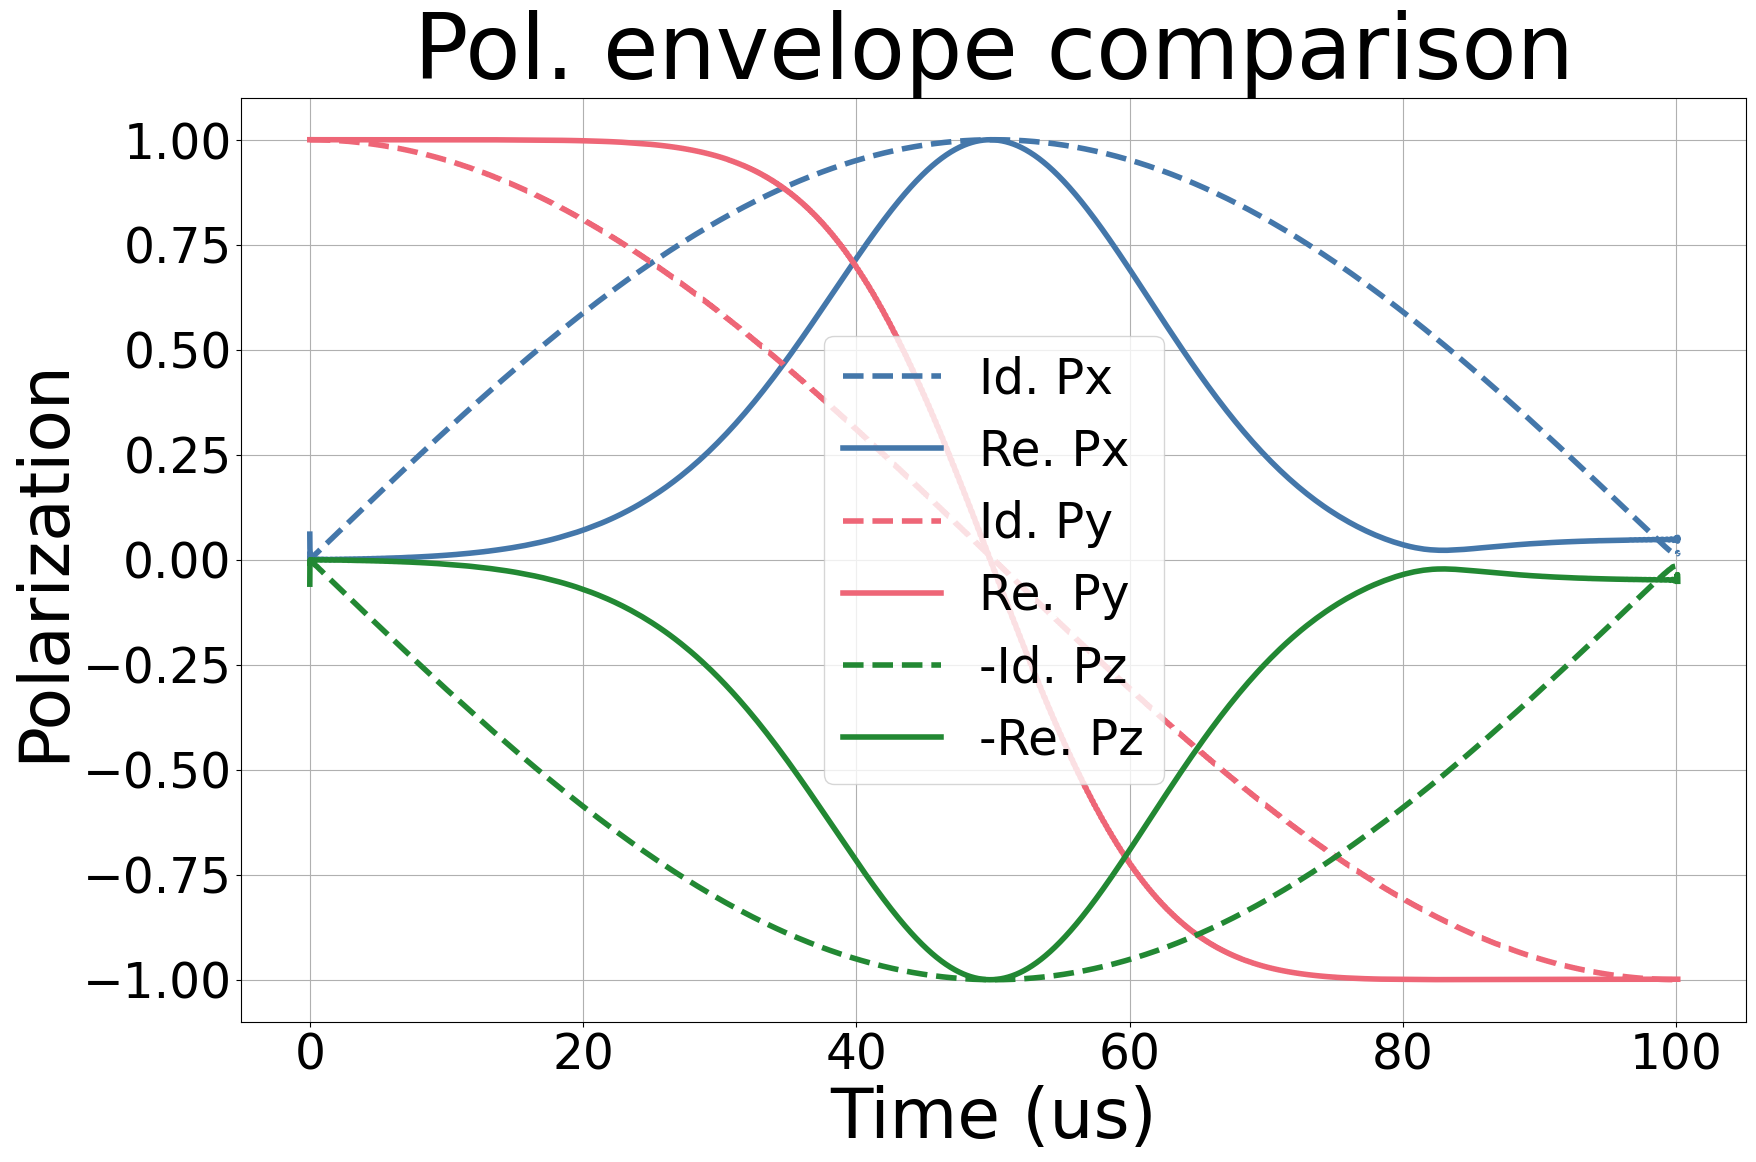

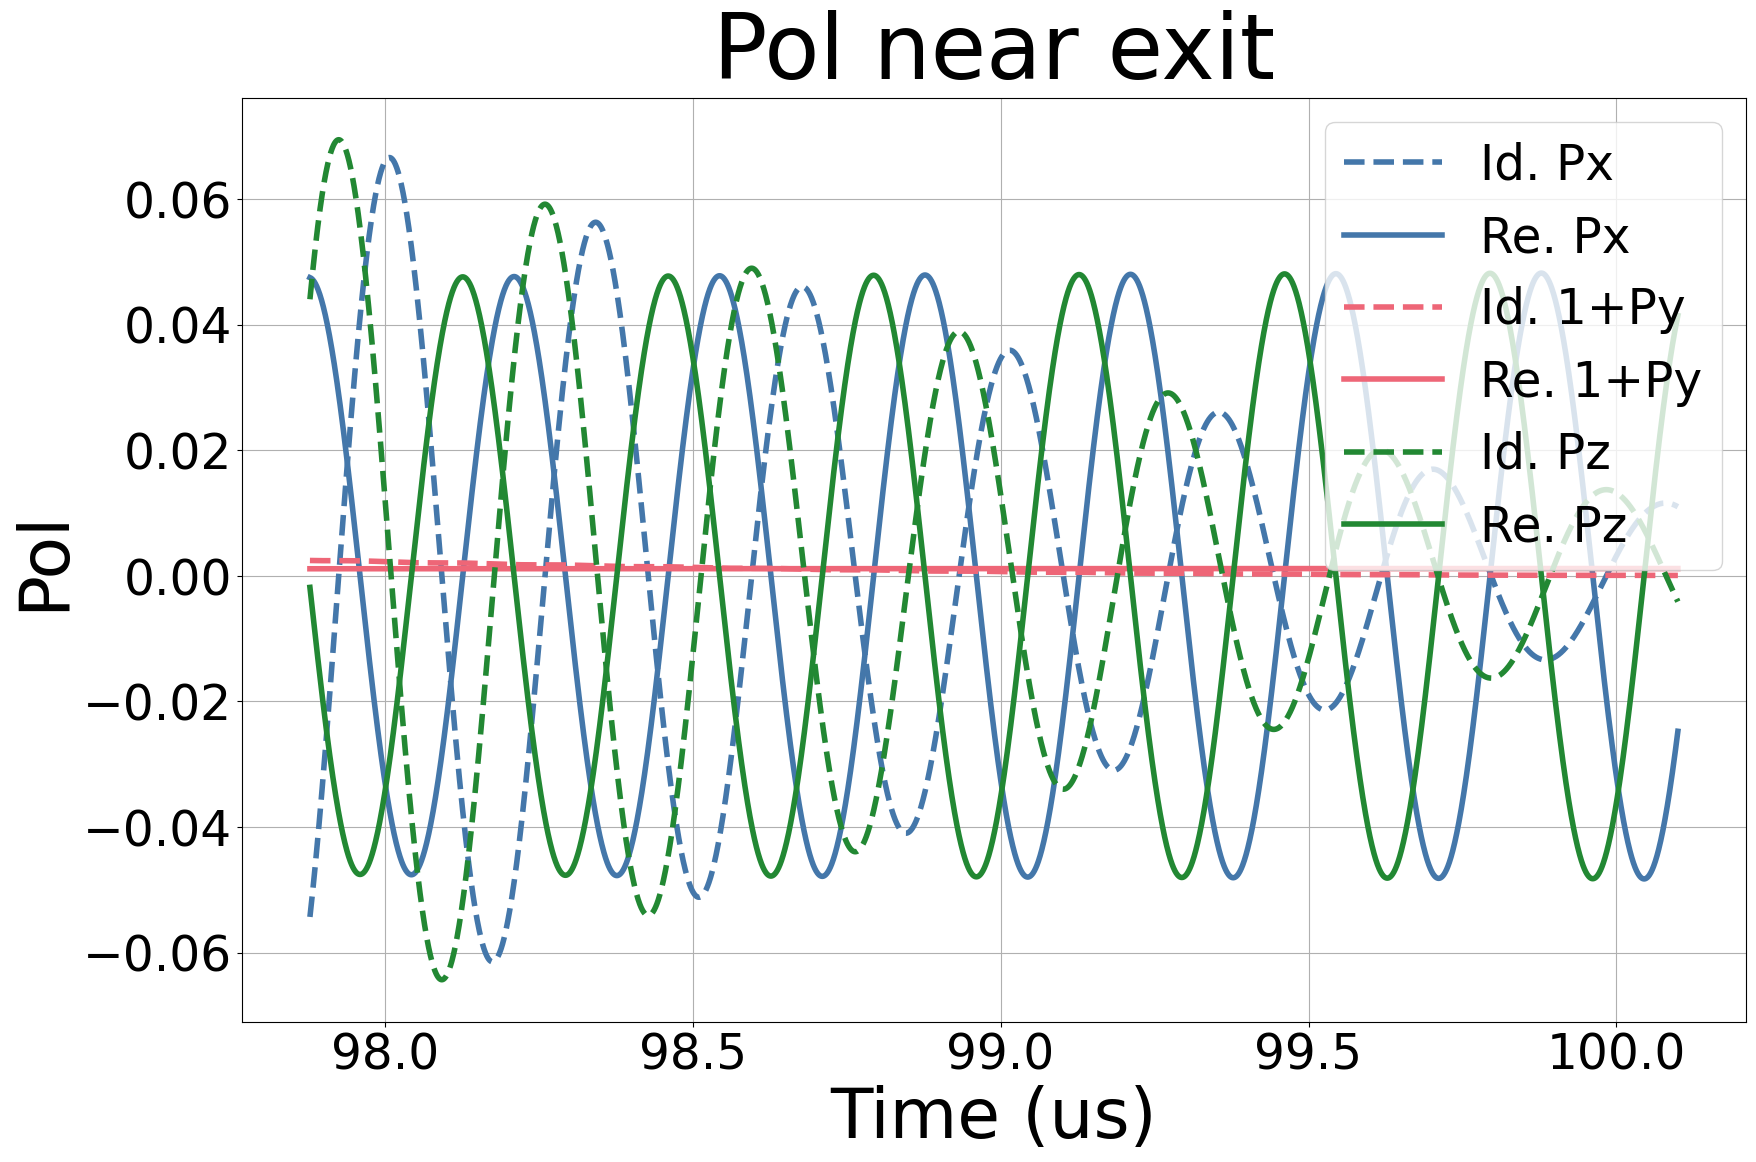

Real pol. norm check:  [-0.02431978 -0.99883383  0.04170774] -> 1.0000000000003535


In [40]:
get_envelope(pols,pols2,s=0,e=-1,plot=True)
do_stability_check(pols,pols2,s=-4000,e=-1,plot_near_min=False,plot_near_exit=True)

***
# Comparing static vs amplitude effects at 1MHz:
***

Min pol of  -0.9989757461122327  at RF amp  0.9258702842793349


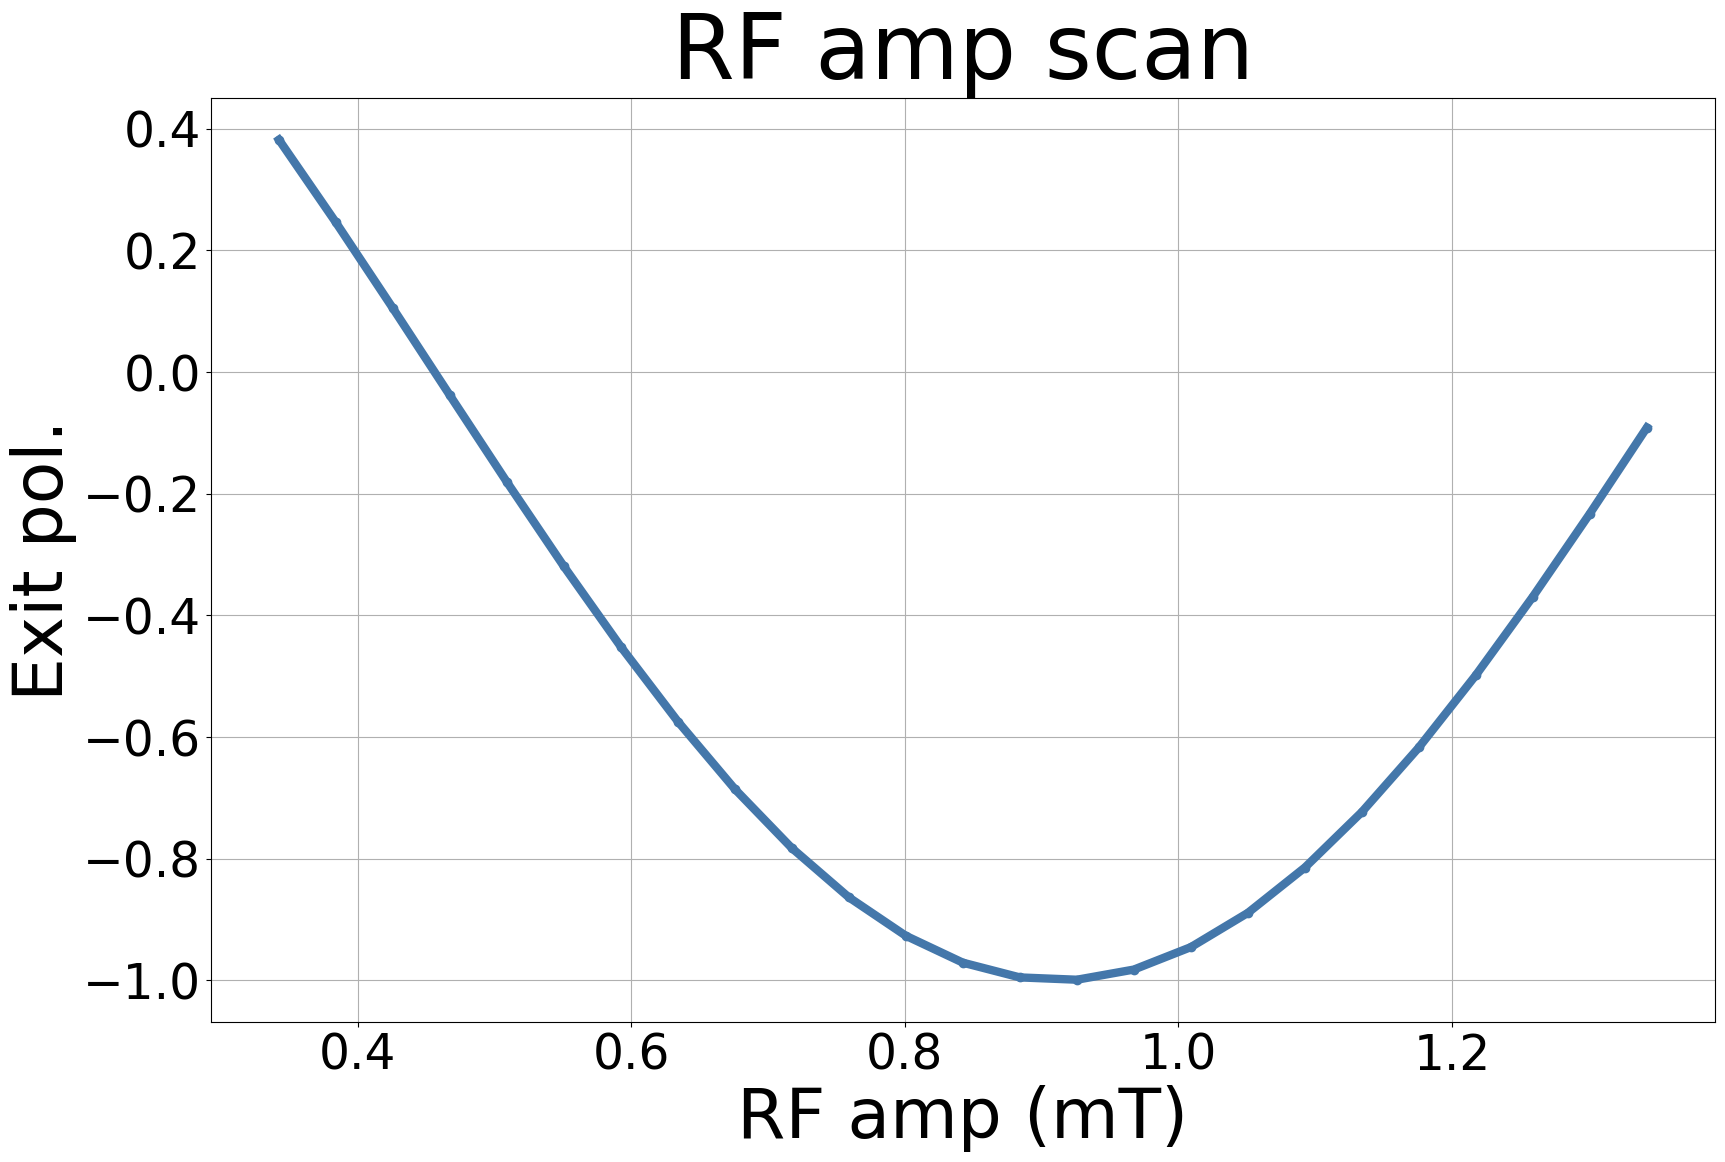

Comparison: 

Ideal: Min pol of  -0.9999539453377805  at b0  34.28803442307759
Real: Min pol of  -0.9989757461122327  at b0  34.28803442307759


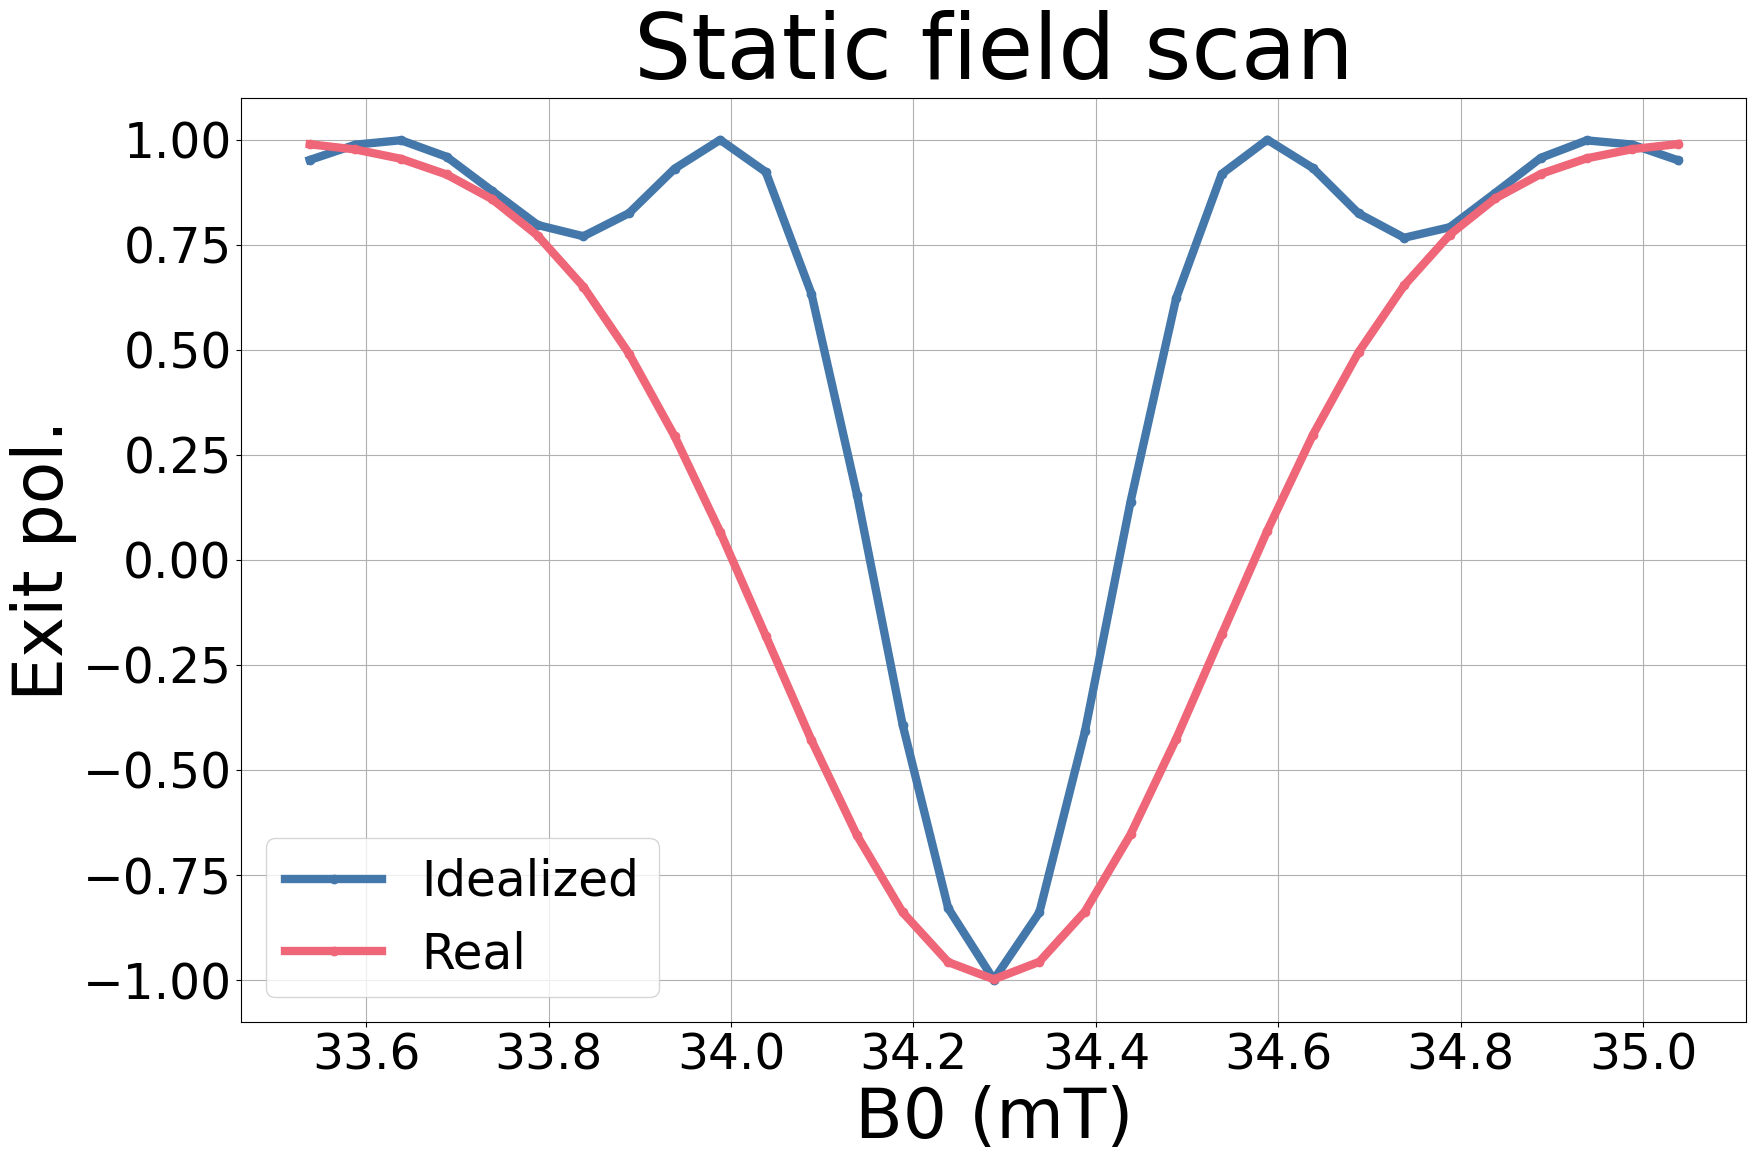

In [46]:
new_freq = rf_freq
new_amp = get_new_amp(rf_amp,rf_amp+1,25,real_static=False,real_amp=True,plot=True)
new_b0 = compare_b0(b_0-.75,b_0+.75,31,new_amp,new_freq,real_static=False,real_amp=True)

Min pol of  -0.9999024932827163  at RF freq  999.7347417615134


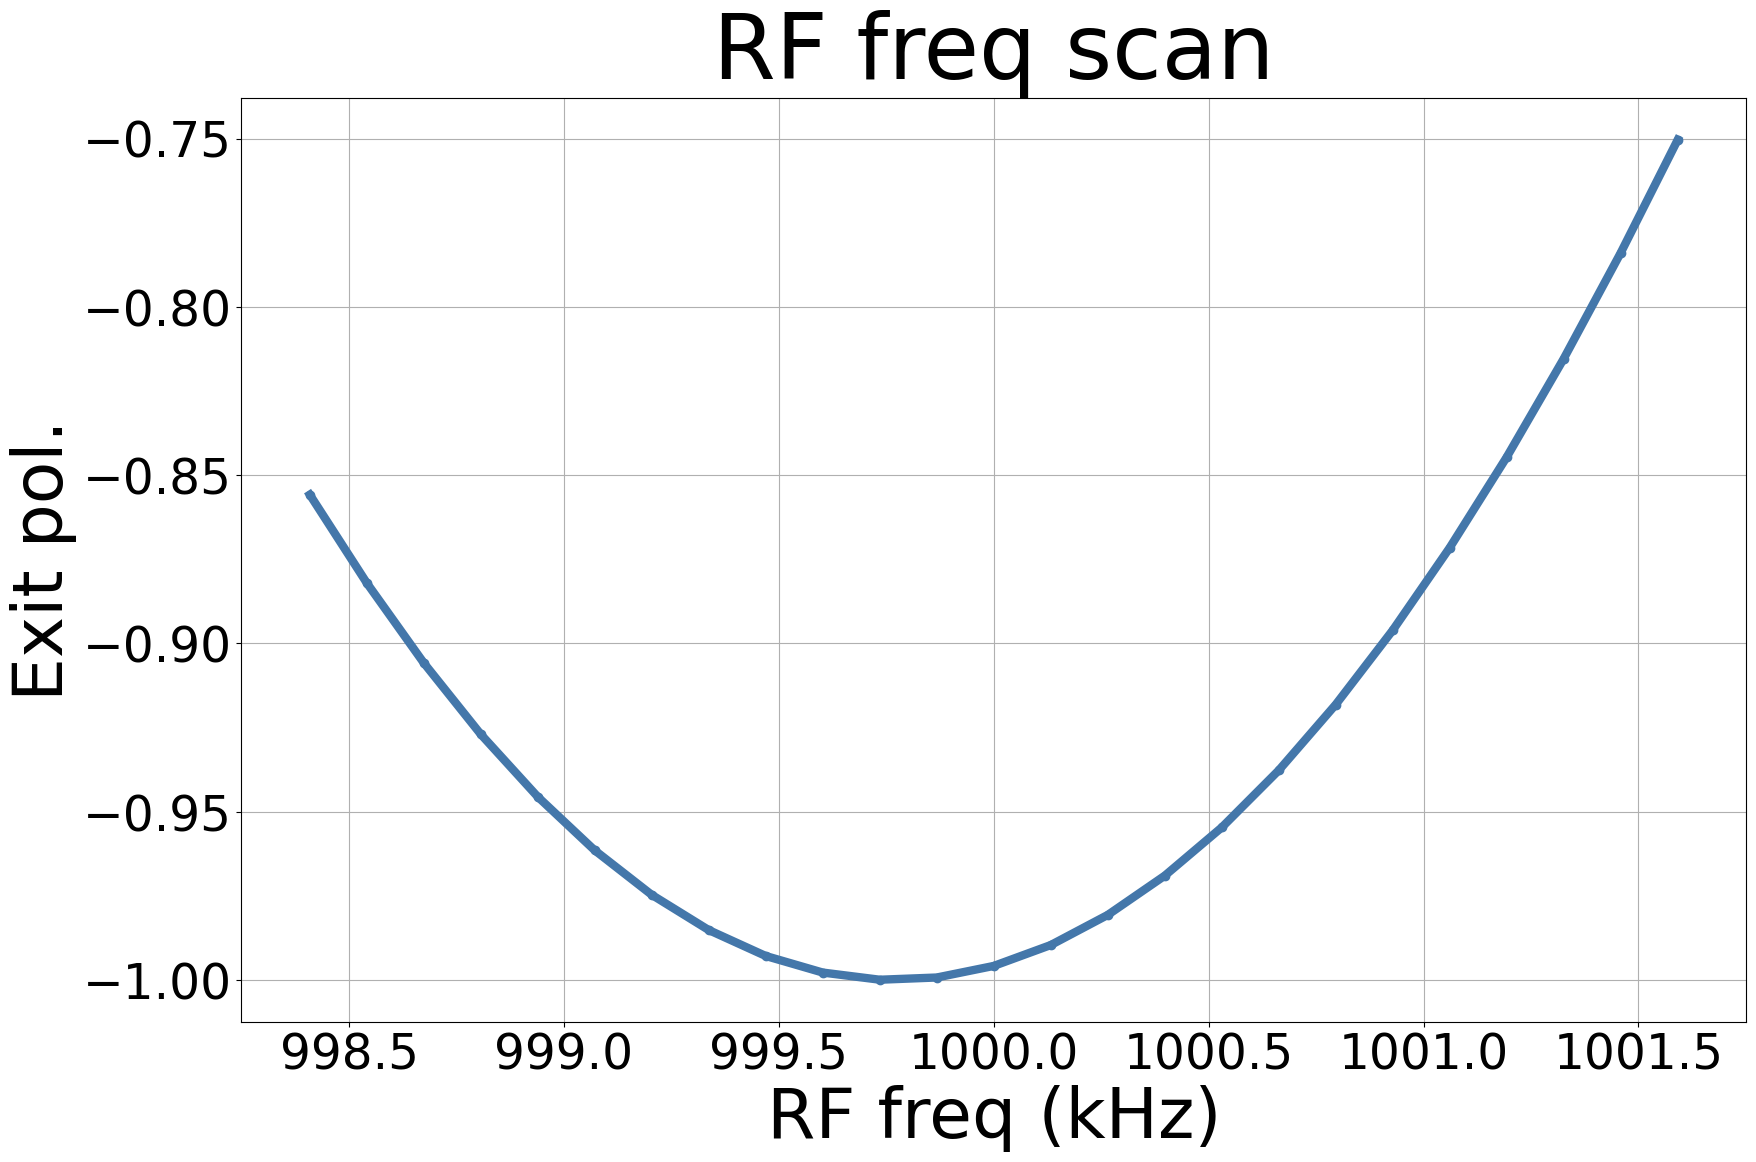

Comparison: 

Ideal: Min pol of  -0.9999539453377805  at b0  34.28803442307759
Real: Min pol of  -0.9999024932827163  at b0  34.28803442307759


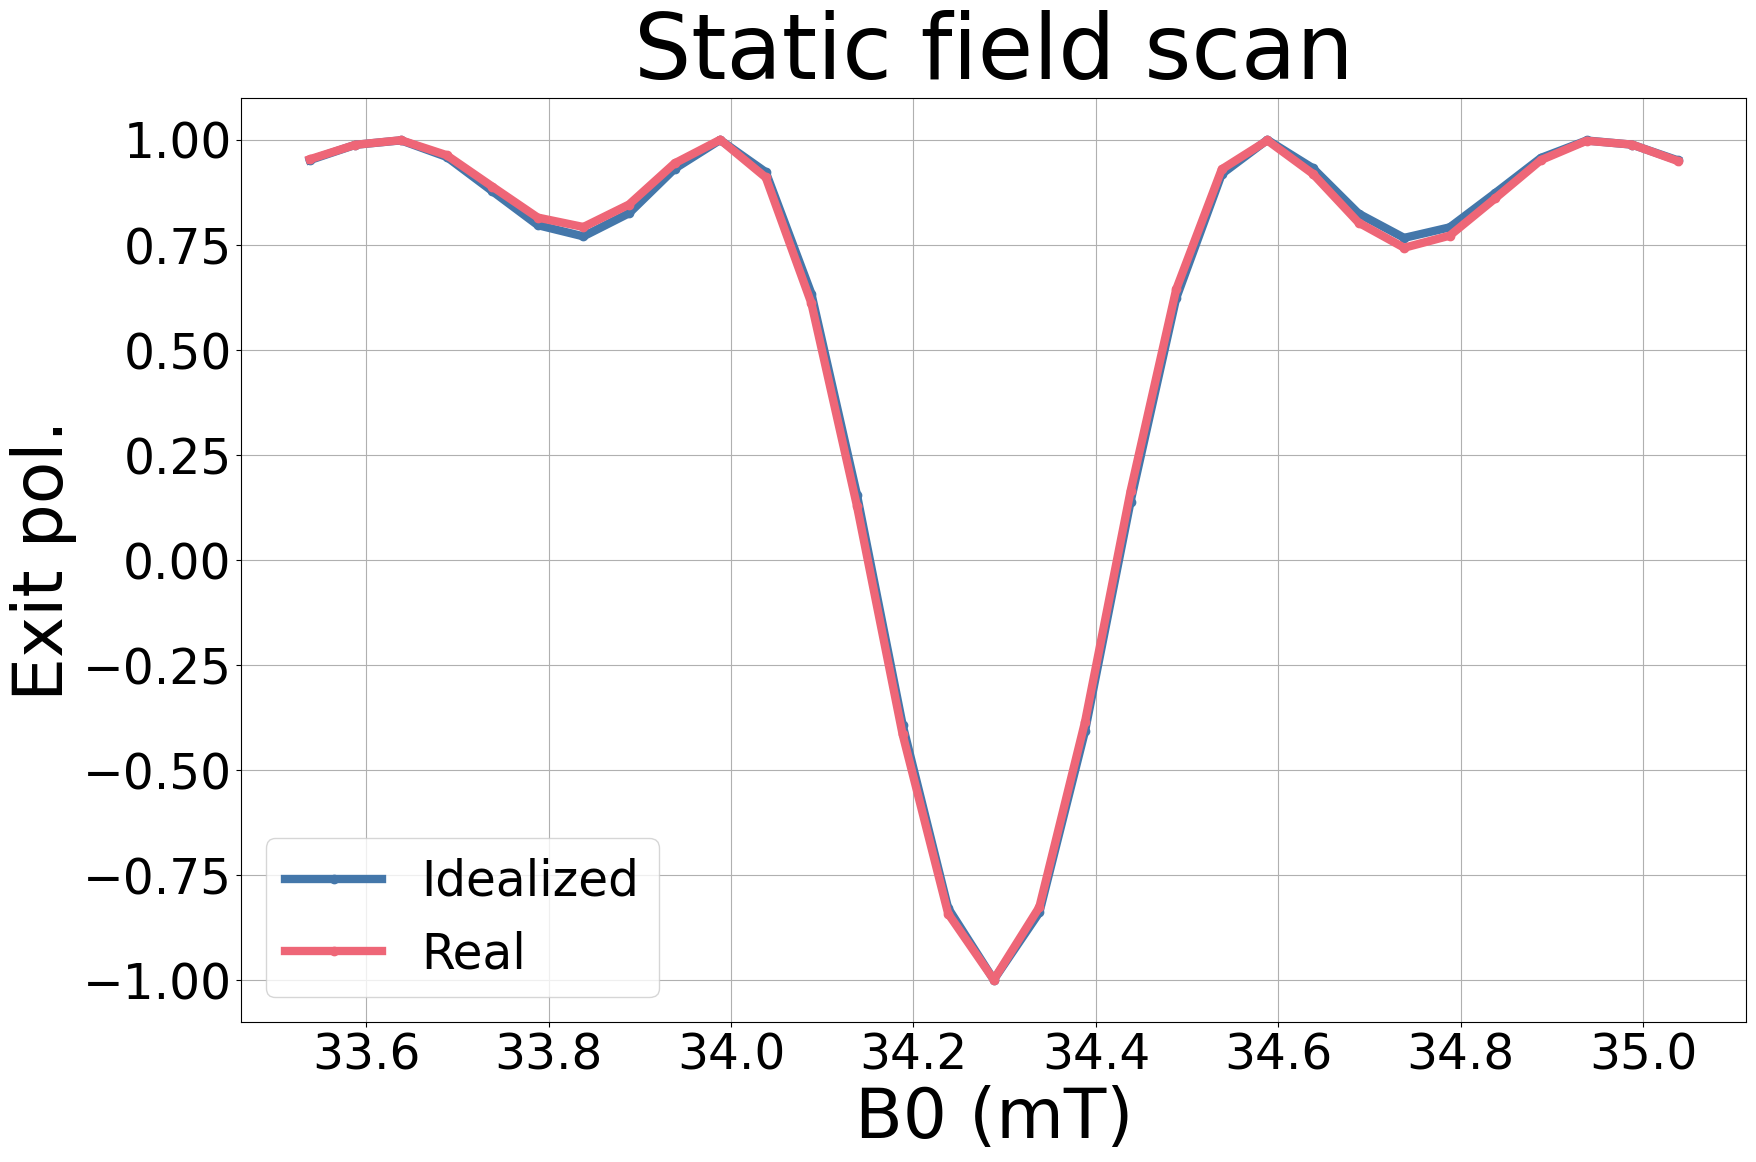

In [51]:
new_freq = get_new_freq(rf_freq-1e-2,rf_freq+1e-2,25,real_static=True,real_amp=False)
new_amp = rf_amp
new_b0 = compare_b0(b_0-.75,b_0+.75,31,new_amp,new_freq,real_static=True,real_amp=False)

***
# Convex vs Concave static field at 1 MHz:
***

Ideal: Min pol of  -0.9999705694830276  at b0  34.2880344230776
Real: Min pol of  -0.9989335383826853  at b0  34.2880344230776


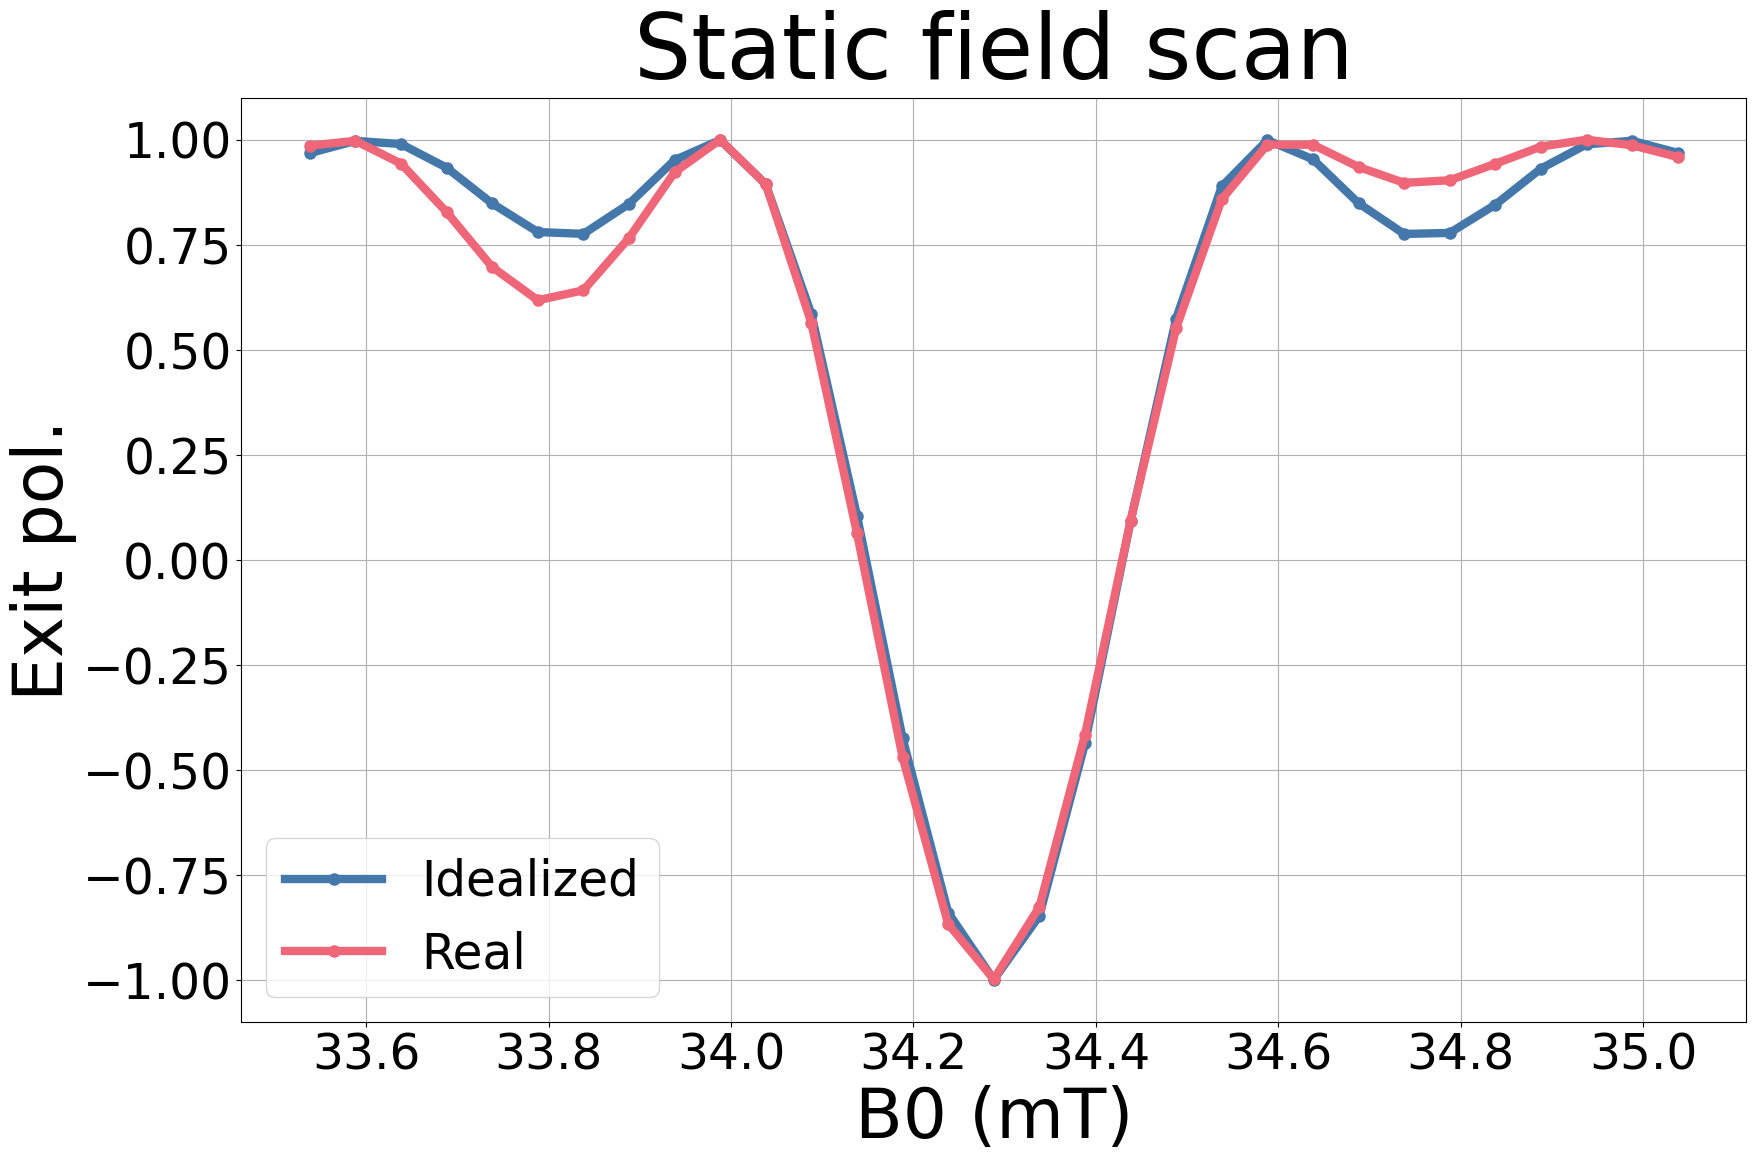

In [32]:
#new_freq = get_new_freq(rf_freq-8e4,rf_freq-4e4,21,real_static=True,real_amp=False)
new_amp = rf_amp
new_b0 = compare_b0(b_0-7.5e-4,b_0+7.5e-4,31,new_amp,new_freq,real_static=True,real_amp=False)

***
### Modeling the real RF flipper:
***

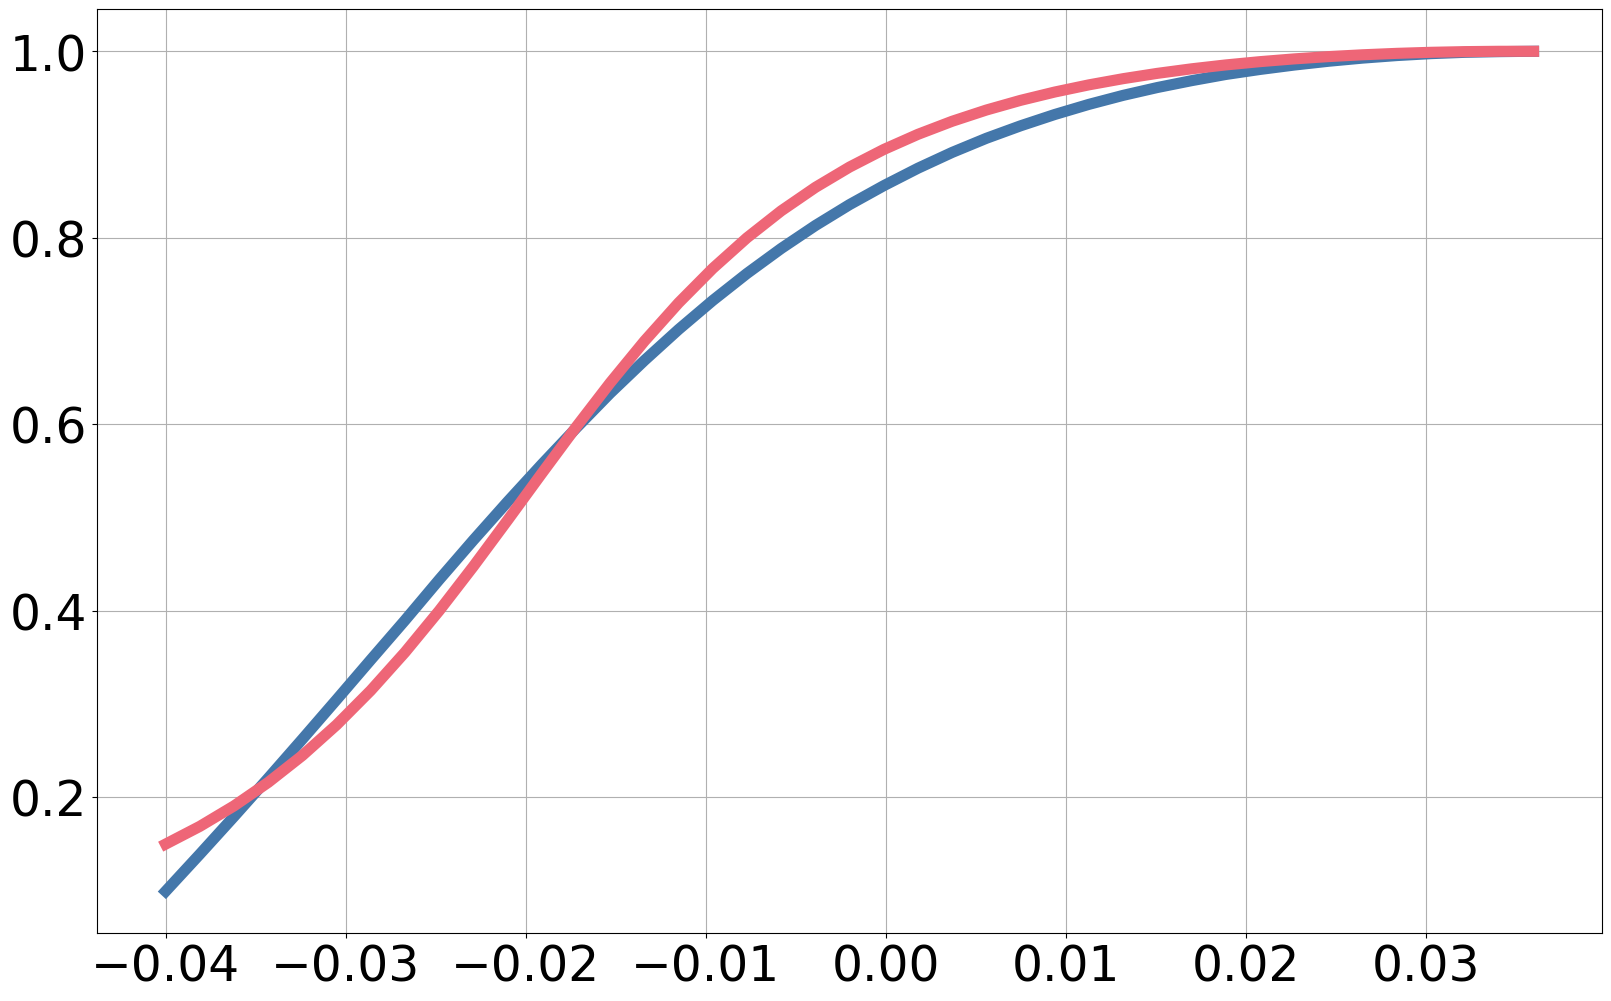

In [55]:
def fs(z,R,start,end):
    temp = ((z-start)/np.sqrt((z-start)**2 + R**2) - (z-end)/np.sqrt((z-end)**2 + R**2))
    return 1/np.max(temp)*temp

real_rf = [12.32567932,12.32086105,12.31193595,12.29454577,12.26900429,12.23531153,12.19346747,12.14347213,12.08532549,\
           12.01902756,11.93720972,11.84662874,11.74309357,11.62420775,11.48997126,11.34038411,11.1754463,10.98867451,\
           10.77982848,10.54901546,10.2988534,10.02202053,9.71851683,9.388342316,9.031496982,8.64798083,8.237793859,\
           7.806084708,7.342475923,6.864145888,6.371094603,5.863322069,5.340828286,4.803613252,4.281318755,3.754428023,\
           3.232455925,2.716295675,2.209035134,1.710843131,1.220842601]
real_rf = real_rf/np.max(real_rf)
pos = np.linspace(.036,-.04,41)

fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(pos,real_rf,linewidth=5)
plt.plot(pos,fs(pos,0.02,-.02,.09),linewidth=5)
plt.grid()
plt.show()

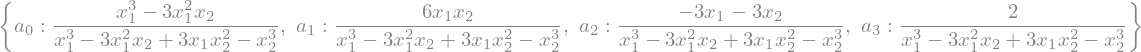

In [113]:
x,a0,a1,a2,a3,x1,x2 = sym.symbols('x,a_0,a_1,a_2,a_3,x_1,x_2', real=True)

def s(x,a0,a1,a2,a3):
    return a3*x**3 + a2*x**2 + a1*x + a0
def sp(x,a1,a2,a3):
    return 3*a3*x**2 + 2*a2*x + a1

eq1 = sym.Eq(s(x1,a0,a1,a2,a3),0)
eq2 = sym.Eq(s(x2,a0,a1,a2,a3),1)
eq3 = sym.Eq(sp(x1,a1,a2,a3),0)
eq4 = sym.Eq(sp(x2,a1,a2,a3),0)

display(eq1)
display(eq2)
display(eq3)
display(eq4)

sol = sym.solve((eq1,eq2,eq3,eq4),(a0,a1,a2,a3))
display(sol)

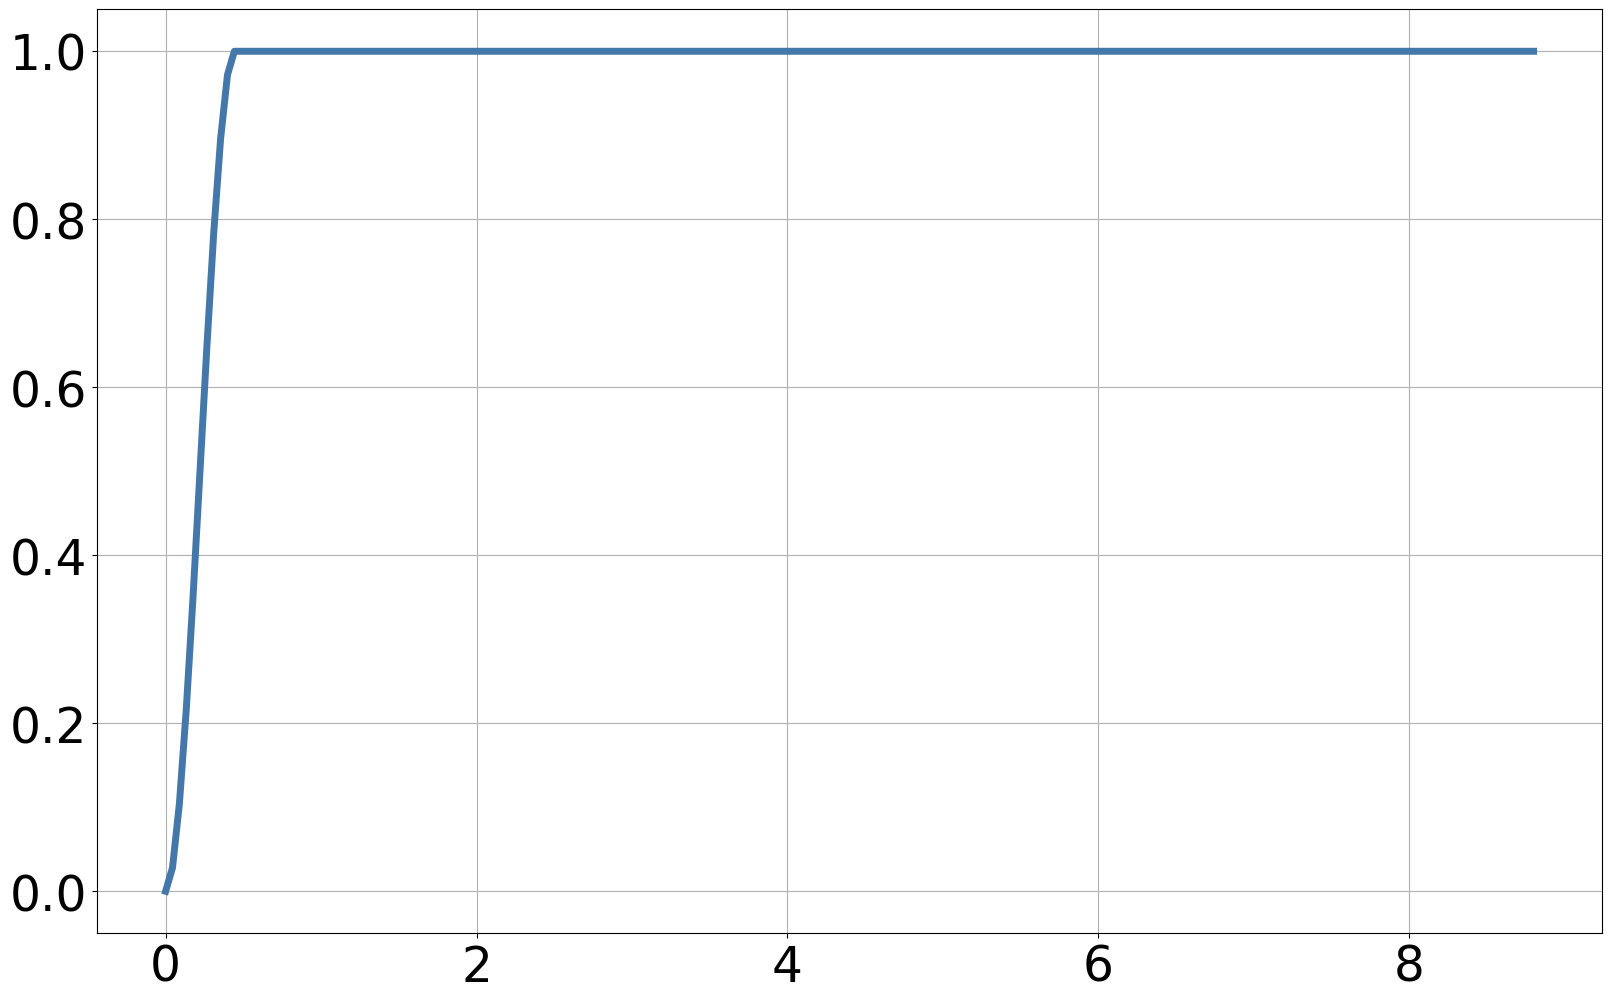

In [24]:
def smooth_step(z,start,end,n,a):
    """Returns 3D smoothed step function of magnetic field in given direction n with strength a"""
    s,e = z[start],z[end]
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    a0 = (s**3 - 3*s**2*e)/(s - e)**3
    a1 = 6*s*e/(s - e)**3
    a2 = -3*(s + e)/(s - e)**3
    a3 = 2/(s - e)**3
    temp = np.zeros(len(z))
    temp[start:end] = a0 + a1*z[start:end] + a2*z[start:end]**2 + a3*z[start:end]**3
    temp[end:-1] = np.ones(len(zpos)-end - 1)
    temp[-1] = 1
    return np.array([a*ni*temp for ni in normed])

fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(zpos,smooth_step(zpos,0,10,(0,1,0),1)[1],linewidth=5)
plt.grid()
plt.show()

***
### Miscellaneous calculations
***

In [11]:
def doppler(freq, v, rel=True): #checking the strength of the Doppler effect
    temp = (1+v/2.99e8)*freq
    if rel:
        temp = (temp - freq)*100
    return temp
doppler(3e6,get_vg(4))

In [29]:
def irr(freq,n,I,a): #checking the power radiated
    return 1/2*4*np.pi*1e-7*(n*I*np.pi*a*sc.special.jv(1,freq*a/3e8))**2*freq

irr(2*np.pi*3e6,1400,1,.02)